In [1687]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec      # for customizing subplot grid layout
import statsmodels.api as sm                # for ANOVA
from statsmodels.formula.api import ols     # for ANOVA

In [1688]:
# create dataframe
data_breaches = pd.read_csv("data_breaches.csv", index_col=0)
# display a previewd
data_breaches.head()

Entity  Year    Records  Organization type  \
0       21st Century Oncology  2016    2200000         healthcare   
1                       500px  2020   14870304  social networking   
2       Accendo Insurance Co.  2020     175350         healthcare   
3  Adobe Systems Incorporated  2013  152000000               tech   
4                  Adobe Inc.  2019    7500000               tech   

          Method   Sources  
0         hacked    [5][6]  
1         hacked       [7]  
2  poor security    [8][9]  
3         hacked      [10]  
4  poor security  [11][12]

In [1689]:
# print the number of cols, rows
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\nThere are " + str(data_breaches.shape[1]) + " columns and " + str(data_breaches.shape[0]) + " rows.\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
There are 6 columns and 352 rows.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [1690]:
# basic statistics for the numerical columns
data_breaches.describe()

Entity  Year  Records Organization type  Method Sources
count        352   352      350               352     351     350
unique       331    22      255                70      25     312
top     Facebook  2011  unknown               web  hacked    [36]
freq           5    34       21                53     192      25

In [1691]:
# show the data types
data_breaches.dtypes

Entity               object
Year                 object
Records              object
Organization type    object
Method               object
Sources              object
dtype: object

In [1692]:
# print all the column names
data_breaches.columns

Index(['Entity', 'Year', 'Records', 'Organization type', 'Method', 'Sources'], dtype='object')

In [1693]:
# display the number of unique values in each categorical column
object_columns = data_breaches.select_dtypes(include=['object']).columns  # set up a list of only the `object` dtypes

for column in object_columns:  # iterate thru columns list
    unique_count = data_breaches[column].nunique()  # count how many unique values are present 
    print(f"There are {unique_count} different values in `{column}`.")  # print the number in the specified format

There are 331 different values in `Entity`.
There are 22 different values in `Year`.
There are 255 different values in `Records`.
There are 70 different values in `Organization type`.
There are 25 different values in `Method`.
There are 312 different values in `Sources`.


In [1694]:
# get the unique values where it makes sense
print("Unique values in `Entity`:\n", data_breaches['Entity'].unique())
print("\nUnique values in `Year`:\n", data_breaches['Year'].unique())
print("\nUnique values in `Records`:\n", data_breaches['Records'].unique())
print("\nUnique values in `Organization type`:\n", data_breaches['Organization type'].unique())
print("\nUnique values in `Method`:\n", data_breaches['Method'].unique())
print("\nUnique values in `Sources`:\n", data_breaches['Sources'].unique())

Unique values in `Entity`:
 ['21st Century Oncology' '500px' 'Accendo Insurance Co.'
 'Adobe Systems Incorporated' 'Adobe Inc.' 'Advocate Medical Group'
 'AerServ (subsidiary of InMobi)' 'Affinity Health Plan, Inc.' 'Airtel'
 'Air Canada' 'Amazon Japan G.K.' 'TD Ameritrade' 'Ancestry.com'
 'Animal Jam' 'Ankle & Foot Center of Tampa Bay, Inc.' 'Anthem Inc.' 'AOL'
 'Apple, Inc./BlueToad' 'Apple' 'Apple Health Medicaid' 'Ashley Madison'
 'AT&T' 'Atraf' 'Auction.co.kr' 'Australian Immigration Department'
 'Australian National University' 'Automatic Data Processing'
 'AvMed, Inc.' "Bailey's Inc." 'The Bank of New York Mellon'
 'Bank of America' 'Barnes & Noble' 'Bell Canada' 'Benesse' 'Betfair'
 'Bethesda Game Studios' 'Betsson Group' 'Blank Media Games'
 'Blizzard Entertainment' 'BlueCross BlueShield of Tennessee'
 'BMO and Simplii' '2018 British Airways cyberattack' 'British Airways'
 '2019 Bulgarian revenue agency hack'
 'California Department of Child Support Services' 'Canva' 'Capcom'


In [1695]:
# check for missing values
missing_values = data_breaches.isnull().sum()

# calculate missing value counts for those columns where missing values are greater than zero
missing_values_df = pd.DataFrame(missing_values[missing_values > 0], columns=['Count Missing'])

# calculate the percentage of missing values for each column
missing_pct = ((missing_values / data_breaches.shape[0] * 100).round(3))
# add missing count and percent to table
missing_values_df["% Missing"] = missing_pct

# check if there are no missing values, and print a message if that's the case
if missing_values_df.empty:
    print("There are no missing values.")
else:
    # display the table if there are missing values
    display(missing_values_df)

Count Missing  % Missing
Records              2      0.568
Method               1      0.284
Sources              2      0.568

In [1696]:
# check for duplicate rows
duplicate_rows = data_breaches.duplicated().sum()
print("There are " + str(duplicate_rows) + " duplicate row(s).\n")

# get a boolean series indicating which rows are duplicates (including the original rows)
duplicate_mask = data_breaches.duplicated(keep=False)

# use mask to filter and display both the original and duplicate rows
duplicate_rows_df = data_breaches[duplicate_mask]
duplicate_rows_df

There are 0 duplicate row(s).



Empty DataFrame
Columns: [Entity, Year, Records, Organization type, Method, Sources]
Index: []

## cleaning

looking at the `Year` column, three entries indicate the breach spanned over two separate years. for simplicity, we will convert these to the first listed year.  

In [1697]:
# list the years in the data, in order
year_counts = data_breaches.groupby('Year').size().reset_index(name='num_breaches')
year_counts

Year  num_breaches
0            2004             2
1            2005             6
2            2006             7
3            2007            12
4            2008            16
5            2009            13
6            2010            19
7            2011            34
8            2012            23
9            2013            28
10           2014            25
11  2014 and 2015             1
12           2015            28
13           2016            22
14           2017             9
15           2018            26
16      2018-2019             1
17           2019            30
18      2019-2020             1
19           2020            31
20           2021            13
21           2022             5

we will query each span of years to get their indexes so that we can change them manually.

In [1698]:
# query '2014 and 2015' to get its index
data_breaches.query("Year == '2014 and 2015'")

Entity           Year Records Organization type  Method  \
144  Hilton Hotels  2014 and 2015  363000             hotel  hacked   

        Sources  
144  [194][195]

In [1699]:
# query '2018-2019' to get its index
data_breaches.query("Year == '2018-2019'")

Entity       Year  Records  \
96  Earl Enterprises(Buca di Beppo, Earl of Sandwi...  2018-2019  2000000   

   Organization type  Method Sources  
96        restaurant  hacked   [122]

In [1700]:
# query '2019-2020' to get its index
data_breaches.query("Year == '2019-2020'")

Entity       Year                                            Records  \
94  EasyJet  2019-2020  9,000,000 (approx) - basic booking, 2208 (cred...   

   Organization type  Method     Sources  
94         transport  hacked  [119][120]

In [1701]:
# replace '2014 and 2015' with '2014' at index 144
data_breaches.loc[144, 'Year'] = '2014'

# replace '2018-2019' with '2018' at index 96
data_breaches.loc[96, 'Year'] = '2018'

# replace '2019-2020' with '2019' at index 94
data_breaches.loc[94, 'Year'] = '2019'

In [1702]:
# recheck years_counts to verify it worked
# list the years in the data, in order
year_counts = data_breaches.groupby('Year').size().reset_index(name='num_breaches')
year_counts

Year  num_breaches
0   2004             2
1   2005             6
2   2006             7
3   2007            12
4   2008            16
5   2009            13
6   2010            19
7   2011            34
8   2012            23
9   2013            28
10  2014            26
11  2015            28
12  2016            22
13  2017             9
14  2018            27
15  2019            31
16  2020            31
17  2021            13
18  2022             5

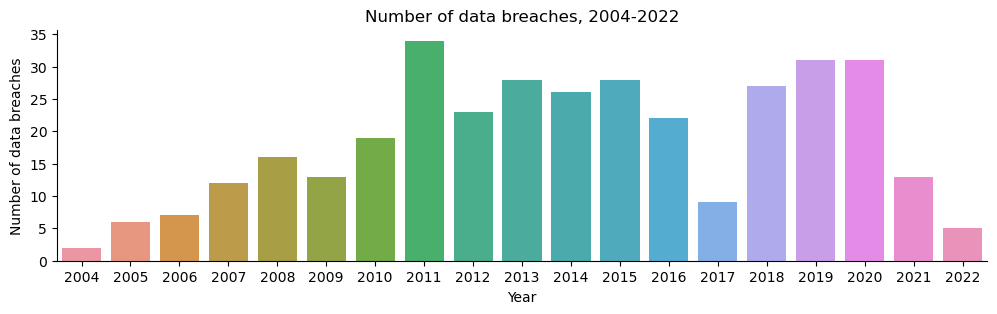

In [1703]:
# Plot: number of data breaches over time
f, ax = plt.subplots(figsize=(12, 3))
sns.despine()
order = [str(year) for year in range(2004, 2023)] 
sns.countplot(x='Year', data=data_breaches, order=order, ax=ax)
ax.set_title('Number of data breaches, 2004-2022')
ax.set_xlabel('Year')
ax.set_ylabel('Number of data breaches')
plt.show()

currently, `Records` and `Year` are strings. we will convert them to numerical below:

In [1704]:
# convert `Records` to numeric, setting non-numeric values to NaN
data_breaches['num_records'] = pd.to_numeric(data_breaches['Records'], errors='coerce')

# convert `Year` to numeric, setting non-numeric values to NaN
data_breaches['num_year'] = pd.to_numeric(data_breaches['Year'], errors='coerce')

# check the converted data types
data_breaches.dtypes

Entity                object
Year                  object
Records               object
Organization type     object
Method                object
Sources               object
num_records          float64
num_year               int64
dtype: object

there are a number of non-numeric values for `Records`. these might still be important since we don't know how they compare to numeric records. we can explore when these non-numeric values occurred by creating a separate dataframe of them.  

In [1705]:
# looking specifically at the records
records_counts = data_breaches.groupby('Records').size().reset_index(name='num_breaches')
records_counts

Records  num_breaches
0             10 locations             1
1            100 terabytes             1
2                   100000             3
3                  1000000             6
4                 10000000             2
..                     ...           ...
250         over 5,000,000             1
251      tens of thousands             1
252            undisclosed             1
253                unknown            21
254  unknown (client list)             1

[255 rows x 2 columns]

use a mask to locate the NaN values of the converted `num_records` and store its corresponding `Records` value in `non_numeric_records`.

In [1706]:
# create a mask for non-numeric values
non_numeric_mask = data_breaches['num_records'].isna()

# create a new column to store non-numeric records
data_breaches['non_numeric_records'] = data_breaches['Records'][non_numeric_mask]


then, create a `non_numeric` dataframe from only non-numeric records

In [1707]:
non_numeric = data_breaches.query("non_numeric_records == non_numeric_records")

Text(0, 0.5, 'Number of breaches with non-numeric records')

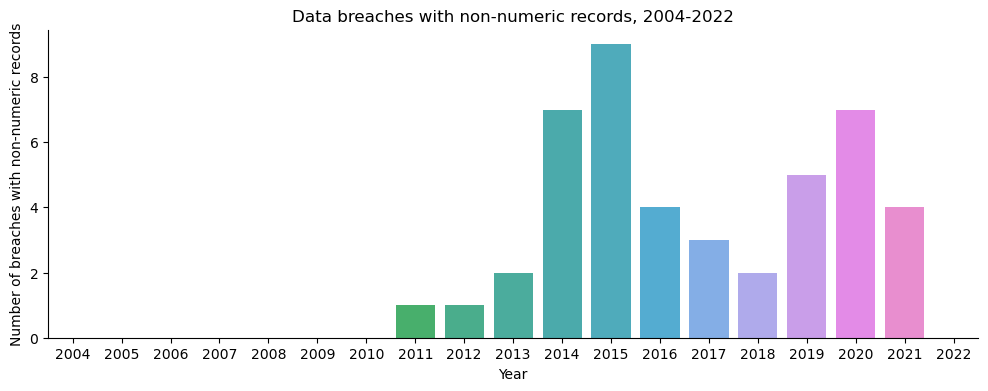

In [1708]:
# Plot: occurrences of non-numeric records in the data
f, ax = plt.subplots(figsize=(12, 4))
sns.despine()
order = [str(year) for year in range(2004, 2023)] 
sns.countplot(x='Year', data=non_numeric, order=order, ax=ax)
ax.set_title('Data breaches with non-numeric records, 2004-2022')
ax.set_xlabel('Year')
ax.set_ylabel('Number of breaches with non-numeric records')

<Axes: >

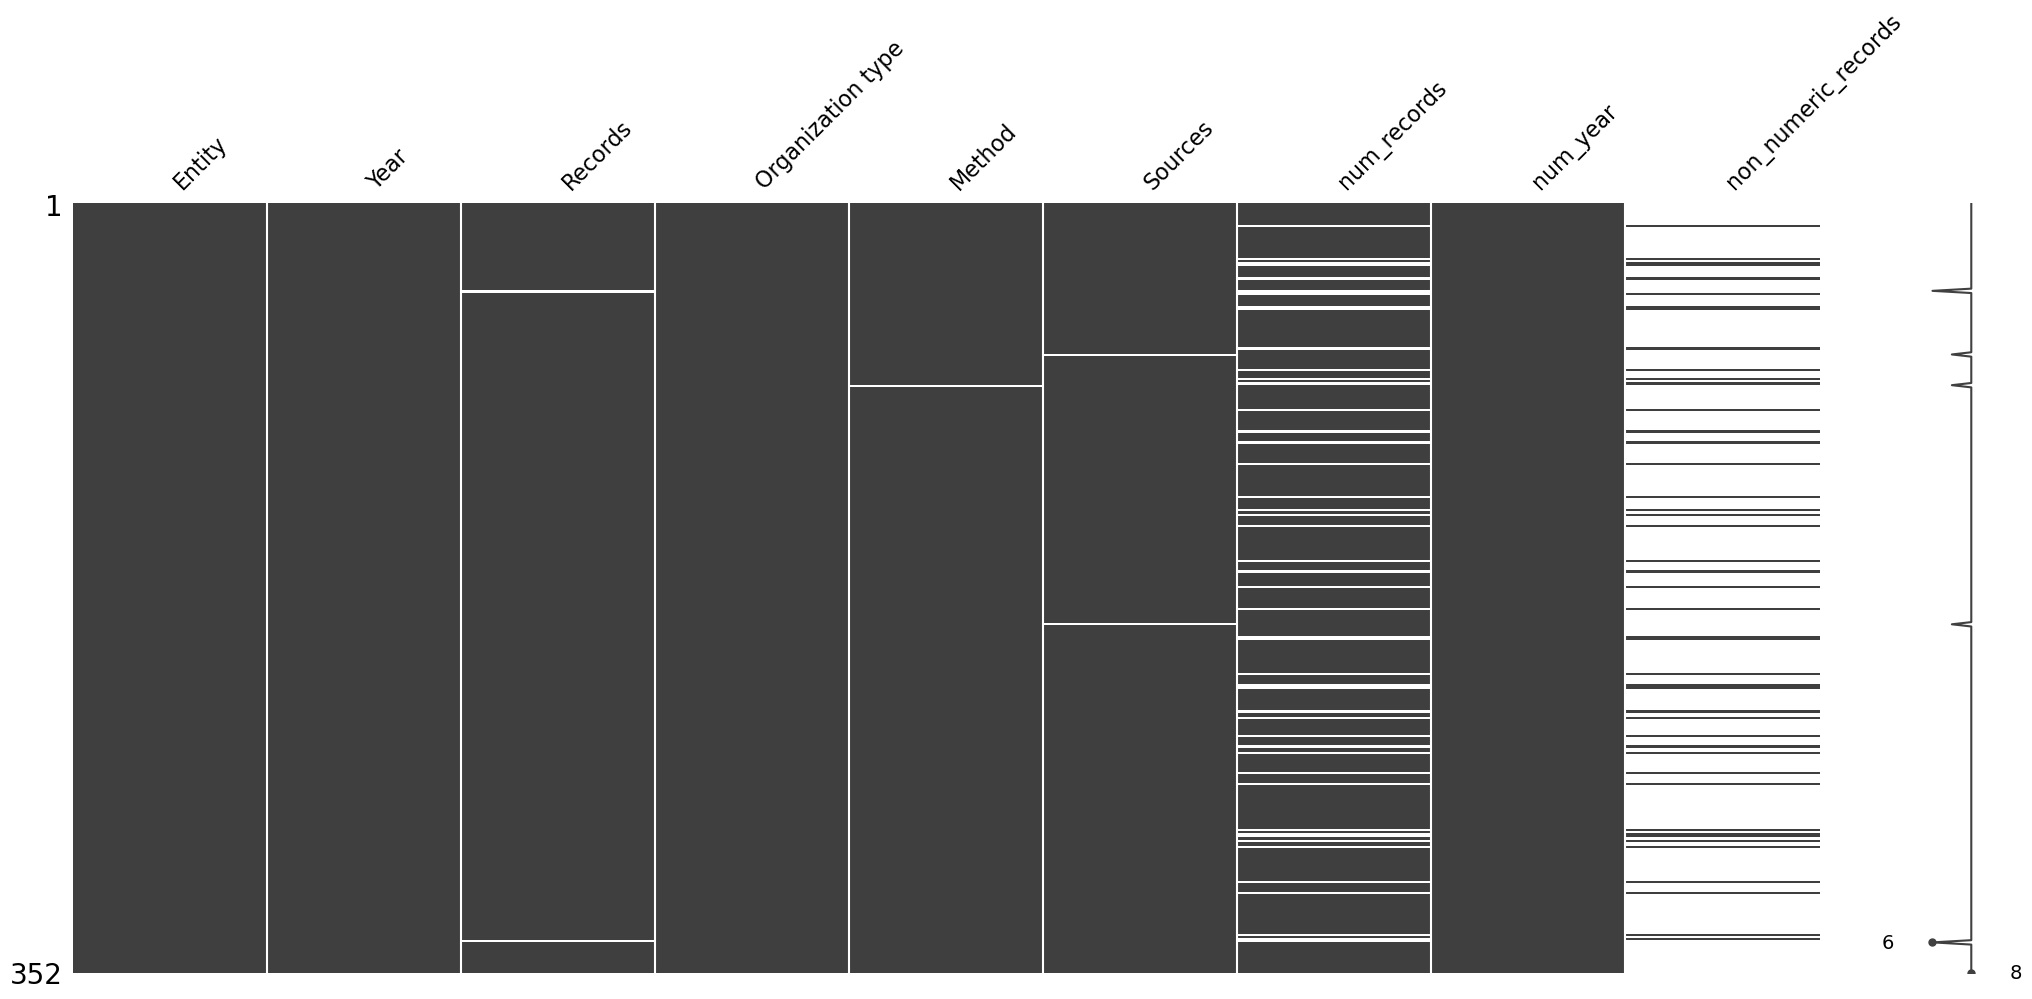

In [1709]:
# visualize the missing values in the `num_records` column
import missingno as msno
msno.matrix(data_breaches)

In [1710]:
# check for missing values
missing_values = data_breaches.isnull().sum()

# calculate missing value counts for those columns where missing values are greater than zero
missing_values_df = pd.DataFrame(missing_values[missing_values > 0], columns=['Count Missing'])

# calculate the percentage of missing values for each column
missing_pct = ((missing_values / data_breaches.shape[0] * 100).round(3))
# add missing count and percent to table
missing_values_df["% Missing"] = missing_pct

# check if there are no missing values, and print a message if that's the case
if missing_values_df.empty:
    print("There are no missing values.")
else:
    # display the table if there are missing values
    display(missing_values_df)

Count Missing  % Missing
Records                          2      0.568
Method                           1      0.284
Sources                          2      0.568
num_records                     47     13.352
non_numeric_records            307     87.216

Now we can look closer at the types of organizations in the data.

In [1711]:
org_counts = data_breaches['Organization type'].value_counts().rename('org_counts')
org_counts

web                           53
healthcare                    47
financial                     38
government                    30
retail                        27
                              ..
humanitarian                   1
special public corporation     1
shopping                       1
local search                   1
various                        1
Name: org_counts, Length: 70, dtype: int64

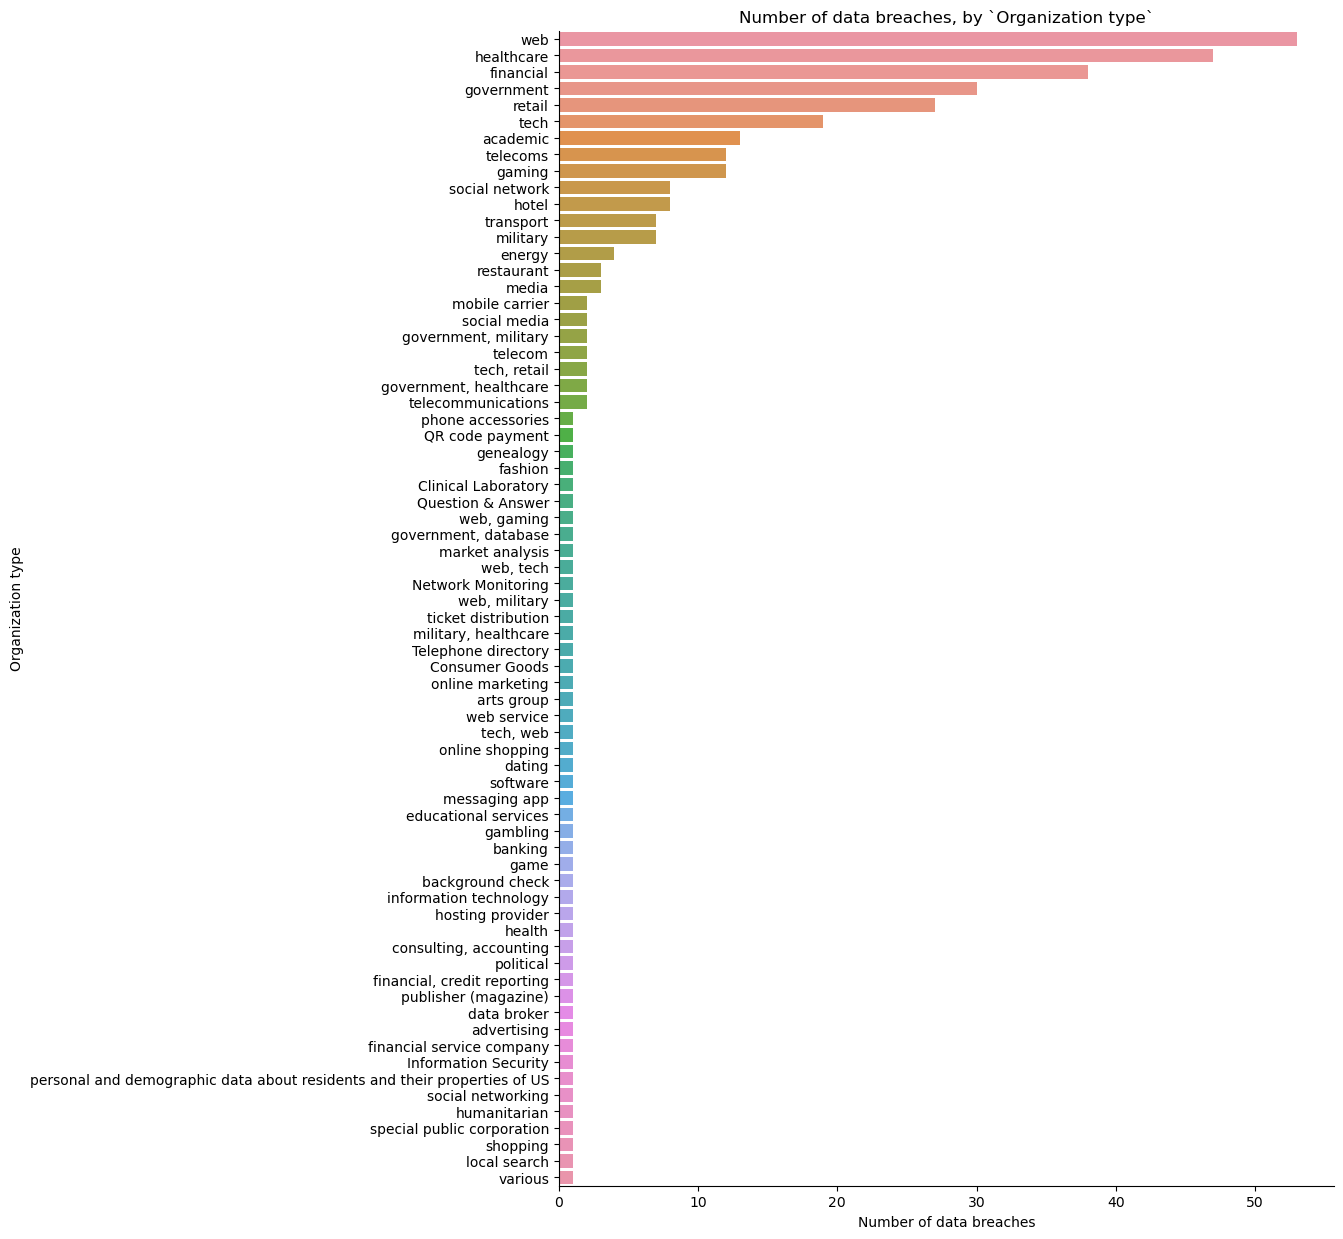

In [1712]:
# Plot: count of data breaches by `Organization type`

org_order = data_breaches['Organization type'].value_counts().index  # specify descending order for the organizations

f, ax = plt.subplots(figsize=(10, 15))
sns.despine()
sns.countplot(y='Organization type', data=data_breaches, order=org_order, ax=ax)
ax.set_title('Number of data breaches, by `Organization type`')
ax.set_xlabel('Number of data breaches')
plt.show()

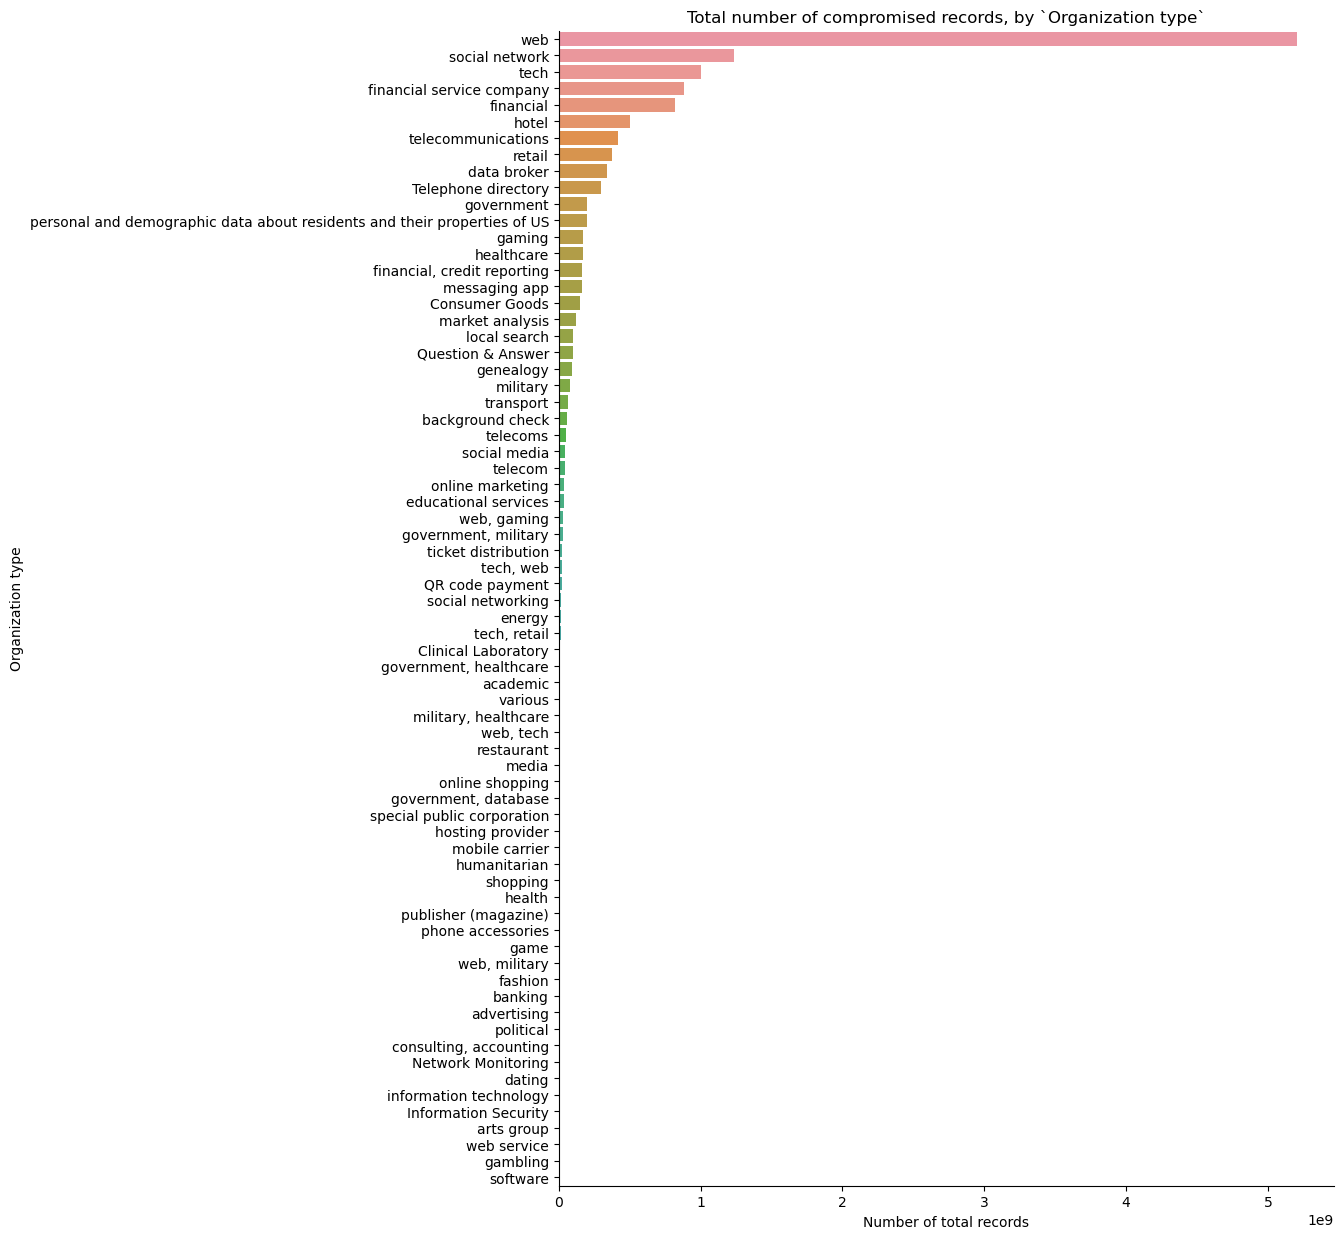

In [1713]:
# Plot: total compromised records for each `Organization type`

# group `Organization type` data by records
org_records = data_breaches.groupby('Organization type', sort=False)["num_records"].sum().reset_index(name ='Total Records') 
org_records_sorted = org_records.sort_values(by='Total Records', ascending=False)  # specify the order of the filtered data

f, ax = plt.subplots(figsize=(10, 15))
sns.despine()
sns.barplot(x='Total Records', y='Organization type', data=org_records_sorted, ax=ax)
ax.set_title('Total number of compromised records, by `Organization type`')
ax.set_xlabel('Number of total records')
plt.show()

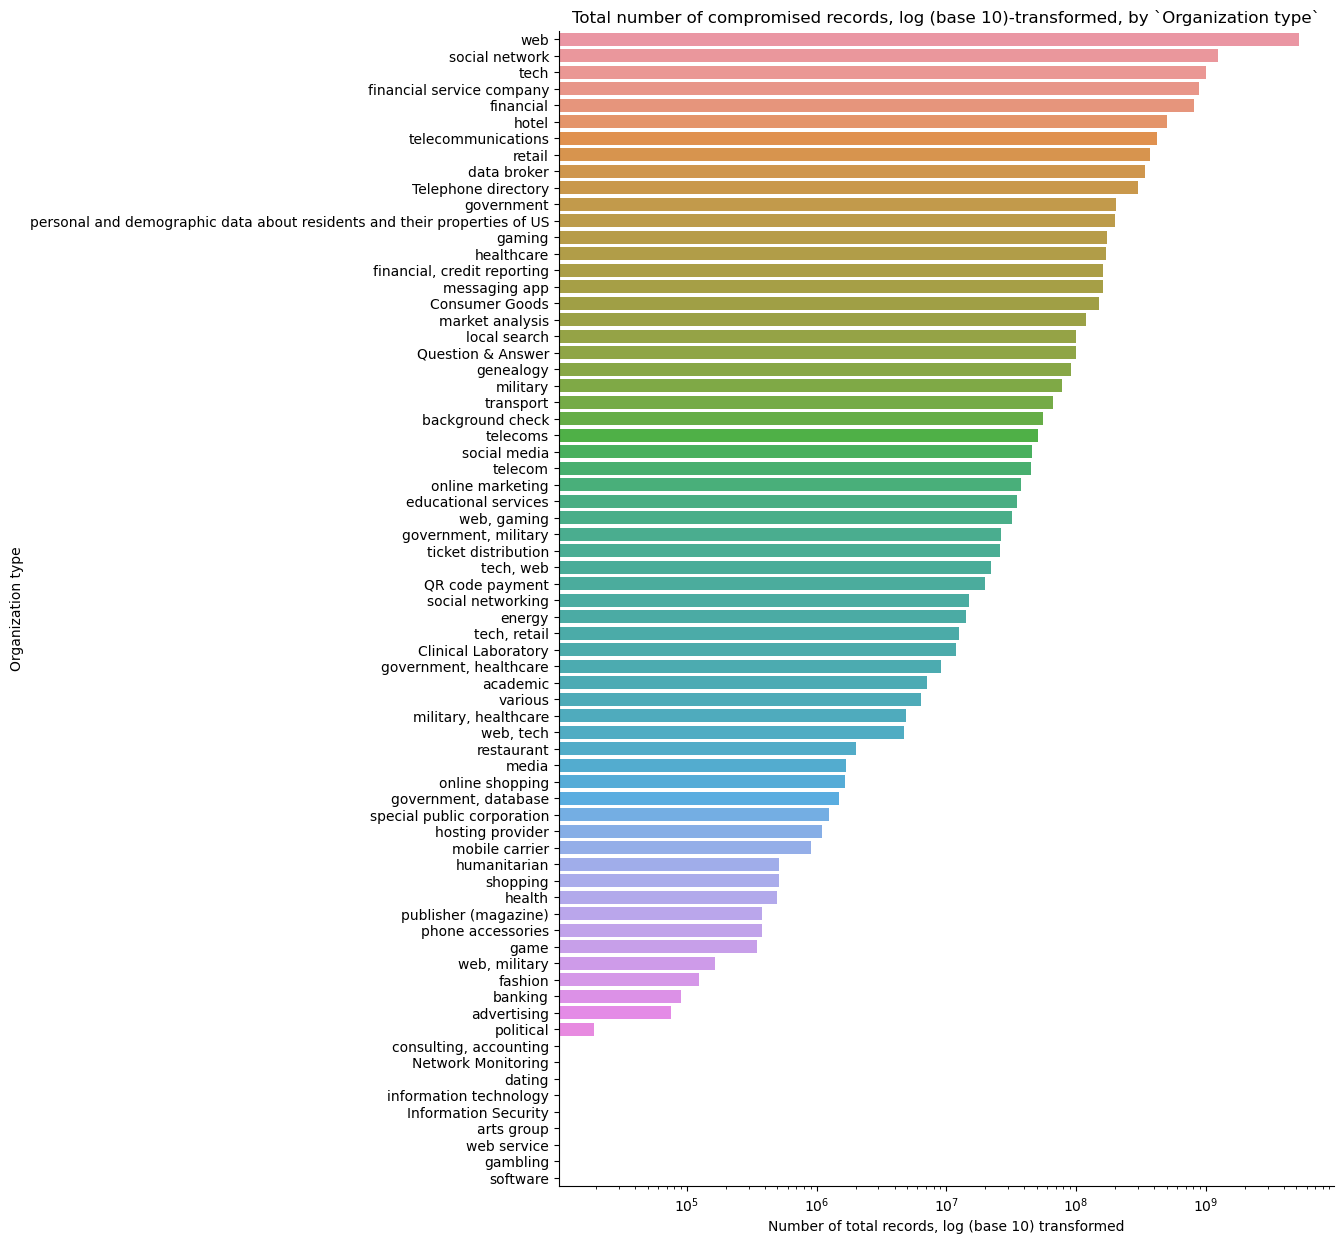

In [1714]:
# Plot: total compromised records for each `Organization type`

# group `Organization type` data by records
org_records = data_breaches.groupby('Organization type', sort=False)["num_records"].sum().reset_index(name ='Total Records') 
org_records_sorted = org_records.sort_values(by='Total Records', ascending=False)  # specify the order of the filtered data

f, ax = plt.subplots(figsize=(10, 15))
sns.despine()
sns.barplot(x='Total Records', y='Organization type', data=org_records_sorted, ax=ax)
ax.set_title('Total number of compromised records, log (base 10)-transformed, by `Organization type`')
ax.set_xlabel('Number of total records, log (base 10) transformed')
ax.set_xscale('log')
plt.show()

it looks like there will be a huge amount of variability in the records. with every data breach, records (`num_records`) as a response variable increases by orders of magnitude. so we can add a new column for its log to help normalize the data. 

In [1715]:
# apply log transformation to `num_records`
data_breaches['ln_num_records'] = np.log(data_breaches['num_records'])
data_breaches['log_num_records'] = np.log10(data_breaches['num_records'])

Below is the breakdown of which types of organizations are affected. 

the left shows which types of organizations most frequently appear in the data. That is, the types of organizations that most frequently experience data breaches.  
The right shows each organization type's total number of records involved in breaches. it has a different scale, but it is in the same order as the left plot, to make it easy to compare.  

what does it show?  
- the combined severity of breaches for each organization type (at least in terms of records) is not necessarily reflected in the frequency of breaches. in other words, some sectors are hit more frequently than others, but many of these breaches are less-severe. 
- at this time, it would be important to consider the 47 non-numerical entries in `Records` to find out if those would change this.  

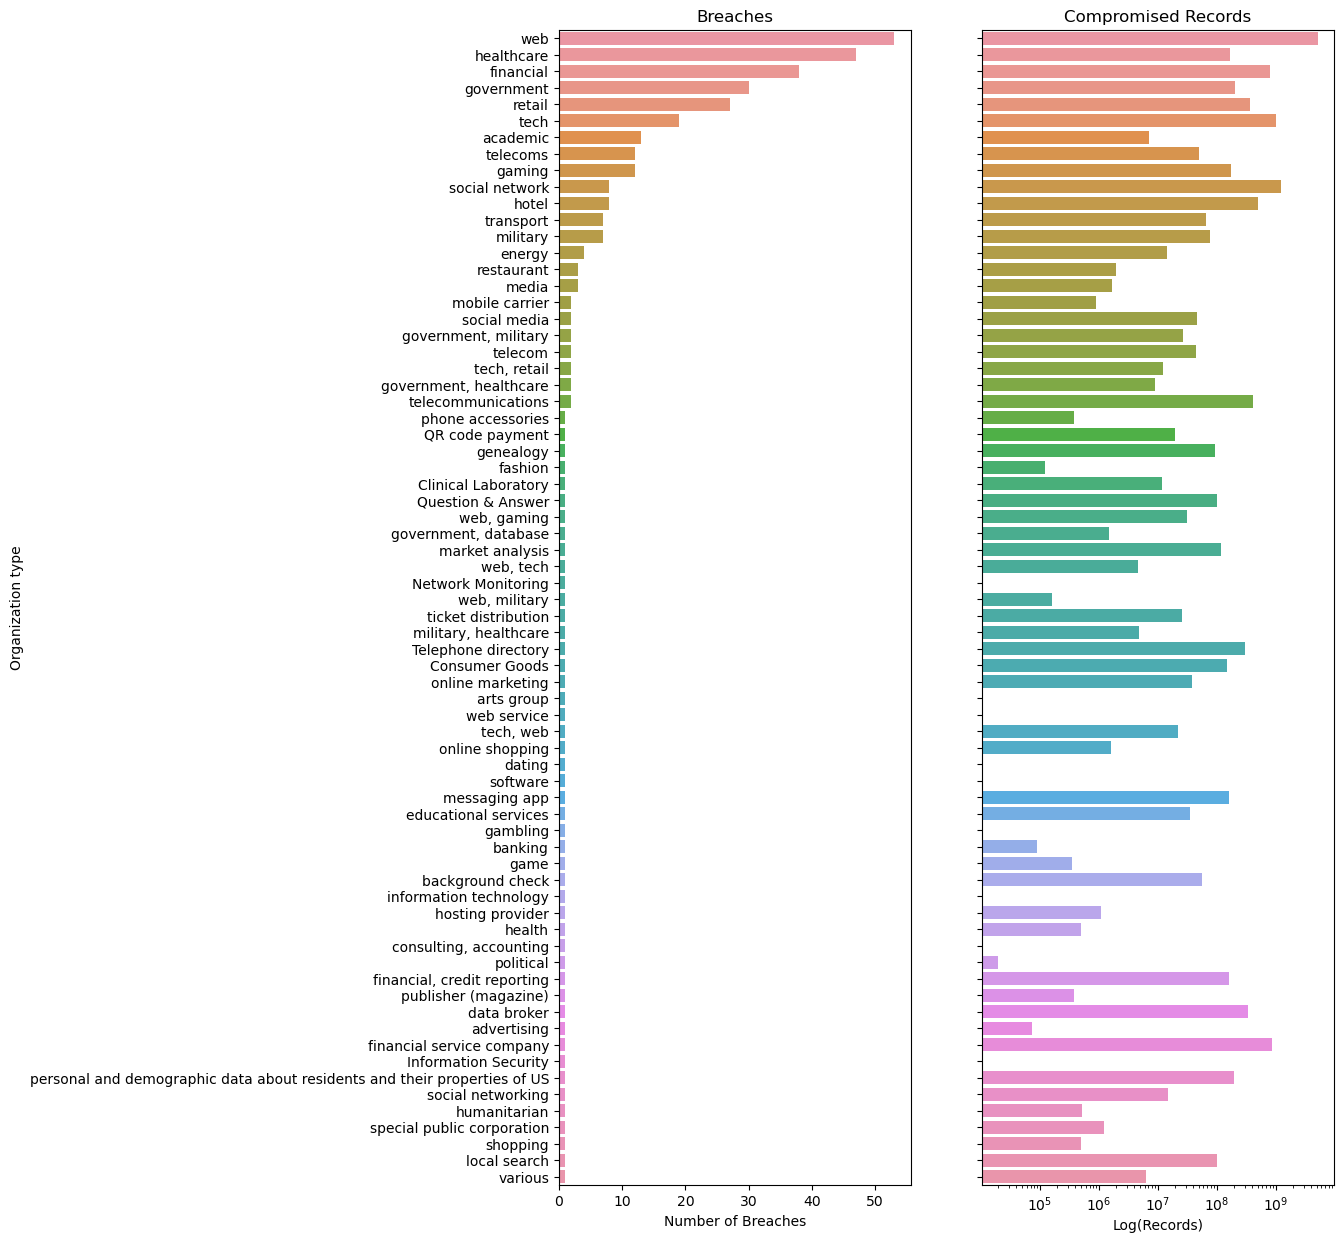

In [1716]:
# Plot: Combined visualization of the breach frequency and the number of records for each `Organization type`

f, ax = plt.subplots(1, 2, figsize=(10, 15))

# subplot for organization type
sns.countplot(y='Organization type', data=data_breaches, order=org_order, ax=ax[0])
ax[0].set_title('Breaches')
ax[0].set_xlabel('Number of Breaches')

# subplot for number of records, sorted by the order of organization frequency in the data for easier comparison
sns.barplot(x='Total Records', y='Organization type', data=org_records_sorted, order=org_order, ax=ax[1])
ax[1].set_xscale('log')  # applies the log transformation
ax[1].set_title('Compromised Records')
ax[1].set_xlabel('Log(Records)')
ax[1].set_ylabel('')

ax[1].set_yticklabels([])  # Remove tick labels (organization names) for records subplot
plt.show()

we can see that there appear to be many similar `Organization type` listings. for instance, `web, tech` and `tech, web` below.  

this is a sign that we could do some additional categorization of the organization types. let's start by creating broad categories. if we want to go even further we can examine the differences within using subcategories.  

In [1717]:
data_breaches.query("`Organization type` == 'web, tech'")

Entity  Year  Records Organization type  Method Sources  num_records  \
247  SnapChat  2013  4700000         web, tech  hacked   [300]    4700000.0   

     num_year non_numeric_records  ln_num_records  log_num_records  
247      2013                 NaN       15.363073         6.672098

In [1718]:
data_breaches.query("`Organization type` == 'tech, web'")

Entity  Year   Records Organization type  Method Sources  \
342  Yahoo Japan  2013  22000000         tech, web  hacked   [402]   

     num_records  num_year non_numeric_records  ln_num_records  \
342   22000000.0      2013                 NaN       16.906553   

     log_num_records  
342         7.342423

In [1719]:
# define function which classifies organizations into broader types
def org_categories(org_type):
    if org_type == 'health' or org_type == 'healthcare' or org_type == 'Clinical Laboratory' or org_type == 'military, healthcare':
        return 'Healthcare/Wellness'
    elif org_type == 'social networking' or org_type == 'social network' or org_type == 'dating' or org_type == 'messaging app' or org_type == 'social media':
        return 'Social Media'
    elif org_type == 'tech' or org_type == 'Information Security' or org_type == 'information technology' or org_type == 'hosting provider' or org_type == 'software' or org_type == 'tech, web' or org_type == 'web, tech' or org_type == 'Network Monitoring' or org_type == 'QR code payment' or org_type == 'local search' or org_type == 'data broker' or org_type == 'market analysis':
        return 'Technology/IT/Analytics'
    elif org_type == 'financial' or org_type == 'financial service company' or org_type == 'financial, credit reporting' or org_type == 'banking' or org_type == 'credit reporting' or org_type == 'consulting, accounting' or org_type == 'background check':
        return 'Financial Services'
    elif org_type == 'retail' or org_type == 'tech, retail' or org_type == 'online shopping' or org_type == 'Consumer Goods' or org_type == 'phone accessories' or org_type == 'shopping' or org_type == 'restaurant':
        return 'Retail/Food'
    elif org_type == 'gaming' or org_type == 'game' or org_type == 'media' or org_type == 'publisher (magazine)' or org_type == 'Question & Answer' or org_type == 'arts group' or org_type == 'fashion' or org_type == 'gambling' or org_type == 'advertising' or org_type == 'online marketing':
        return 'Media/Entertainment/Gaming/Gambling'
    elif org_type == 'telecommunications' or org_type == 'telecoms' or org_type == 'telecom' or org_type == 'mobile carrier' or org_type == 'Telephone directory':
        return 'Telecommunications'
    elif org_type == 'government' or org_type == 'government, healthcare' or org_type == 'government, database' or org_type == 'government, military' or org_type == 'political' or org_type == 'humanitarian':
        return 'Government/Political/Nonprofit'
    elif org_type == 'transport' or org_type == 'hotel' or org_type == 'ticket distribution':
        return 'Transport/Travel'
    elif org_type == 'energy' or org_type == 'military' or org_type == 'web, military' or org_type == 'special public corporation':
        return 'Energy and Infrastructure'
    elif org_type == 'academic' or org_type == 'educational services':
        return 'Education and Academic'
    elif org_type == 'web' or org_type == 'various' or org_type == 'web service' or org_type == 'web, gaming' or org_type == 'genealogy':
        return 'Website/Web Services'
    elif org_type == 'Various':
        return 'Various'
    else:
        return 'Unknown'

# create new column that accepts a value from `Organization type` and applies the classification function
data_breaches['org_categories'] = data_breaches['Organization type'].apply(org_categories)
data_breaches

Entity  Year    Records  \
0                                21st Century Oncology  2016    2200000   
1                                                500px  2020   14870304   
2                                Accendo Insurance Co.  2020     175350   
3                           Adobe Systems Incorporated  2013  152000000   
4                                           Adobe Inc.  2019    7500000   
..                                                 ...   ...        ...   
347                                              Zynga  2019  173000000   
348  Unknown agency(believed to be tied to United S...  2020  200000000   
349  National Health Information Center (NCZI) of S...  2020     391250   
350           50 companies and government institutions  2022    6400000   
351                                               IKEA  2022      95000   

     Organization type                  Method      Sources  num_records  \
0           healthcare                  hacked       [5][6]    2200000.0   
1    social networking                  hacked          [7]   14870304.0   
2           healthcare           poor security       [8][9]     175350.0   
3                 tech                  hacked         [10]  152000000.0   
4                 tech           poor security     [11][12]    7500000.0   
..                 ...                     ...          ...          ...   
347     social network                  hacked   [406][407]  173000000.0   
348          financial  accidentally published        [408]  200000000.0   
349         healthcare           poor security        [409]     391250.0   
350            various           poor security  [410] [411]    6400000.0   
351             retail  accidentally published        [412]      95000.0   

     num_year non_numeric_records  ln_num_records  log_num_records  \
0        2016                 NaN       14.603968         6.342423   
1        2020                 NaN       16.514877         7.172320   
2        2020                 NaN       12.074539         5.243906   
3        2013                 NaN       18.839391         8.181844   
4        2019                 NaN       15.830414         6.875061   
..        ...                 ...             ...              ...   
347      2019                 NaN       18.968802         8.238046   
348      2020                 NaN       19.113828         8.301030   
349      2020                 NaN       12.877102         5.592454   
350      2022                 NaN       15.671809         6.806180   
351      2022                 NaN       11.461632         4.977724   

              org_categories  
0        Healthcare/Wellness  
1               Social Media  
2        Healthcare/Wellness  
3    Technology/IT/Analytics  
4    Technology/IT/Analytics  
..                       ...  
347             Social Media  
348       Financial Services  
349      Healthcare/Wellness  
350     Website/Web Services  
351              Retail/Food  

[352 rows x 12 columns]

In [1720]:
# look at the new organization counts
unspecified_org_counts = data_breaches['org_categories'].value_counts()
unspecified_org_counts

Website/Web Services                   57
Healthcare/Wellness                    50
Financial Services                     43
Government/Political/Nonprofit         37
Retail/Food                            36
Technology/IT/Analytics                30
Media/Entertainment/Gaming/Gambling    23
Telecommunications                     19
Transport/Travel                       16
Education and Academic                 14
Social Media                           13
Energy and Infrastructure              13
Unknown                                 1
Name: org_categories, dtype: int64

In [1721]:
# check that all organizations have been categorized
data_breaches.query("org_categories == 'None'")

Empty DataFrame
Columns: [Entity, Year, Records, Organization type, Method, Sources, num_records, num_year, non_numeric_records, ln_num_records, log_num_records, org_categories]
Index: []

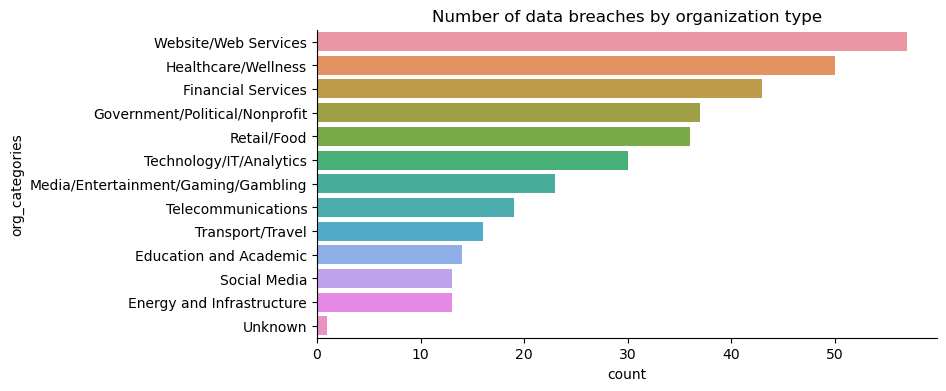

In [1722]:
# Plot: visualize the new organization type categories

org_cat_order = data_breaches['org_categories'].value_counts().index  # specify descending order

f, ax = plt.subplots(figsize=(8, 4))
sns.despine()
sns.countplot(y='org_categories', data=data_breaches, order=org_cat_order, ax=ax)
ax.set_title('Number of data breaches by organization type')
plt.show()

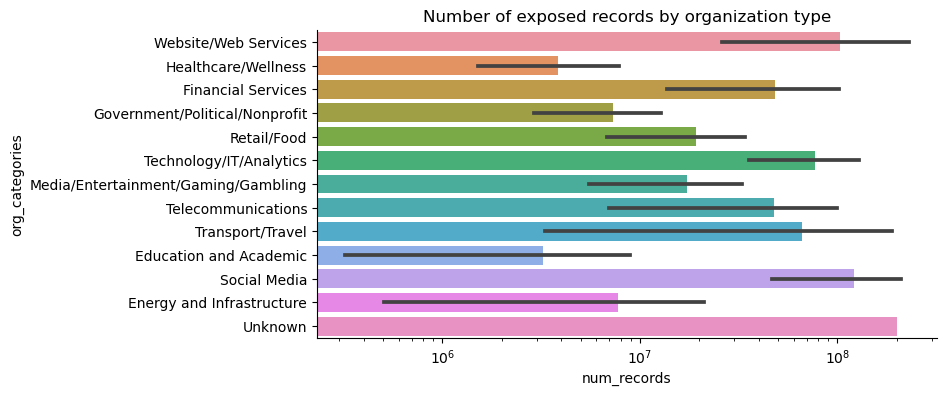

In [1723]:
# Plot: number of exposed records by organization type

org_cat_order = data_breaches['org_categories'].value_counts().index  # specify descending order

f, ax = plt.subplots(figsize=(8, 4))
sns.despine()
sns.barplot(x='num_records', y='org_categories', data=data_breaches, order=org_cat_order, ax=ax)
ax.set_title('Number of exposed records by organization type')
ax.set_xscale('log')
plt.show()

we also see that `Method` could use a similar categorization.  

In [1724]:
method_counts = data_breaches['Method'].value_counts()
method_counts

hacked                                                  192
poor security                                            43
lost / stolen media                                      33
accidentally published                                   21
inside job                                               19
lost / stolen computer                                   16
unknown                                                   7
improper setting, hacked                                  2
poor security/inside job                                  2
intentionally lost                                        1
accidentally exposed                                      1
publicly accessible Amazon Web Services (AWS) server      1
hacked/misconfiguration                                   1
rogue contractor                                          1
ransomware hacked                                         1
misconfiguration/poor security                            1
unprotected api                         

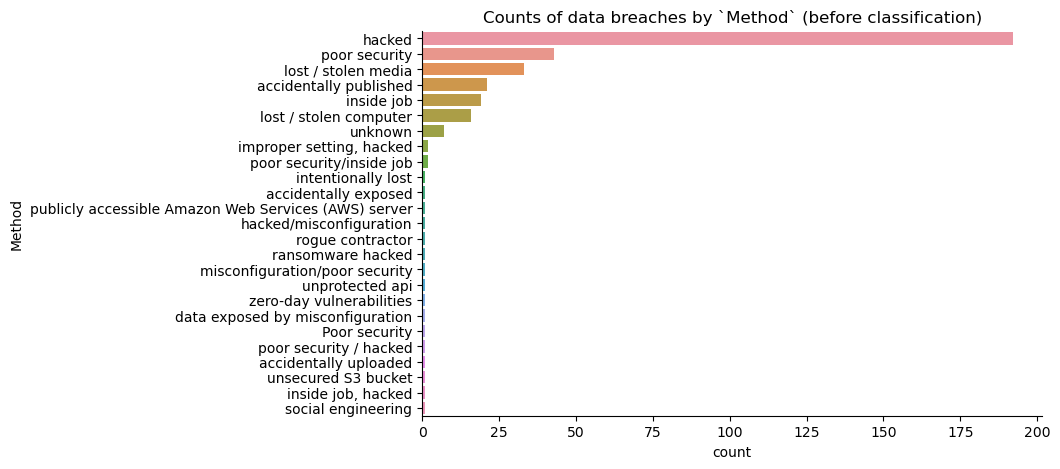

In [1725]:
# Plot: counts of the data breaches by `Method` (before classification)

method_order = data_breaches['Method'].value_counts().index  # specify descending order parameter

# countplot of data breaches by `Method`
f, ax = plt.subplots(figsize=(8, 5))
sns.despine()
sns.countplot(y='Method', data=data_breaches, order=method_order, ax=ax)
ax.set_title('Counts of data breaches by `Method` (before classification)')
plt.show()

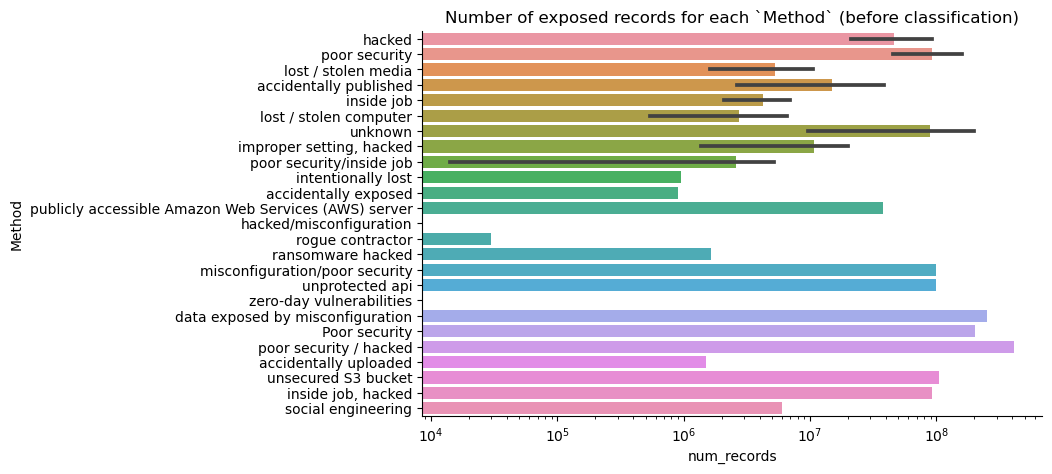

In [1726]:
# Plot: number of records exposed by each `Method` (before classification)

method_order = data_breaches['Method'].value_counts().index  # specify descending order parameter

# bar plot of records exposed by `Method`
f, ax = plt.subplots(figsize=(8, 5))
sns.despine()
sns.barplot(x='num_records', y='Method', data=data_breaches, order=method_order, ax=ax)
ax.set_title('Number of exposed records for each `Method` (before classification)')
ax.set_xscale('log')
plt.show()

In [1877]:
# Sort the DataFrame based on the 'Records' column in descending order
sorted_df = data_breaches.sort_values(by='num_records', ascending=False)

# Select the top 20 entities with the highest records
top_entities_records = sorted_df.head(20)

In [1873]:
yahoo = data_breaches.query("Entity == 'Yahoo'")

In [1875]:
data_breaches.query("Entity == 'First American Corporation'")

Entity  Year    Records          Organization type  \
118  First American Corporation  2019  885000000  financial service company   

            Method Sources  num_records  num_year non_numeric_records  \
118  poor security   [153]  885000000.0      2019                 NaN   

     ln_num_records  log_num_records      org_categories  \
118       20.601098         8.946943  Financial Services   

           method_categories       hacked  
118  Poor Security Practices  Non-Hacking

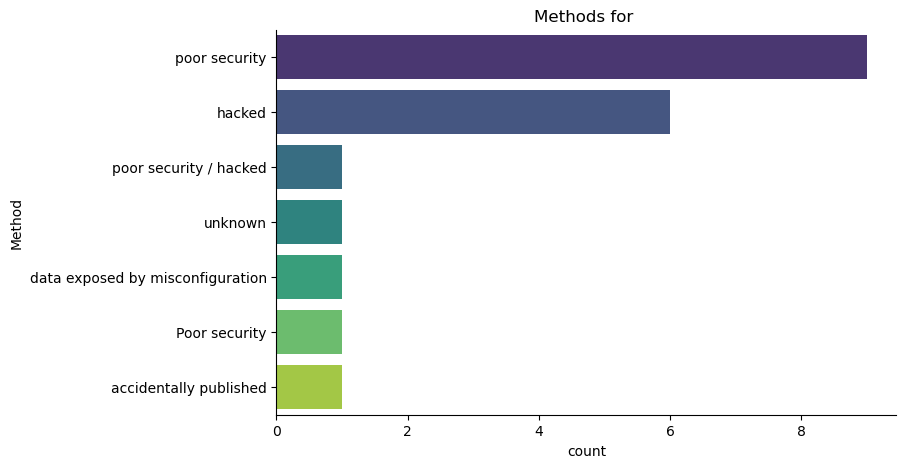

In [1883]:
# Plot: number of records exposed by each `Method` (before classification)

top_entities_method_order = top_entities_records['Method'].value_counts().index  # specify descending order parameter

# bar plot of records exposed by `Method`
f, ax = plt.subplots(figsize=(8, 5))
sns.despine()
sns.countplot(y='Method', data=top_entities_records, order=top_entities_method_order, palette='viridis', ax=ax)
ax.set_title('Methods for ')
plt.show()

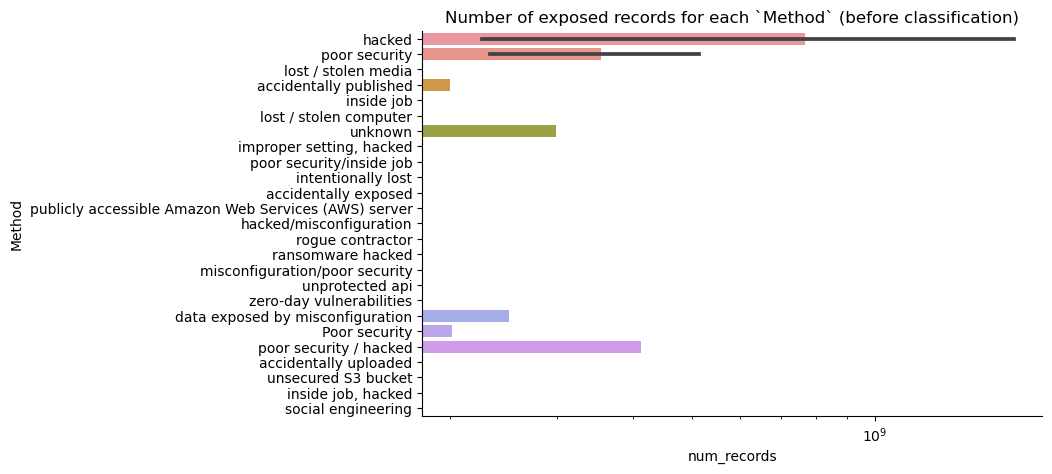

In [1878]:
# Plot: number of records exposed by each `Method` (before classification)

method_order = data_breaches['Method'].value_counts().index  # specify descending order parameter

# bar plot of records exposed by `Method`
f, ax = plt.subplots(figsize=(8, 5))
sns.despine()
sns.barplot(x='num_records', y='Method', data=top_entities_records, order=method_order, ax=ax)
ax.set_title('Number of exposed records for each `Method` (before classification)')
ax.set_xscale('log')
plt.show()

In [1727]:
# define function which classifies methods into broader types
def method_categories(method):
    if method == 'hacked' or method == 'inside job, hacked' or method == 'poor security/hacked' or method == 'poor security / hacked' or method == 'ransomware hacked' or method == 'improper setting, hacked' or method == 'hacked/misconfiguration' or method == 'zero-day vulnerabilities':
        return 'Hacking/Cyberattacks'
    elif method == 'poor security' or method == 'Poor security' or method == 'unsecured S3 bucket' or method == 'unprotected api' or method == 'poor security/inside job' or method == 'misconfiguration/poor security':
        return 'Poor Security Practices'
    elif method == 'accidentally published' or method == 'accidentally uploaded' or method == 'accidentally exposed':
        return 'Accidental Exposure'
    elif method == 'lost/stolen media' or method == 'lost / stolen media' or method == 'lost/stolen computer' or method == 'lost / stolen computer' or method == 'intentionally lost':
        return 'Physical Loss/Theft'
    elif method == 'inside job' or method == 'rogue contractor':
        return 'Insider Threats'
    elif method == 'data exposed by misconfiguration' or method == 'publicly accessible Amazon Web Services (AWS) server':
        return 'Technical Misconfigurations'
    elif method == 'social engineering':
        return 'Social Engineering'
    elif method == 'unknown':
        return 'Unknown/Unspecified'
    else:
        return 'None'

# create new column that accepts a value from `Method` and applies classification function, storing value in new column
data_breaches['method_categories'] = data_breaches['Method'].apply(method_categories)
data_breaches

Entity  Year    Records  \
0                                21st Century Oncology  2016    2200000   
1                                                500px  2020   14870304   
2                                Accendo Insurance Co.  2020     175350   
3                           Adobe Systems Incorporated  2013  152000000   
4                                           Adobe Inc.  2019    7500000   
..                                                 ...   ...        ...   
347                                              Zynga  2019  173000000   
348  Unknown agency(believed to be tied to United S...  2020  200000000   
349  National Health Information Center (NCZI) of S...  2020     391250   
350           50 companies and government institutions  2022    6400000   
351                                               IKEA  2022      95000   

     Organization type                  Method      Sources  num_records  \
0           healthcare                  hacked       [5][6]    2200000.0   
1    social networking                  hacked          [7]   14870304.0   
2           healthcare           poor security       [8][9]     175350.0   
3                 tech                  hacked         [10]  152000000.0   
4                 tech           poor security     [11][12]    7500000.0   
..                 ...                     ...          ...          ...   
347     social network                  hacked   [406][407]  173000000.0   
348          financial  accidentally published        [408]  200000000.0   
349         healthcare           poor security        [409]     391250.0   
350            various           poor security  [410] [411]    6400000.0   
351             retail  accidentally published        [412]      95000.0   

     num_year non_numeric_records  ln_num_records  log_num_records  \
0        2016                 NaN       14.603968         6.342423   
1        2020                 NaN       16.514877         7.172320   
2        2020                 NaN       12.074539         5.243906   
3        2013                 NaN       18.839391         8.181844   
4        2019                 NaN       15.830414         6.875061   
..        ...                 ...             ...              ...   
347      2019                 NaN       18.968802         8.238046   
348      2020                 NaN       19.113828         8.301030   
349      2020                 NaN       12.877102         5.592454   
350      2022                 NaN       15.671809         6.806180   
351      2022                 NaN       11.461632         4.977724   

              org_categories        method_categories  
0        Healthcare/Wellness     Hacking/Cyberattacks  
1               Social Media     Hacking/Cyberattacks  
2        Healthcare/Wellness  Poor Security Practices  
3    Technology/IT/Analytics     Hacking/Cyberattacks  
4    Technology/IT/Analytics  Poor Security Practices  
..                       ...                      ...  
347             Social Media     Hacking/Cyberattacks  
348       Financial Services      Accidental Exposure  
349      Healthcare/Wellness  Poor Security Practices  
350     Website/Web Services  Poor Security Practices  
351              Retail/Food      Accidental Exposure  

[352 rows x 13 columns]

Now that we've categorized organizations and methods more cleanly, we can visualize which methods are most common for different sectors. 


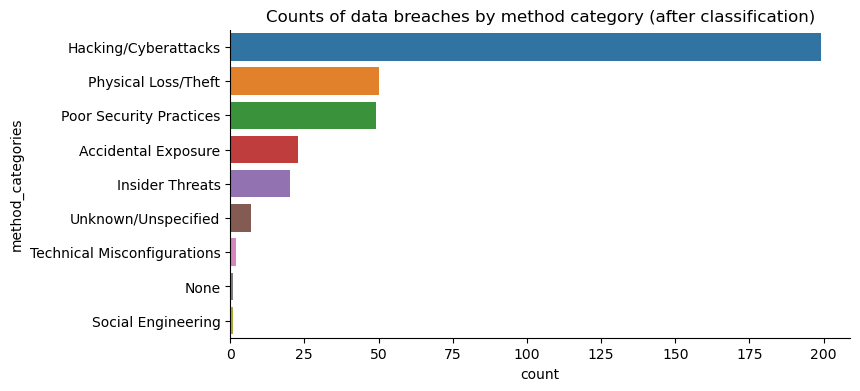

In [1728]:
# Plot: counts of the data breaches by method category (after classification)

method_cat_order = data_breaches['method_categories'].value_counts().index  # specify descending order parameter

# countplot of data breaches by method category
f, ax = plt.subplots(figsize=(8, 4))
sns.despine()
sns.countplot(y='method_categories', data=data_breaches, order=method_cat_order, ax=ax)
ax.set_title('Counts of data breaches by method category (after classification)')
plt.show()

/Users/mollyscally/anaconda3/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


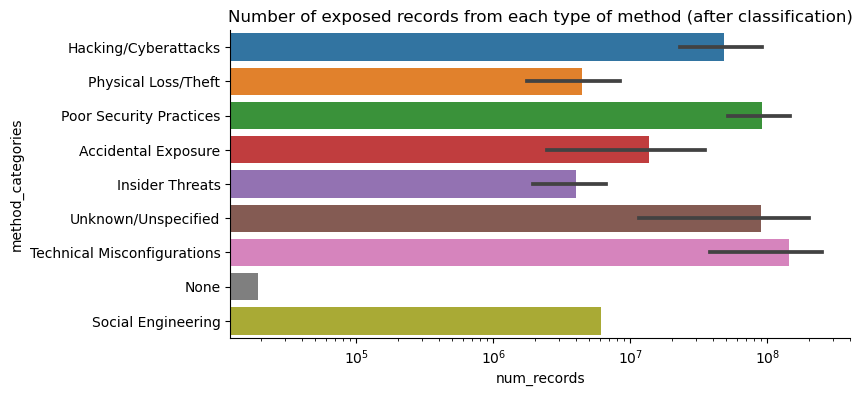

In [1729]:
# Plot: number of records exposed by each method category (after classification)

method_cat_order = data_breaches['method_categories'].value_counts().index  # specify descending order parameter

# bar plot of records exposed by method category
f, ax = plt.subplots(figsize=(8, 4))
sns.despine()
sns.barplot(x='num_records', y='method_categories', data=data_breaches, order=method_cat_order, ax=ax)
ax.set_title('Number of exposed records from each type of method (after classification)')
ax.set_xscale('log')
plt.show()

to create a comprehensive plot of the representation of different organization and method categories in the data, we can create dataframes for each of the different organization categories. that way, it will be much easier to explore them individually.  

we will also create a 'clean' version of each. for consistency, we will use these ones for modeling.  

In [1730]:
# use queries to create dataframes for each method category type
# then, create 'cleaned' version by dropping NaNs in `num_records`
web = data_breaches.query("`org_categories` == 'Website/Web Services'")
web_cleaned = web.dropna(subset=['num_records'])

healthcare = data_breaches.query("`org_categories` == 'Healthcare/Wellness'")
healthcare_cleaned = healthcare.dropna(subset=['num_records'])

financial = data_breaches.query("`org_categories` == 'Financial Services'")
financial_cleaned = financial.dropna(subset=['num_records'])

government = data_breaches.query("`org_categories` == 'Government/Political/Nonprofit'")
government_cleaned = government.dropna(subset=['num_records'])

retail = data_breaches.query("`org_categories` == 'Retail/Food'")
retail_cleaned = retail.dropna(subset=['num_records'])

tech = data_breaches.query("`org_categories` == 'Technology/IT/Analytics'")
tech_cleaned = tech.dropna(subset=['num_records'])

media = data_breaches.query("`org_categories` == 'Media/Entertainment/Gaming/Gambling'")
media_cleaned = media.dropna(subset=['num_records'])

telecommunications = data_breaches.query("`org_categories` == 'Telecommunications'")
telecommunications_cleaned = telecommunications.dropna(subset=['num_records'])

transport = data_breaches.query("`org_categories` == 'Transport/Travel'")
transport_cleaned = transport.dropna(subset=['num_records'])

education = data_breaches.query("`org_categories` == 'Education and Academic'")
education_cleaned = education.dropna(subset=['num_records'])

social = data_breaches.query("`org_categories` == 'Social Media'")
social_cleaned = social.dropna(subset=['num_records'])

energy = data_breaches.query("`org_categories` == 'Energy and Infrastructure'")
energy_cleaned = energy.dropna(subset=['num_records'])

unknown = data_breaches.query("`org_categories` == 'Unknown'")
unknown_cleaned = unknown.dropna(subset=['num_records'])

# also createa a "cleaned" version of the overall data here
cleaned_data_all = data_breaches.dropna(subset=['num_records'])

now we can plot each of the organization types as a subplot of a larger plot to compare the counts of the different types of methods most frequently applied to each sector. 

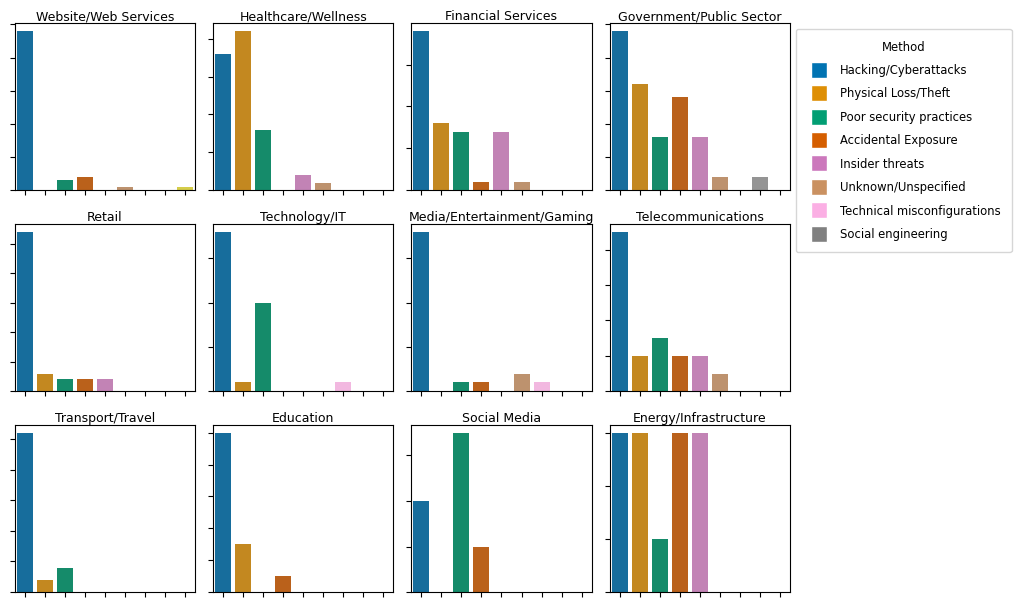

In [1731]:
# Plot: frequency of data breach methods (count bars/legend) by organization type (subplots)

import matplotlib.gridspec as gridspec  # import necessary library for customizing subplot grid layout

f = plt.figure(figsize=(10, 10))  # set up overall figure
gs = gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1])  # 1 row, 2 columns

method_cat_order = data_breaches['method_categories'].value_counts().index  # specify a uniform order for all subplots

palette = sns.color_palette("colorblind", 25)  # specify a color palette 

ax1 = plt.subplot(gs[0,0])  # subplot for `web` organization category
sns.countplot(x='method_categories', data=web, order=method_cat_order, palette=palette, ax=ax1)
ax1.set_title('Website/Web Services', fontsize=9, y=0.97)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xticklabels([]) # remove tick labels
ax1.set_yticklabels([]) # remove tick labels

ax01 = plt.subplot(gs[0,1])  # subplot for `healthcare` organization category
sns.countplot(x='method_categories', data=healthcare, order=method_cat_order, palette=palette,  ax=ax01)
ax01.set_title('Healthcare/Wellness', fontsize=9, y=0.97)
ax01.set_xlabel('')
ax01.set_ylabel('')
ax01.set_xticklabels([]) # remove tick labels
ax01.set_yticklabels([]) # remove tick labels

ax02 = plt.subplot(gs[0,2])  # subplot for `finanical` organization category
sns.countplot(x='method_categories', data=financial, order=method_cat_order, palette=palette,  ax=ax02)
ax02.set_title('Financial Services', fontsize=9, y=0.97)
ax02.set_xlabel('')
ax02.set_ylabel('')
ax02.set_xticklabels([]) # remove tick labels
ax02.set_yticklabels([]) # remove tick labels

ax10 = plt.subplot(gs[0,3])  # subplot for `government` organization category
sns.countplot(x='method_categories', data=government, order=method_cat_order, palette=palette,  ax=ax10)
ax10.set_title('Government/Public Sector', fontsize=9, y=0.97)
ax10.set_xlabel('')
ax10.set_ylabel('')
ax10.set_xticklabels([]) # remove tick labels
ax10.set_yticklabels([]) # remove tick labels

ax11 = plt.subplot(gs[1,0])  # subplot for `retail` organization category
sns.countplot(x='method_categories', data=retail, order=method_cat_order, palette=palette,  ax=ax11)
ax11.set_title('Retail', fontsize=9, y=0.97)
ax11.set_xlabel('')
ax11.set_ylabel('')
ax11.set_xticklabels([]) # remove tick labels
ax11.set_yticklabels([]) # remove tick labels

ax12 = plt.subplot(gs[1,1])  # subplot for `tech` organization category
sns.countplot(x='method_categories', data=tech, order=method_cat_order, palette=palette,  ax=ax12)
ax12.set_title('Technology/IT', fontsize=9, y=0.97)
ax12.set_xlabel('')
ax12.set_ylabel('')
ax12.set_xticklabels([]) # remove tick labels
ax12.set_yticklabels([]) # remove tick labels

ax20 = plt.subplot(gs[1,2])  # subplot for `media` organization category
sns.countplot(x='method_categories', data=media, order=method_cat_order, palette=palette,  ax=ax20)
ax20.set_title('Media/Entertainment/Gaming', fontsize=9, y=0.97)
ax20.set_xlabel('')
ax20.set_ylabel('')
ax20.set_xticklabels([]) # remove tick labels
ax20.set_yticklabels([]) # remove tick labels

ax21 = plt.subplot(gs[1,3])  # subplot for `telecommunications` organization category
sns.countplot(x='method_categories', data=telecommunications, order=method_cat_order, palette=palette,  ax=ax21)
ax21.set_title('Telecommunications', fontsize=9, y=0.97)
ax21.set_xlabel('')
ax21.set_ylabel('')
ax21.set_xticklabels([]) # remove tick labels
ax21.set_yticklabels([]) # remove tick labels

ax22 = plt.subplot(gs[2,0])  # subplot for `transport` organization category
sns.countplot(x='method_categories', data=transport, order=method_cat_order, palette=palette,  ax=ax22)
ax22.set_title('Transport/Travel', fontsize=9, y=0.97)
ax22.set_xlabel('')
ax22.set_ylabel('')
ax22.set_xticklabels([]) # remove tick labels
ax22.set_yticklabels([]) # remove tick labels

ax30 = plt.subplot(gs[2,1])  # subplot for `education` organization category
sns.countplot(x='method_categories', data=education, order=method_cat_order, palette=palette, ax=ax30)
ax30.set_title('Education', fontsize=9, y=0.97)
ax30.set_xlabel('')
ax30.set_ylabel('')
ax30.set_xticklabels([]) # remove tick labels
ax30.set_yticklabels([]) # remove tick labels

ax31 = plt.subplot(gs[2,2])  # subplot for `social` organization category
sns.countplot(x='method_categories', data=social, order=method_cat_order, palette=palette,  ax=ax31)
ax31.set_title('Social Media', fontsize=9, y=0.97)
ax31.set_xlabel('')
ax31.set_ylabel('')
ax31.set_xticklabels([]) # remove tick labels
ax31.set_yticklabels([]) # remove tick labels

ax32 = plt.subplot(gs[2,3])  # subplot for `energy` organization category
sns.countplot(x='method_categories', data=energy, order=method_cat_order,  palette=palette, ax=ax32)
ax32.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
ax32.set_xlabel('')
ax32.set_ylabel('')
ax32.set_xticklabels([]) # remove tick labels
ax32.set_yticklabels([]) # remove tick labels

# using `palette` defined above, define individual colors to use in the legend
first_color = palette[0]
second_color = palette[1]
third_color = palette[2]
fourth_color = palette[3]
fifth_color = palette[4]
sixth_color = palette[5]
seventh_color = palette[6]
eighth_color = palette[8]

# create a custom legend so the countplots do not need labels
legend_labels=['Hacking/Cyberattacks', 'Physical Loss/Theft', 'Poor security practices', 'Accidental Exposure', 'Insider threats', 'Unknown/Unspecified', 'Technical misconfigurations', 'Social engineering']
legend_colors=[first_color, second_color, third_color, fourth_color, fifth_color, sixth_color, seventh_color, 'gray']
legend_handles = [plt.Line2D([0], [0], marker='s', color='White', label=label, 
                             markersize=11, markerfacecolor=color, linestyle='None') 
                  for label, color in zip(legend_labels, legend_colors)]
ax10.legend(loc='upper left',  bbox_to_anchor=(1,1), handles=legend_handles, title='Method', fontsize='small', title_fontsize='small', labelspacing=0.9, borderpad=1, facecolor='white')

gs.update(hspace=0.2, wspace=0.1)  # adjust spacing between subplots: hspace for horizontal, wspace for vertical

plt.show()

as expected, `hacking` appears most frequently for all organization types. if we temporarily remove it from the visualization, we can examine the other types of methods without distraction:

In [1732]:
# create new column that classifies `Method` by hacking vs not-hacking incidents
def hacked(method_category):
    if method_category == 'Hacking/Cyberattacks':
        return 'Hacking'
    else:
        return 'Non-Hacking'

data_breaches['hacked'] = data_breaches['method_categories'].apply(hacked)

In [1733]:
hacked = data_breaches.query("org_categories == 'Hacked/Cyberattacks'")
not_hacked = data_breaches.query("org_categories != 'Hacked/Cyberattacks'")

In [1734]:
# get the resulting counts of the classification
hacked_counts = data_breaches['hacked'].value_counts()
hacked_counts

Hacking        199
Non-Hacking    153
Name: hacked, dtype: int64

In [1735]:
# same as before, use queries to create dataframes for each method category type
web_not_hacking = data_breaches.query("(`org_categories` == 'Website/Web Services') & (method_categories != 'Hacking/Cyberattacks')")
healthcare_not_hacking = data_breaches.query("(`org_categories` == 'Healthcare/Wellness') & (method_categories != 'Hacking/Cyberattacks')")
financial_not_hacking = data_breaches.query("(`org_categories` == 'Financial Services') & (method_categories != 'Hacking/Cyberattacks')")
government_not_hacking = data_breaches.query("(`org_categories` == 'Government/Political/Nonprofit') & (method_categories != 'Hacking/Cyberattacks')")
retail_not_hacking = data_breaches.query("(`org_categories` == 'Retail/Food') & (method_categories != 'Hacking/Cyberattacks')")
tech_not_hacking = data_breaches.query("(`org_categories` == 'Technology/IT/Analytics') & (method_categories != 'Hacking/Cyberattacks')")
media_not_hacking = data_breaches.query("(`org_categories` == 'Media/Entertainment/Gaming/Gambling') & (method_categories != 'Hacking/Cyberattacks')")
telecommunications_not_hacking = data_breaches.query("(`org_categories` == 'Telecommunications') & (method_categories != 'Hacking/Cyberattacks')")
transport_not_hacking = data_breaches.query("(`org_categories` == 'Transport/Travel') & (method_categories != 'Hacking/Cyberattacks')")
education_not_hacking = data_breaches.query("(`org_categories` == 'Education and Academic') & (method_categories != 'Hacking/Cyberattacks')")
social_not_hacking = data_breaches.query("(`org_categories` == 'Social Media') & (method_categories != 'Hacking/Cyberattacks')")
energy_not_hacking = data_breaches.query("(`org_categories` == 'Energy and Infrastructure') & (method_categories != 'Hacking/Cyberattacks')")
unknown_not_hacking = data_breaches.query("(`org_categories` == 'Unknown') & (method_categories != 'Hacking/Cyberattacks')")

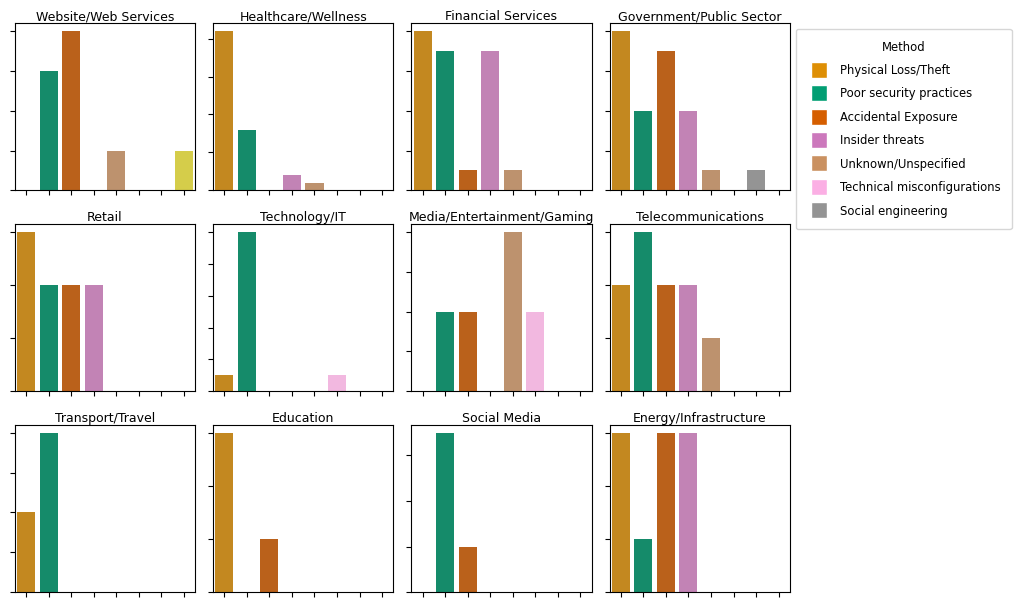

In [1736]:
# Plot: frequency of data breach methods BESIDES hacking (count bars/legend) by organization type (subplots)

import matplotlib.gridspec as gridspec  # import necessary library for customizing subplot grid layout

f = plt.figure(figsize=(10, 10))  # set up overall figure
gs = gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1])  # 1 row, 2 columns

method_not_hacking_cat_order = data_breaches_not_hacking['method_categories'].value_counts().index  # specify a uniform order for all subplots

palette = sns.color_palette("colorblind", 25)[1:]  # specify a color palette (start 1 up from normal so you keep colors same as before)

ax1 = plt.subplot(gs[0,0])  # subplot for `web` organization category
sns.countplot(x='method_categories', data=web_not_hacking, order=method_not_hacking_cat_order, palette=palette, ax=ax1)
ax1.set_title('Website/Web Services', fontsize=9, y=0.97)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xticklabels([]) # remove tick labels
ax1.set_yticklabels([]) # remove tick labels

ax01 = plt.subplot(gs[0,1])  # subplot for `healthcare` organization category
sns.countplot(x='method_categories', data=healthcare_not_hacking, order=method_not_hacking_cat_order, palette=palette,  ax=ax01)
ax01.set_title('Healthcare/Wellness', fontsize=9, y=0.97)
ax01.set_xlabel('')
ax01.set_ylabel('')
ax01.set_xticklabels([]) # remove tick labels
ax01.set_yticklabels([]) # remove tick labels

ax02 = plt.subplot(gs[0,2])  # subplot for `financial` organization category
sns.countplot(x='method_categories', data=financial_not_hacking, order=method_not_hacking_cat_order, palette=palette,  ax=ax02)
ax02.set_title('Financial Services', fontsize=9, y=0.97)
ax02.set_xlabel('')
ax02.set_ylabel('')
ax02.set_xticklabels([]) # remove tick labels
ax02.set_yticklabels([]) # remove tick labels

ax10 = plt.subplot(gs[0,3])  # subplot for `government` organization category
sns.countplot(x='method_categories', data=government_not_hacking, order=method_not_hacking_cat_order, palette=palette,  ax=ax10)
ax10.set_title('Government/Public Sector', fontsize=9, y=0.97)
ax10.set_xlabel('')
ax10.set_ylabel('')
ax10.set_xticklabels([]) # remove tick labels
ax10.set_yticklabels([]) # remove tick labels

ax11 = plt.subplot(gs[1,0])  # subplot for `retail` organization category
sns.countplot(x='method_categories', data=retail_not_hacking, order=method_not_hacking_cat_order, palette=palette,  ax=ax11)
ax11.set_title('Retail', fontsize=9, y=0.97)
ax11.set_xlabel('')
ax11.set_ylabel('')
ax11.set_xticklabels([]) # remove tick labels
ax11.set_yticklabels([]) # remove tick labels

ax12 = plt.subplot(gs[1,1])  # subplot for `tech` organization category
sns.countplot(x='method_categories', data=tech_not_hacking, order=method_not_hacking_cat_order, palette=palette,  ax=ax12)
ax12.set_title('Technology/IT', fontsize=9, y=0.97)
ax12.set_xlabel('')
ax12.set_ylabel('')
ax12.set_xticklabels([]) # remove tick labels
ax12.set_yticklabels([]) # remove tick labels

ax20 = plt.subplot(gs[1,2])  # subplot for `media` organization category
sns.countplot(x='method_categories', data=media_not_hacking, order=method_not_hacking_cat_order, palette=palette,  ax=ax20)
ax20.set_title('Media/Entertainment/Gaming', fontsize=9, y=0.97)
ax20.set_xlabel('')
ax20.set_ylabel('')
ax20.set_xticklabels([]) # remove tick labels
ax20.set_yticklabels([]) # remove tick labels

ax21 = plt.subplot(gs[1,3])  # subplot for `telecommunications` organization category
sns.countplot(x='method_categories', data=telecommunications_not_hacking, order=method_not_hacking_cat_order, palette=palette,  ax=ax21)
ax21.set_title('Telecommunications', fontsize=9, y=0.97)
ax21.set_xlabel('')
ax21.set_ylabel('')
ax21.set_xticklabels([]) # remove tick labels
ax21.set_yticklabels([]) # remove tick labels

ax22 = plt.subplot(gs[2,0])  # subplot for `transport` organization category
sns.countplot(x='method_categories', data=transport_not_hacking, order=method_not_hacking_cat_order, palette=palette,  ax=ax22)
ax22.set_title('Transport/Travel', fontsize=9, y=0.97)
ax22.set_xlabel('')
ax22.set_ylabel('')
ax22.set_xticklabels([]) # remove tick labels
ax22.set_yticklabels([]) # remove tick labels

ax30 = plt.subplot(gs[2,1])  # subplot for `education` organization category
sns.countplot(x='method_categories', data=education_not_hacking, order=method_not_hacking_cat_order, palette=palette, ax=ax30)
ax30.set_title('Education', fontsize=9, y=0.97)
ax30.set_xlabel('')
ax30.set_ylabel('')
ax30.set_xticklabels([]) # remove tick labels
ax30.set_yticklabels([]) # remove tick labels

ax31 = plt.subplot(gs[2,2])  # subplot for `social` organization category
sns.countplot(x='method_categories', data=social_not_hacking, order=method_not_hacking_cat_order, palette=palette,  ax=ax31)
ax31.set_title('Social Media', fontsize=9, y=0.97)
ax31.set_xlabel('')
ax31.set_ylabel('')
ax31.set_xticklabels([]) # remove tick labels
ax31.set_yticklabels([]) # remove tick labels

ax32 = plt.subplot(gs[2,3])  # subplot for `energy` organization category
sns.countplot(x='method_categories', data=energy_not_hacking, order=method_not_hacking_cat_order,  palette=palette, ax=ax32)
ax32.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
ax32.set_xlabel('')
ax32.set_ylabel('')
ax32.set_xticklabels([]) # remove tick labels
ax32.set_yticklabels([]) # remove tick labels

# using `palette` defined above, define individual colors to use in the legend
first_color = palette[0]
second_color = palette[1]
third_color = palette[2]
fourth_color = palette[3]
fifth_color = palette[4]
sixth_color = palette[5]
seventh_color = palette[6]
eighth_color = palette[8]
ninth_color = palette[9]
tenth_color = palette[10]

# create a custom legend so the countplots do not need labels
legend_labels=['Physical Loss/Theft', 'Poor security practices', 'Accidental Exposure', 'Insider threats', 'Unknown/Unspecified', 'Technical misconfigurations', 'Social engineering']
legend_colors=[first_color, second_color, third_color, fourth_color, fifth_color, sixth_color, seventh_color, eighth_color]
legend_handles = [plt.Line2D([0], [0], marker='s', color='White', label=label, 
                             markersize=11, markerfacecolor=color, linestyle='None') 
                  for label, color in zip(legend_labels, legend_colors)]
ax10.legend(loc='upper left',  bbox_to_anchor=(1,1), handles=legend_handles, title='Method', fontsize='small', title_fontsize='small', labelspacing=0.9, borderpad=1, facecolor='white')

gs.update(hspace=0.2, wspace=0.1)  # adjust spacing between subplots: hspace for horizontal, wspace for vertical

plt.show()

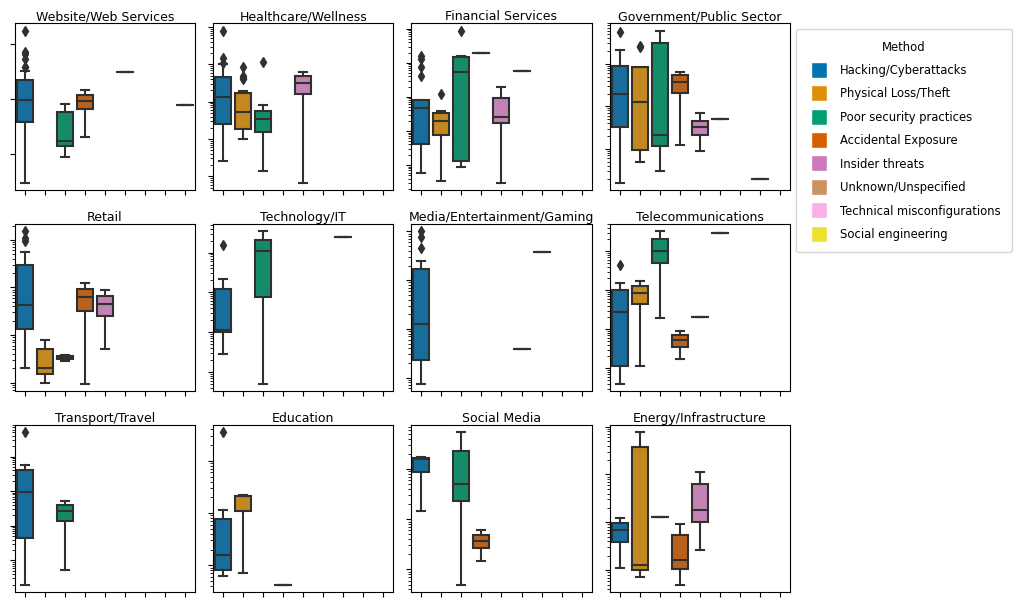

In [1737]:
import matplotlib.gridspec as gridspec

f = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1])  # 1 row, 2 columns

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

ax1 = plt.subplot(gs[0,0])
sns.boxplot(x='method_categories', y='num_records', data=web, order=method_cat_order, palette=palette, ax=ax1)
ax1.set_title('Website/Web Services', fontsize=9, y=0.97)
plt.yscale('log')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xticklabels([]) # remove tick labels
ax1.set_yticklabels([]) # remove tick labels

ax01 = plt.subplot(gs[0,1])
sns.boxplot(x='method_categories', y='num_records', data=healthcare, order=method_cat_order, palette=palette,  ax=ax01)
ax01.set_title('Healthcare/Wellness', fontsize=9, y=0.97)
plt.yscale('log')
ax01.set_xlabel('')
ax01.set_ylabel('')
ax01.set_xticklabels([]) # remove tick labels
ax01.set_yticklabels([]) # remove tick labels

ax02 = plt.subplot(gs[0,2])
sns.boxplot(x='method_categories', y='num_records', data=financial, order=method_cat_order, palette=palette,  ax=ax02)
ax02.set_title('Financial Services', fontsize=9, y=0.97)
plt.yscale('log')
ax02.set_xlabel('')
ax02.set_ylabel('')
ax02.set_xticklabels([]) # remove tick labels
ax02.set_yticklabels([]) # remove tick labels

ax10 = plt.subplot(gs[0,3])
sns.boxplot(x='method_categories', y='num_records', data=government, order=method_cat_order, palette=palette, ax=ax10)
ax10.set_title('Government/Public Sector', fontsize=9, y=0.97)
plt.yscale('log')
ax10.set_xlabel('')
ax10.set_ylabel('')
ax10.set_xticklabels([]) # remove tick labels
ax10.set_yticklabels([]) # remove tick labels

ax11 = plt.subplot(gs[1,0])
sns.boxplot(x='method_categories', y='num_records', data=retail, order=method_cat_order, palette=palette,  ax=ax11)
ax11.set_title('Retail', fontsize=9, y=0.97)
plt.yscale('log')
ax11.set_xlabel('')
ax11.set_ylabel('')
ax11.set_xticklabels([]) # remove tick labels
ax11.set_yticklabels([]) # remove tick labels

ax12 = plt.subplot(gs[1,1])
sns.boxplot(x='method_categories', y='num_records', data=tech, order=method_cat_order, palette=palette,  ax=ax12)
ax12.set_title('Technology/IT', fontsize=9, y=0.97)
plt.yscale('log')
ax12.set_xlabel('')
ax12.set_ylabel('')
ax12.set_xticklabels([]) # remove tick labels
ax12.set_yticklabels([]) # remove tick labels

ax20 = plt.subplot(gs[1,2])
sns.boxplot(x='method_categories', y='num_records', data=media, order=method_cat_order, palette=palette,  ax=ax20)
ax20.set_title('Media/Entertainment/Gaming', fontsize=9, y=0.97)
plt.yscale('log')
ax20.set_xlabel('')
ax20.set_ylabel('')
ax20.set_xticklabels([]) # remove tick labels
ax20.set_yticklabels([]) # remove tick labels

ax21 = plt.subplot(gs[1,3])
sns.boxplot(x='method_categories', y='num_records', data=telecommunications, order=method_cat_order, palette=palette,  ax=ax21)
ax21.set_title('Telecommunications', fontsize=9, y=0.97)
plt.yscale('log')
ax21.set_xlabel('')
ax21.set_ylabel('')
ax21.set_xticklabels([]) # remove tick labels
ax21.set_yticklabels([]) # remove tick labels

ax22 = plt.subplot(gs[2,0])
sns.boxplot(x='method_categories', y='num_records', data=transport, order=method_cat_order, palette=palette,  ax=ax22)
ax22.set_title('Transport/Travel', fontsize=9, y=0.97)
plt.yscale('log')
ax22.set_xlabel('')
ax22.set_ylabel('')
ax22.set_xticklabels([]) # remove tick labels
ax22.set_yticklabels([]) # remove tick labels

ax30 = plt.subplot(gs[2,1])
sns.boxplot(x='method_categories', y='num_records', data=education, order=method_cat_order, palette=palette, ax=ax30)
ax30.set_title('Education', fontsize=9, y=0.97)
plt.yscale('log')
ax30.set_xlabel('')
ax30.set_ylabel('')
ax30.set_xticklabels([]) # remove tick labels
ax30.set_yticklabels([]) # remove tick labels

ax31 = plt.subplot(gs[2,2])
sns.boxplot(x='method_categories', y='num_records', data=social, order=method_cat_order, palette=palette,  ax=ax31)
ax31.set_title('Social Media', fontsize=9, y=0.97)
plt.yscale('log')
ax31.set_xlabel('')
ax31.set_ylabel('')
ax31.set_xticklabels([]) # remove tick labels
ax31.set_yticklabels([]) # remove tick labels

ax32 = plt.subplot(gs[2,3])
sns.boxplot(x='method_categories', y='num_records', data=energy, order=method_cat_order,  palette=palette, ax=ax32)
ax32.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
plt.yscale('log')
ax32.set_xlabel('')
ax32.set_ylabel('')
ax32.set_xticklabels([]) # remove tick labels
ax32.set_yticklabels([]) # remove tick labels


first_color = palette[0]
second_color = palette[1]
third_color = palette[2]
fourth_color = palette[3]
fifth_color = palette[4]
sixth_color = palette[5]
seventh_color = palette[6]
eighth_color = palette[8]
ninth_color = palette[9]

legend_labels=['Hacking/Cyberattacks', 'Physical Loss/Theft', 'Poor security practices', 'Accidental Exposure', 'Insider threats', 'Unknown/Unspecified', 'Technical misconfigurations', 'Social engineering']
legend_colors=[first_color, second_color, third_color, fourth_color, fifth_color, sixth_color, seventh_color, eighth_color, ninth_color]
legend_handles = [plt.Line2D([0], [0], marker='s', color='White', label=label, 
                             markersize=11, markerfacecolor=color, linestyle='None') 
                  for label, color in zip(legend_labels, legend_colors)]
ax10.legend(loc='upper left',  bbox_to_anchor=(1,1), handles=legend_handles, title='Method', fontsize='small', title_fontsize='small', labelspacing=0.9, borderpad=1, facecolor='white')
#ax[0,0].legend(loc='upper left', bbox_to_anchor=(1, 1))  # customize the legend placement

# Adjust spacing between subplots
gs.update(hspace=0.2, wspace=0.1)  # Adjust horizontal spacing

### One-way ANOVA: `Organization type`

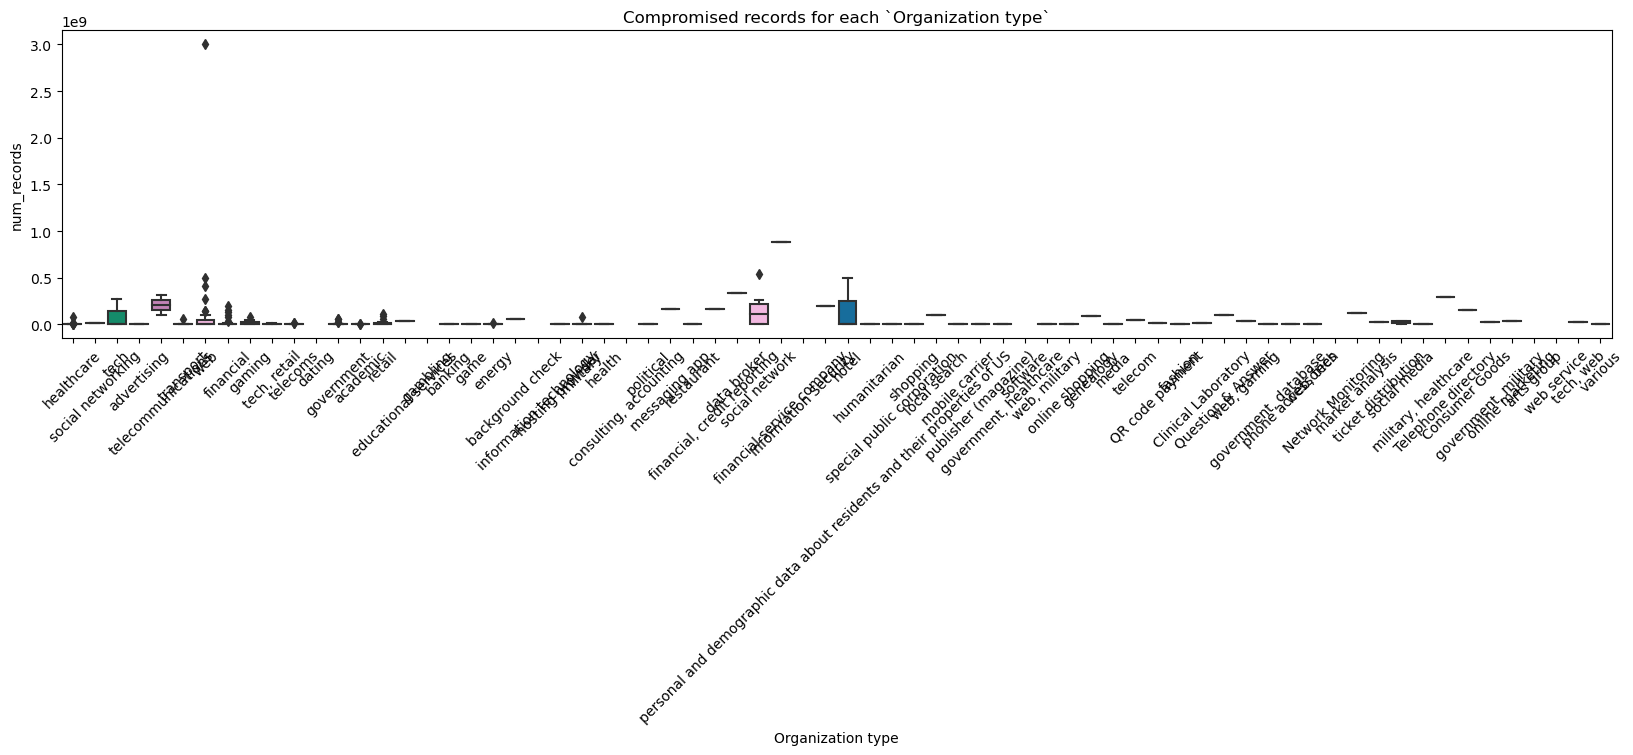

In [1738]:
# Plot: Compromised records for each `Organization type`

f, ax = plt.subplots(figsize=(20, 4))

sns.boxplot(x='Organization type', y='num_records', data=data_breaches, palette=palette, ax=ax)
ax.set_title('Compromised records for each `Organization type`')
plt.xticks(rotation=45)
plt.show()

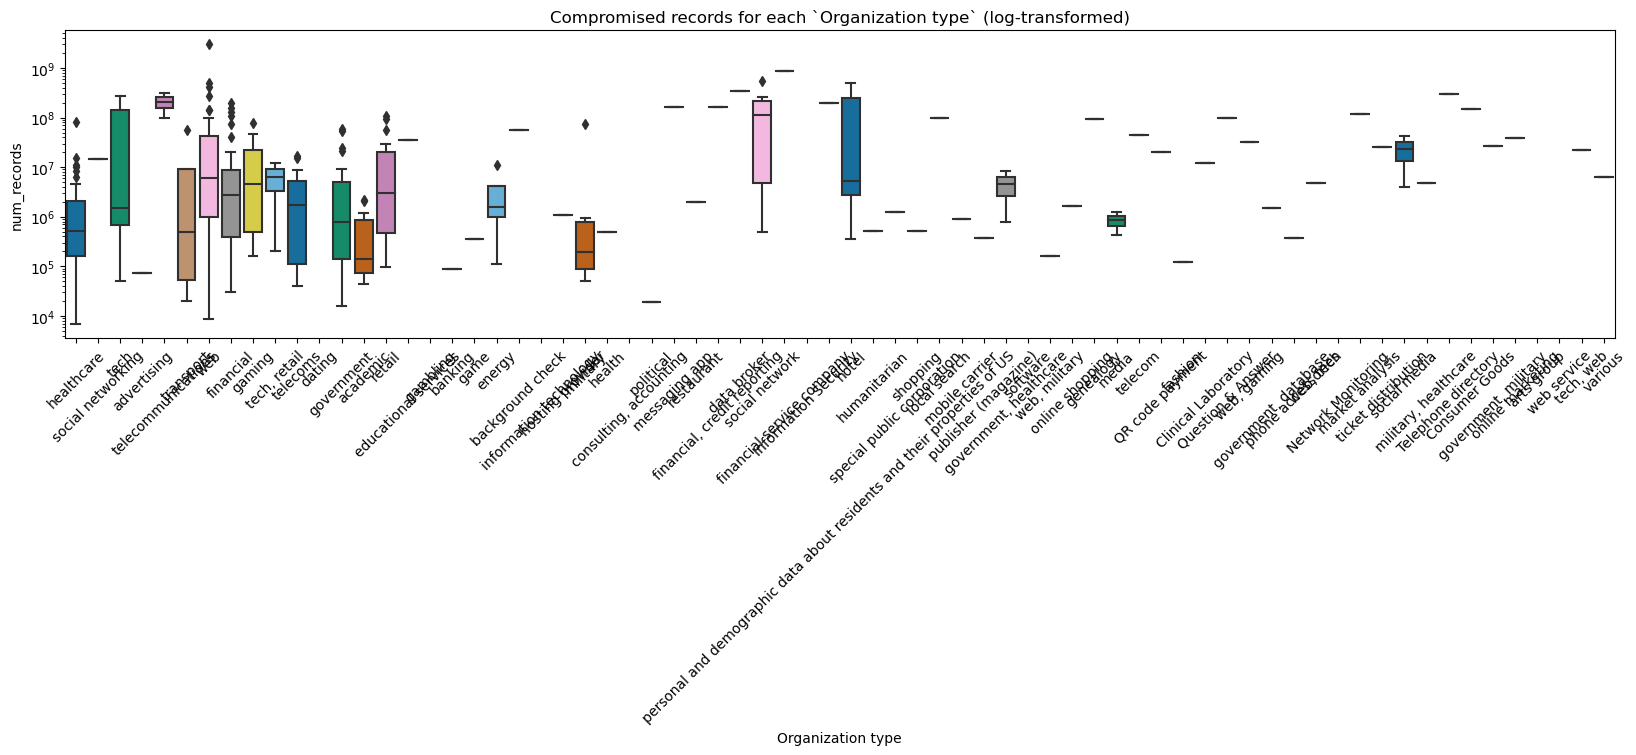

In [1739]:
# Plot: Compromised records for each `Organization type` (log-transformed)

f, ax = plt.subplots(figsize=(20, 4))

sns.boxplot(x='Organization type', y='num_records', data=data_breaches, palette=palette, ax=ax)
ax.set_yscale('log')
ax.set_title('Compromised records for each `Organization type` (log-transformed)')
plt.xticks(rotation=45)
plt.show()

In [1740]:
# One-way ANOVA: `num_records` ~ `Organization type`
import statsmodels.api as sm
from statsmodels.formula.api import ols

# fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("Organization type"))', data=cleaned_data_all).fit()
# perform the ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq         F  \
C(Q("Organization type"))   60.0  1.596300e+18  2.660499e+16  0.667445   
Residual                   244.0  9.726080e+18  3.986098e+16       NaN   

                             PR(>F)  
C(Q("Organization type"))  0.968381  
Residual                        NaN

In [1741]:
# One-way ANOVA: log(`num_records`) ~ `Organization type`
import statsmodels.api as sm
from statsmodels.formula.api import ols

# fit the model using the Q() function to handle column names correctly
model = ols('Q("log_num_records") ~ C(Q("Organization type"))', data=cleaned_data_all).fit()
# perform the ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df      sum_sq   mean_sq         F    PR(>F)
C(Q("Organization type"))   60.0  138.673172  2.311220  2.218682  0.000011
Residual                   244.0  254.176843  1.041708       NaN       NaN

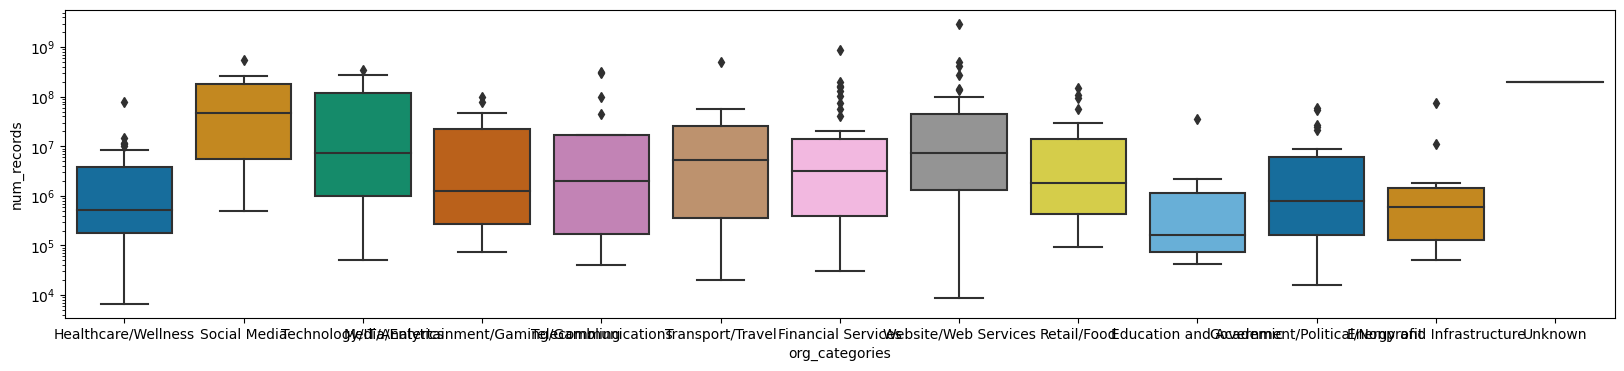

In [1742]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='org_categories', y='num_records', data=cleaned_data_all, palette=palette, ax=ax)
plt.yscale('log')  # Consider this if there's a wide range of values
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

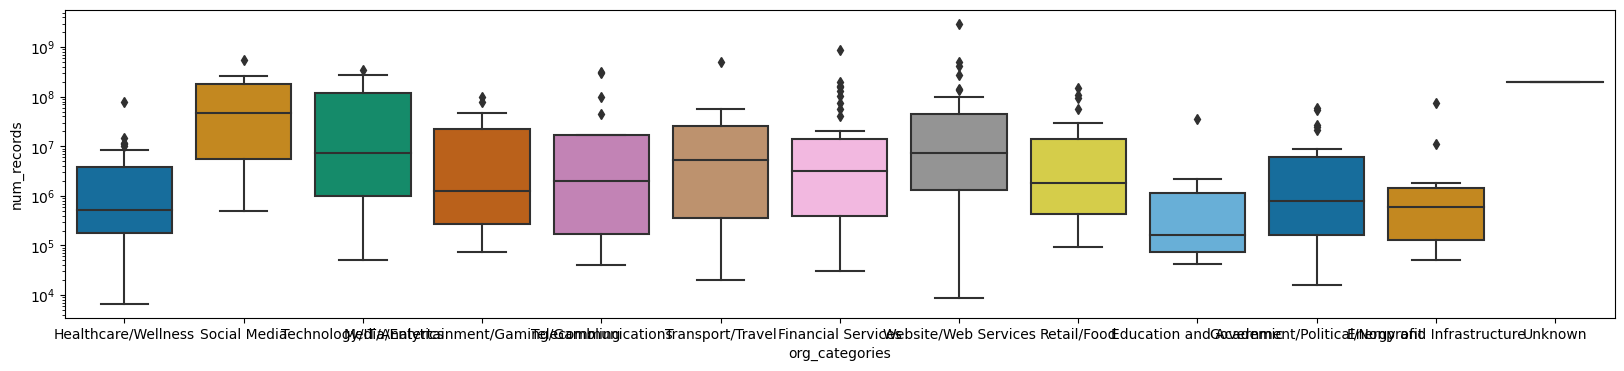

In [1743]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='org_categories', y='num_records', data=cleaned_data_all, palette=palette, ax=ax)
plt.yscale('log') 
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

In [1744]:
# One-way ANOVA: `num_records` ~ `org_categories`
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("org_categories"))', data=cleaned_data_all).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq         F   PR(>F)
C(Q("org_categories"))   12.0  4.941997e+17  4.118331e+16  1.110577  0.35091
Residual                292.0  1.082818e+19  3.708281e+16       NaN      NaN

In [1745]:
# Apply log transformation to num_records
cleaned_data_all['ln_num_records'] = np.log(cleaned_data_all['num_records'])

# Fit the model using the log-transformed variable
model = ols('ln_num_records ~ C(Q("org_categories"))', data=cleaned_data_all).fit()

# Perform the one-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

/var/folders/k8/29hfdmd56bs96xy1njxlppjc0000gn/T/ipykernel_54341/1785090002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data_all['ln_num_records'] = np.log(cleaned_data_all['num_records'])


df       sum_sq    mean_sq         F        PR(>F)
C(Q("org_categories"))   12.0   371.676471  30.973039  5.285334  4.489547e-08
Residual                292.0  1711.174284   5.860186       NaN           NaN

In [1746]:
# Apply log transformation to num_records
cleaned_data_all['log_num_records'] = np.log10(cleaned_data_all['num_records'])

# Fit the model using the log-transformed variable
model = ols('log_num_records ~ C(Q("org_categories"))', data=cleaned_data_all).fit()

# Perform the one-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

/var/folders/k8/29hfdmd56bs96xy1njxlppjc0000gn/T/ipykernel_54341/678842222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data_all['log_num_records'] = np.log10(cleaned_data_all['num_records'])


df      sum_sq   mean_sq         F        PR(>F)
C(Q("org_categories"))   12.0   70.102530  5.841878  5.285334  4.489547e-08
Residual                292.0  322.747486  1.105300       NaN           NaN

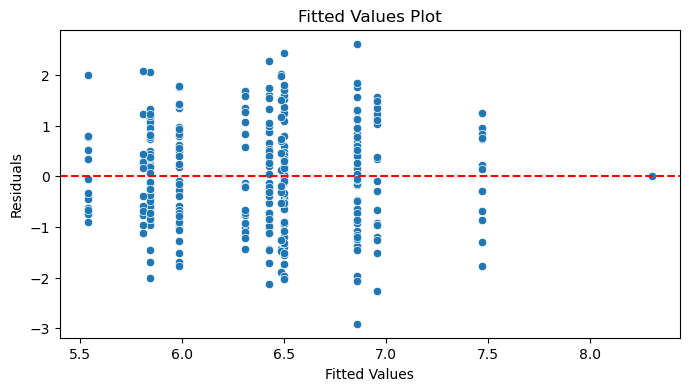

In [1747]:
f, ax = plt.subplots(figsize=(8, 4))

fitted_values = model.fittedvalues

# Create a scatter plot of fitted values vs. residuals
sns.scatterplot(x=fitted_values, y=model.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted Values Plot")
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.show()

<Axes: xlabel='Method', ylabel='num_records'>

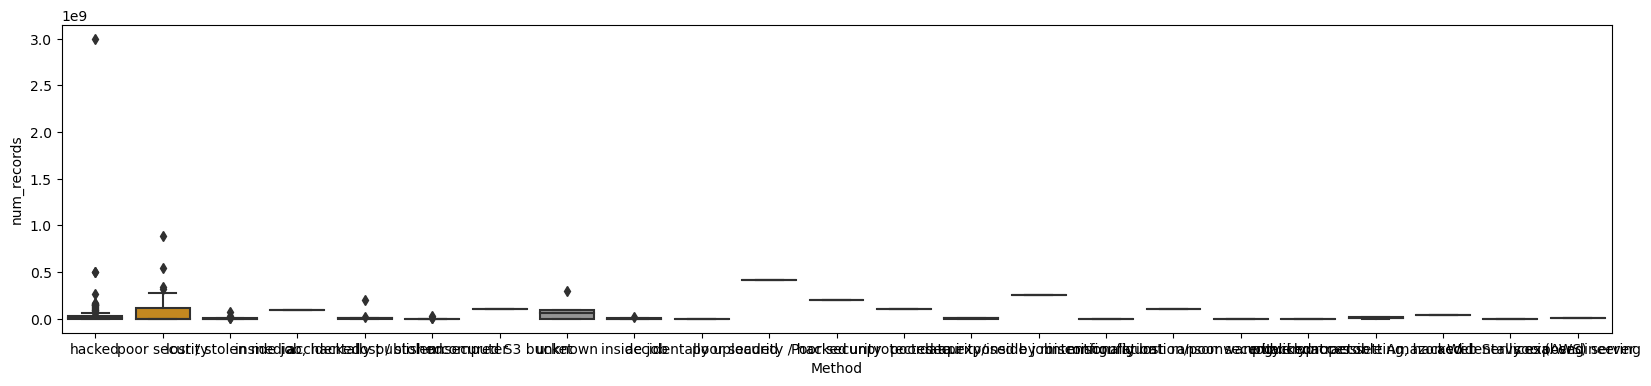

In [1748]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='Method', y='num_records', data=cleaned_data_all, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, 'hacked'),
  Text(1, 0, 'poor security'),
  Text(2, 0, 'lost / stolen media'),
  Text(3, 0, 'inside job, hacked'),
  Text(4, 0, 'accidentally published'),
  Text(5, 0, 'lost / stolen computer'),
  Text(6, 0, 'unsecured S3 bucket'),
  Text(7, 0, 'unknown'),
  Text(8, 0, 'inside job'),
  Text(9, 0, 'accidentally uploaded'),
  Text(10, 0, 'poor security / hacked'),
  Text(11, 0, 'Poor security'),
  Text(12, 0, 'unprotected api'),
  Text(13, 0, 'poor security/inside job'),
  Text(14, 0, 'data exposed by misconfiguration'),
  Text(15, 0, 'intentionally lost'),
  Text(16, 0, 'misconfiguration/poor security'),
  Text(17, 0, 'ransomware hacked'),
  Text(18, 0, 'rogue contractor'),
  Text(19, 0, 'improper setting, hacked'),
  Text(20, 0, 'publicly accessible Amazon Web Services (AWS) server'),
  Text(21, 0, 'accidentally exposed'),
  Text(22, 0, 'social engineering')])

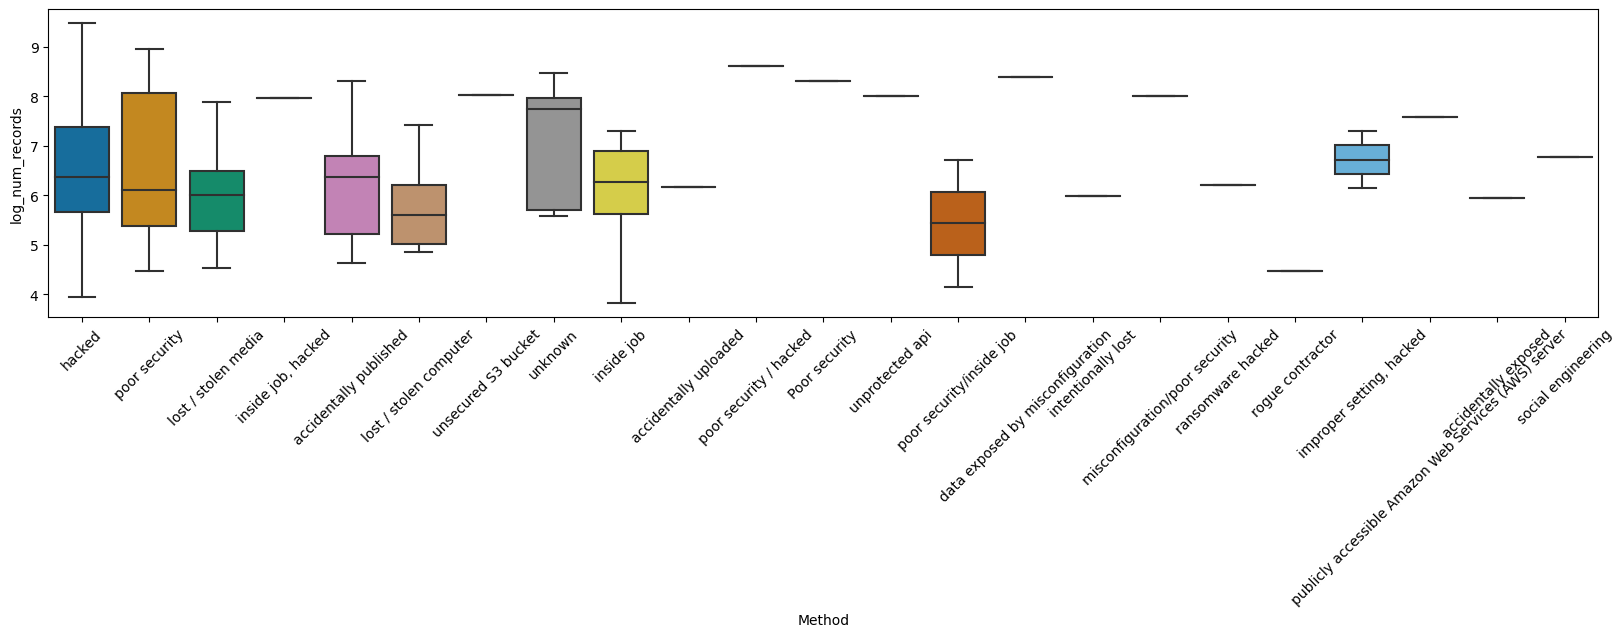

In [1749]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='Method', y='log_num_records', data=cleaned_data_all, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
plt.xticks(rotation=45)
#ax.set_ylabel('')

In [1750]:
# One-way ANOVA: `num_records` ~ `Method`
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("Method"))', data=cleaned_data_all).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq         F    PR(>F)
C(Q("Method"))   22.0  4.518715e+17  2.053961e+16  0.531038  0.960406
Residual        281.0  1.086859e+19  3.867824e+16       NaN       NaN

In [1751]:
# One-way ANOVA: `num_records` ~ `Method`
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("log_num_records") ~ C(Q("Method"))', data=cleaned_data_all).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df      sum_sq   mean_sq         F    PR(>F)
C(Q("Method"))   22.0   50.638234  2.301738  1.914817  0.009134
Residual        281.0  337.780681  1.202066       NaN       NaN

<Axes: xlabel='method_categories', ylabel='num_records'>

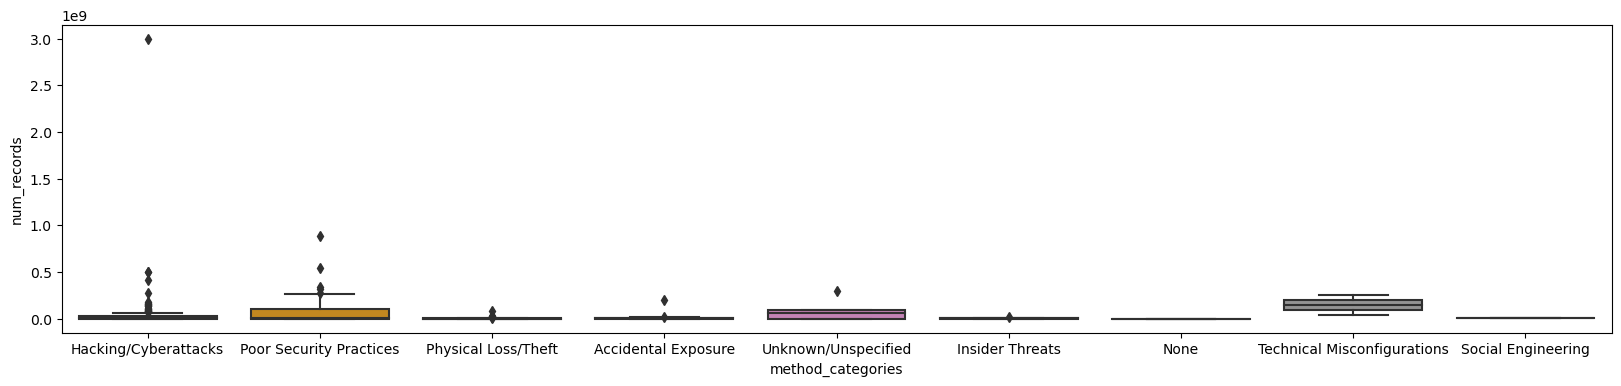

In [1752]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='method_categories', y='num_records', data=cleaned_data_all, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

<Axes: xlabel='method_categories', ylabel='log_num_records'>

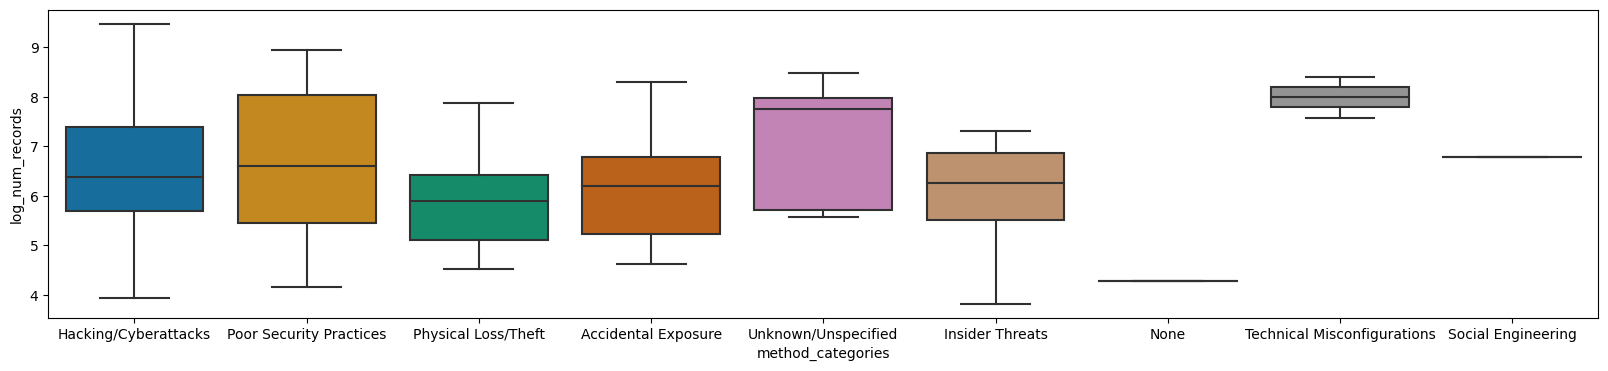

In [1753]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='method_categories', y='log_num_records', data=cleaned_data_all, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

In [1754]:
# One-way ANOVA: `num_records` ~ `method_categories`
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("method_categories"))', data=cleaned_data_all).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq         F  \
C(Q("method_categories"))    8.0  2.628729e+17  3.285912e+16  0.879451   
Residual                   296.0  1.105951e+19  3.736320e+16       NaN   

                             PR(>F)  
C(Q("method_categories"))  0.534106  
Residual                        NaN

In [1755]:
# Two-way ANOVA without interaction: `num_records` ~ `org_categories` + `method_categories` 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("org_categories")) + C(Q("method_categories"))', data=cleaned_data_all).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)
anova_results

sum_sq     df         F    PR(>F)
C(Q("org_categories"))     3.599304e+17   12.0  0.796139  0.654430
C(Q("method_categories"))  1.286037e+17    8.0  0.426693  0.904638
Residual                   1.069958e+19  284.0       NaN       NaN

In [1756]:
# Two-way ANOVA with interaction: `num_records` ~ `org_categories` + `method_categories` + `org_categories`:`method_categories`
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("org_categories")) + C(Q("method_categories")) + C(Q("org_categories")) * C(Q("method_categories"))', data=cleaned_data_all).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)
anova_results

/Users/mollyscally/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/mollyscally/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/mollyscally/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 96, but rank is 43
  warnings.warn('covariance of constraints does not have full '


sum_sq     df  \
C(Q("org_categories"))                            1.481452e+17   12.0   
C(Q("method_categories"))                         4.101113e+03    8.0   
C(Q("org_categories")):C(Q("method_categories"))  1.352321e+18   96.0   
Residual                                          1.031122e+19  252.0   

                                                             F    PR(>F)  
C(Q("org_categories"))                            3.017148e-01  0.824146  
C(Q("method_categories"))                         1.252859e-14  1.000000  
C(Q("org_categories")):C(Q("method_categories"))  3.442697e-01  0.999963  
Residual                                                   NaN       NaN

### One-way ANOVA: Web 

<Axes: xlabel='method_categories', ylabel='num_records'>

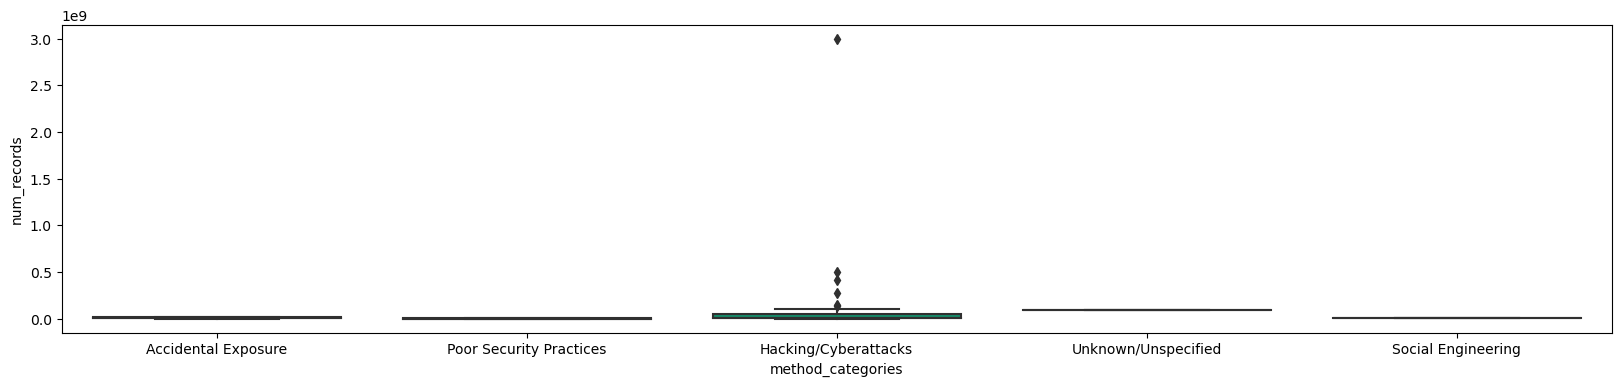

In [1757]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='method_categories', y='num_records', data=web, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

In [1758]:
web.groupby('method_categories').size().reset_index(name='count')

method_categories  count
0      Accidental Exposure      4
1     Hacking/Cyberattacks     48
2  Poor Security Practices      3
3       Social Engineering      1
4      Unknown/Unspecified      1

In [1759]:
# One-way ANOVA: `num_records` ~ web `method_categories` 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("method_categories"))', data=web).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq         F  \
C(Q("method_categories"))   4.0  7.635958e+16  1.908990e+16  0.100146   
Residual                   47.0  8.959148e+18  1.906202e+17       NaN   

                             PR(>F)  
C(Q("method_categories"))  0.981877  
Residual                        NaN

<Axes: xlabel='method_categories', ylabel='num_records'>

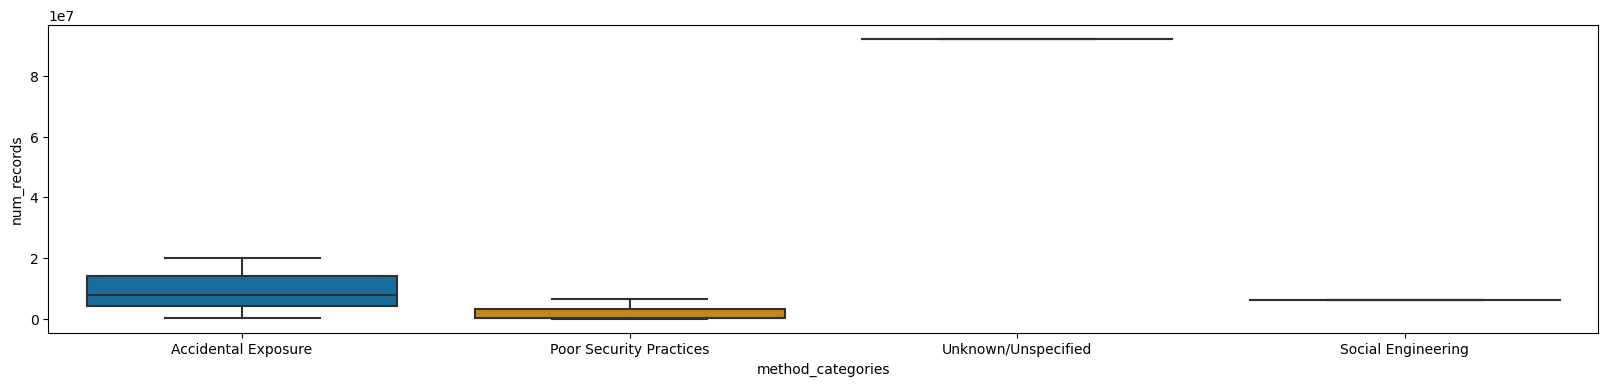

In [1760]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='method_categories', y='num_records', data=web_not_hacking, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

In [1761]:
# One-way ANOVA: `num_records` ~ web `method_categories` 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("method_categories"))', data=web_not_hacking).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq          F  \
C(Q("method_categories"))  3.0  6.608582e+15  2.202861e+15  39.925824   
Residual                   4.0  2.206953e+14  5.517383e+13        NaN   

                             PR(>F)  
C(Q("method_categories"))  0.001937  
Residual                        NaN

### One-way ANOVA: `healthcare`

<Axes: xlabel='method_categories', ylabel='num_records'>

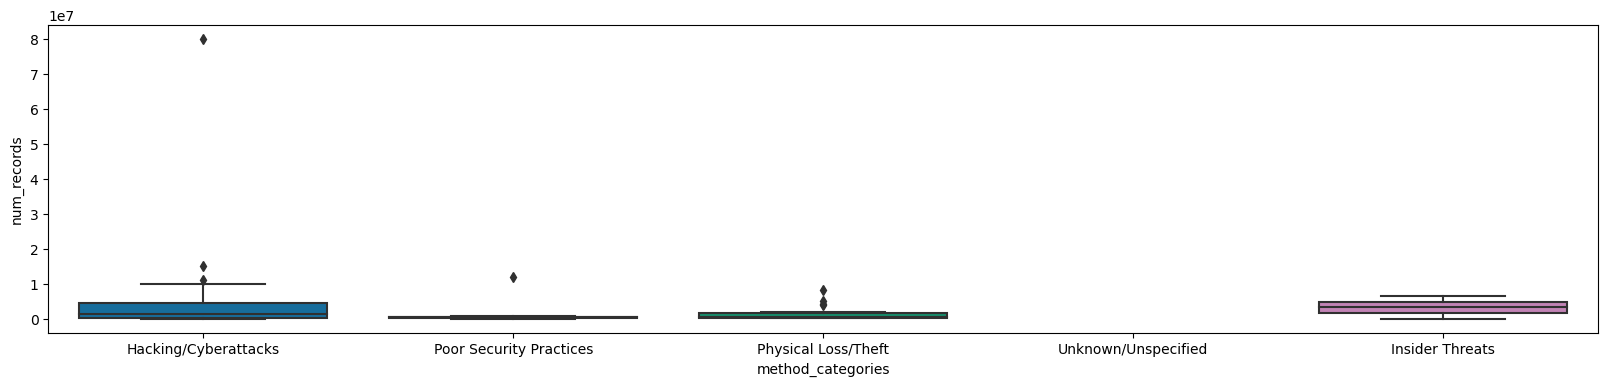

In [1762]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='method_categories', y='num_records', data=healthcare, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

In [1763]:
healthcare.groupby('method_categories').size().reset_index(name='count')

method_categories  count
0     Hacking/Cyberattacks     18
1          Insider Threats      2
2      Physical Loss/Theft     21
3  Poor Security Practices      8
4      Unknown/Unspecified      1

In [1764]:
# One-way ANOVA: `num_records` ~ healthcare `method_categories` 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("method_categories"))', data=healthcare).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq         F  \
C(Q("method_categories"))   4.0  4.364119e+14  1.091030e+14  0.802898   
Residual                   45.0  6.114891e+15  1.358865e+14       NaN   

                             PR(>F)  
C(Q("method_categories"))  0.529797  
Residual                        NaN

### One-way ANOVA: `financial`

<Axes: xlabel='method_categories', ylabel='num_records'>

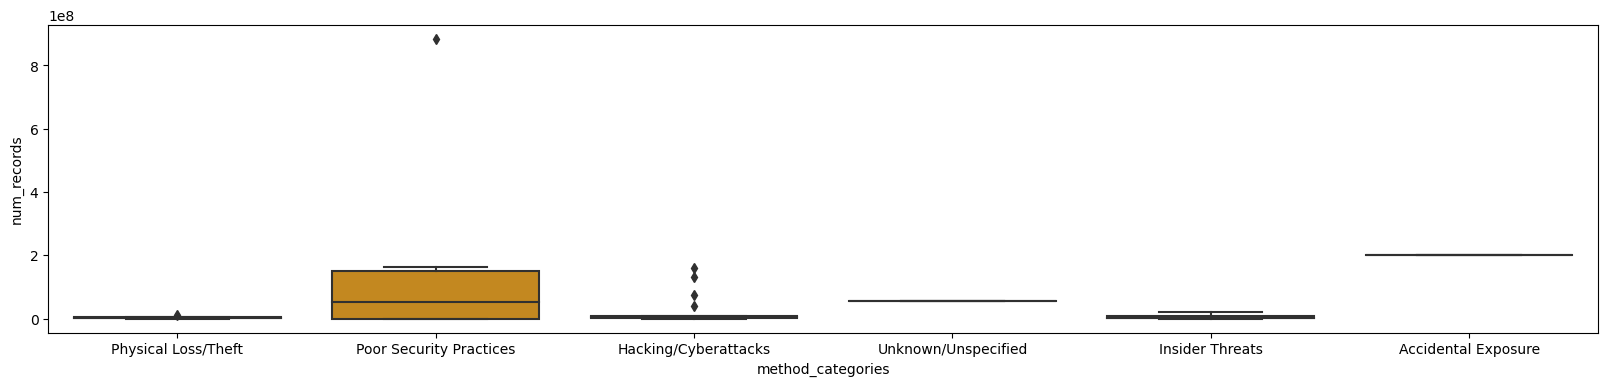

In [1765]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='method_categories', y='num_records', data=financial, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

In [1766]:
financial.groupby('method_categories').size().reset_index(name='count')

method_categories  count
0      Accidental Exposure      1
1     Hacking/Cyberattacks     19
2          Insider Threats      7
3      Physical Loss/Theft      8
4  Poor Security Practices      7
5      Unknown/Unspecified      1

In [1767]:
# One-way ANOVA: `num_records` ~ financial `method_categories` 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("method_categories"))', data=financial).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq         F  \
C(Q("method_categories"))   5.0  1.847619e+17  3.695237e+16  1.969643   
Residual                   34.0  6.378723e+17  1.876095e+16       NaN   

                             PR(>F)  
C(Q("method_categories"))  0.108431  
Residual                        NaN

### One-way ANOVA: `government`

<Axes: xlabel='method_categories', ylabel='num_records'>

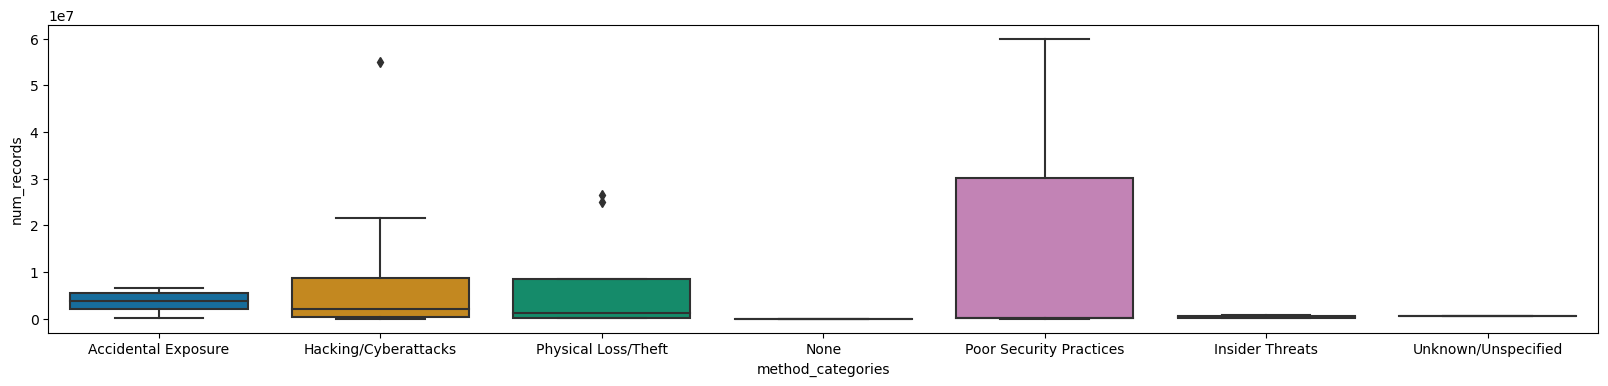

In [1768]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='method_categories', y='num_records', data=government, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

In [1769]:
government.groupby('method_categories').size().reset_index(name='count')

method_categories  count
0      Accidental Exposure      7
1     Hacking/Cyberattacks     12
2          Insider Threats      4
3                     None      1
4      Physical Loss/Theft      8
5  Poor Security Practices      4
6      Unknown/Unspecified      1

In [1770]:
# One-way ANOVA: `num_records` ~ government `method_categories` 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("method_categories"))', data=government).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
#print("One-way ANOVA: `num_records` ~ government `method_categories`:\n", anova_results)
anova_results

df        sum_sq       mean_sq         F  \
C(Q("method_categories"))   6.0  9.305221e+14  1.550870e+14  0.669822   
Residual                   26.0  6.019905e+15  2.315348e+14       NaN   

                             PR(>F)  
C(Q("method_categories"))  0.674756  
Residual                        NaN

### One-way ANOVA: `retail`

<Axes: xlabel='method_categories', ylabel='num_records'>

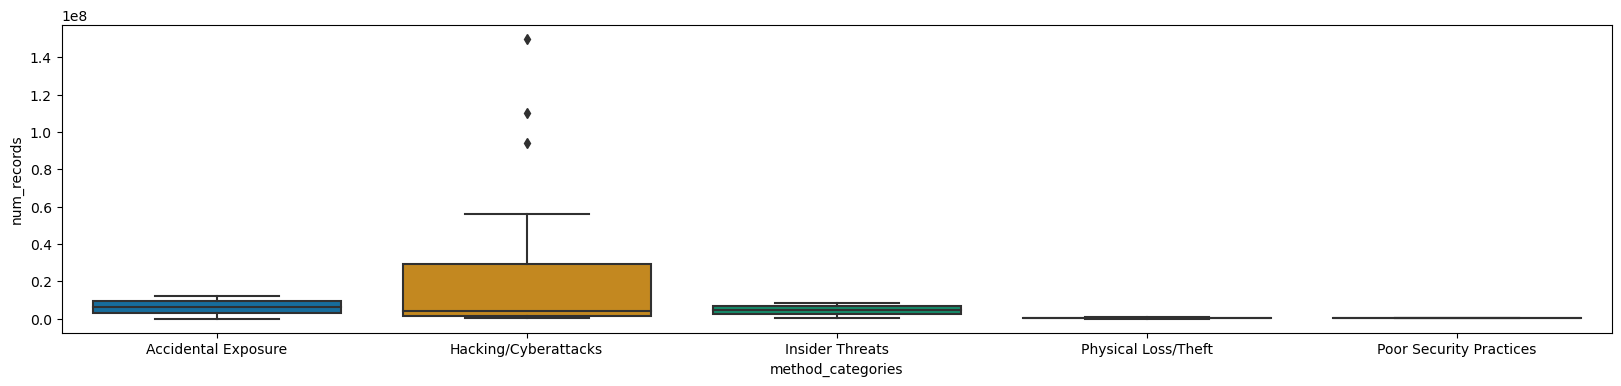

In [1771]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='method_categories', y='num_records', data=retail, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

In [1772]:
retail.groupby('method_categories').size().reset_index(name='count')

method_categories  count
0      Accidental Exposure      2
1     Hacking/Cyberattacks     27
2          Insider Threats      2
3      Physical Loss/Theft      3
4  Poor Security Practices      2

In [1773]:
# One-way ANOVA: `num_records` ~ retail `method_categories` 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("method_categories"))', data=retail).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq         F  \
C(Q("method_categories"))   4.0  3.741759e+15  9.354399e+14  0.616535   
Residual                   23.0  3.489682e+16  1.517253e+15       NaN   

                             PR(>F)  
C(Q("method_categories"))  0.655133  
Residual                        NaN

### One-way ANOVA: `tech`

<Axes: xlabel='method_categories', ylabel='num_records'>

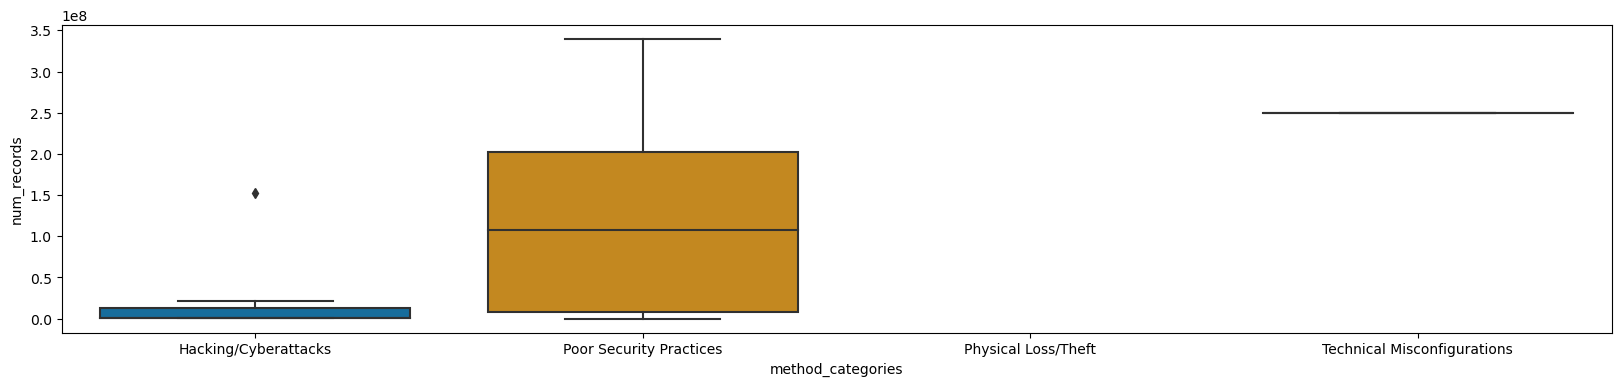

In [1774]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='method_categories', y='num_records', data=tech, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

In [1775]:
tech.groupby('method_categories').size().reset_index(name='count')

method_categories  count
0         Hacking/Cyberattacks     18
1          Physical Loss/Theft      1
2      Poor Security Practices     10
3  Technical Misconfigurations      1

In [1776]:
# One-way ANOVA: `num_records` ~ tech `method_categories` 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("method_categories"))', data=tech).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq         F  \
C(Q("method_categories"))   3.0  1.135682e+17  3.785607e+16  4.846487   
Residual                   18.0  1.405986e+17  7.811033e+15       NaN   

                             PR(>F)  
C(Q("method_categories"))  0.012097  
Residual                        NaN

<Axes: xlabel='method_categories', ylabel='num_records'>

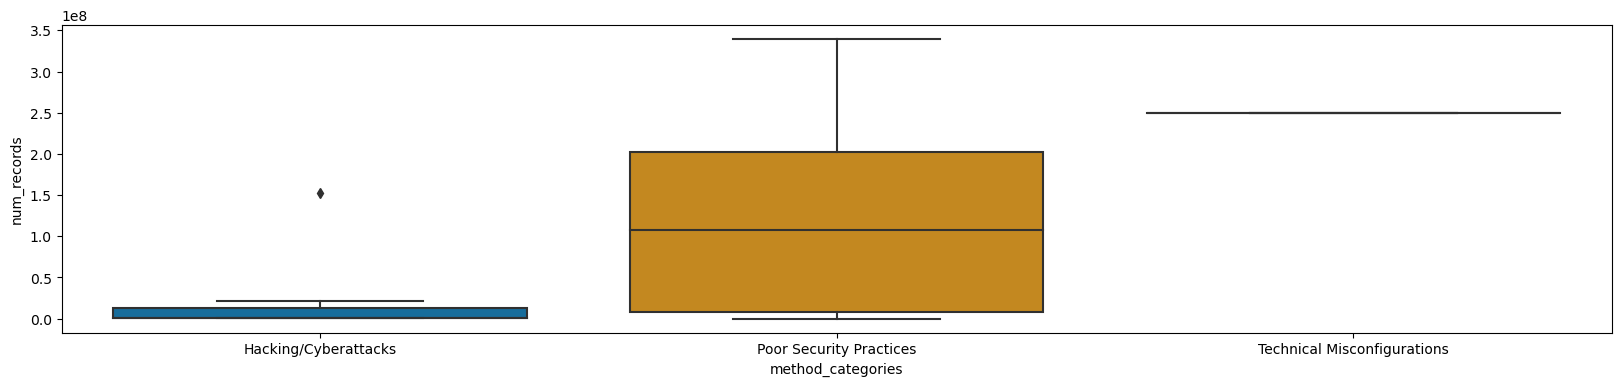

In [1777]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='method_categories', y='num_records', data=cleaned_data_tech, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

In [1778]:
cleaned_data_tech.groupby('method_categories').size().reset_index(name='count')

method_categories  count
0         Hacking/Cyberattacks     11
1      Poor Security Practices      9
2  Technical Misconfigurations      1

In [1779]:
# One-way ANOVA: `num_records` ~ cleaned_data_tech `method_categories` 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("method_categories"))', data=cleaned_data_tech).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq         F  \
C(Q("method_categories"))   2.0  9.082618e+16  4.541309e+16  5.813967   
Residual                   18.0  1.405986e+17  7.811033e+15       NaN   

                             PR(>F)  
C(Q("method_categories"))  0.011276  
Residual                        NaN

In [1780]:
# post-hoc tests: tech 'method_categories' to determine how different method categories differ in terms of number of records using Tukey's HSD
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# extract the endog and groups data for the test
endog = tech['num_records']
groups = tech['method_categories']

# tukey's HSD test
tukey_hsd_results = pairwise_tukeyhsd(endog, groups)
# display
tukey_hsd_results.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [1781]:
# post-hoc tests: cleaned_data_tech 'method_categories' to determine how different method categories differ in terms of number of records using Tukey's HSD
from statsmodels.stats.multicomp import pairwise_tukeyhsd

cleaned_data_tech = tech.dropna(subset=['num_records'])


# Extract the endog and groups data for the test from the cleaned data
endog = cleaned_data_tech['num_records']
groups = cleaned_data_tech['method_categories']

# Tukey's HSD test
tukey_hsd_results = pairwise_tukeyhsd(endog, groups)

# Display the results
tukey_hsd_results.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

### One-way ANOVA: `media`

<Axes: xlabel='method_categories', ylabel='num_records'>

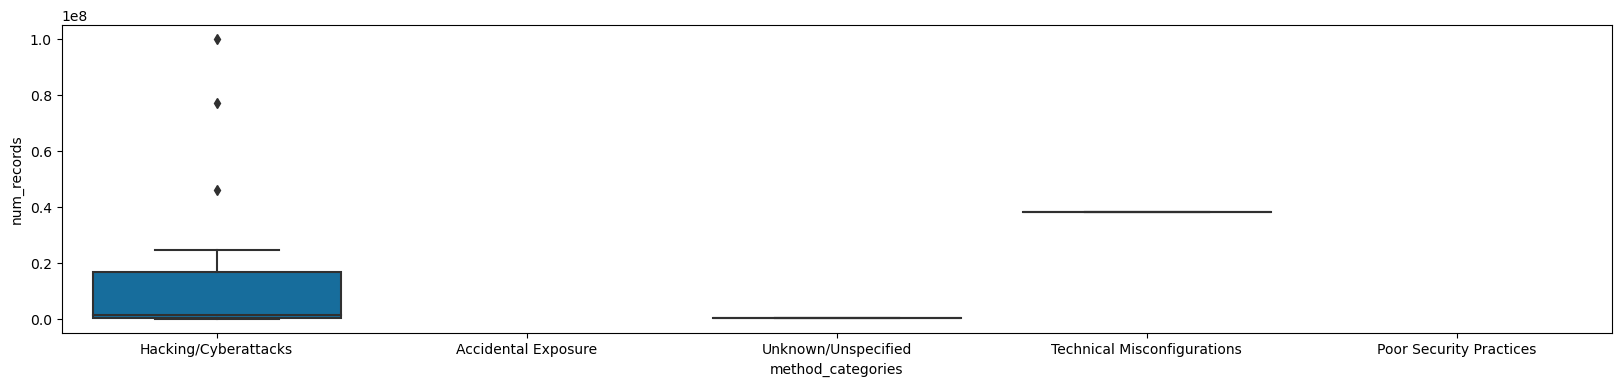

In [1782]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='method_categories', y='num_records', data=media, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

In [1783]:
media.groupby('method_categories').size().reset_index(name='count')

method_categories  count
0          Accidental Exposure      1
1         Hacking/Cyberattacks     18
2      Poor Security Practices      1
3  Technical Misconfigurations      1
4          Unknown/Unspecified      2

In [1784]:
# One-way ANOVA: `num_records` ~ media `method_categories` 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("method_categories"))', data=media).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq         F  \
C(Q("method_categories"))   4.0  1.055310e+15  2.638274e+14  0.278922   
Residual                   15.0  1.418821e+16  9.458809e+14       NaN   

                             PR(>F)  
C(Q("method_categories"))  0.887033  
Residual                        NaN

### One-way ANOVA: `telecommunications`

<Axes: xlabel='method_categories', ylabel='num_records'>

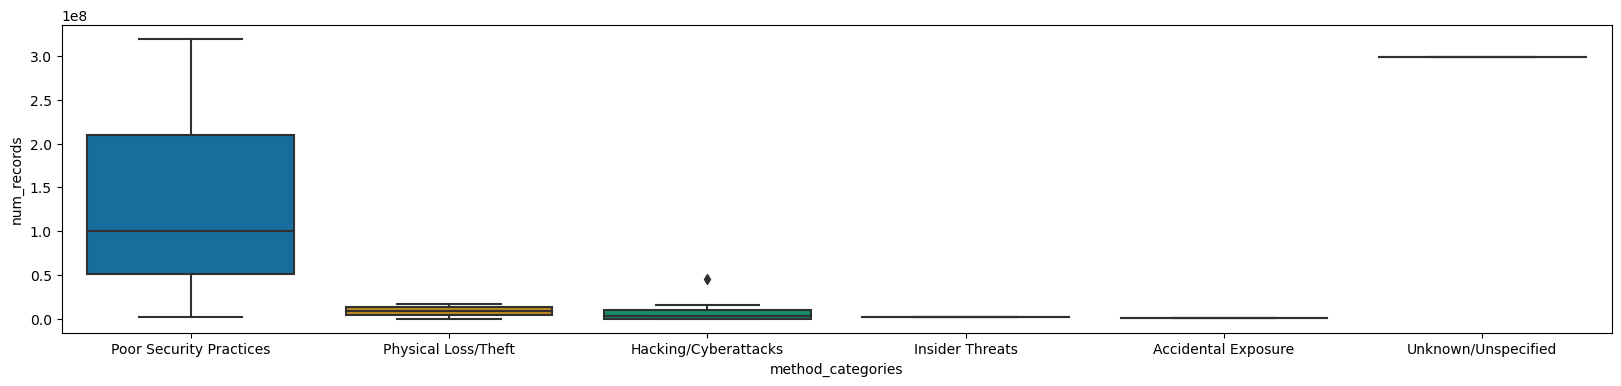

In [1785]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='method_categories', y='num_records', data=telecommunications, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

In [1786]:
telecommunications.groupby('method_categories').size().reset_index(name='count')

method_categories  count
0      Accidental Exposure      2
1     Hacking/Cyberattacks      9
2          Insider Threats      2
3      Physical Loss/Theft      2
4  Poor Security Practices      3
5      Unknown/Unspecified      1

In [1787]:
# One-way ANOVA: `num_records` ~ telecommunications `method_categories` 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("method_categories"))', data=telecommunications).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq         F  \
C(Q("method_categories"))   5.0  1.104822e+17  2.209644e+16  4.430218   
Residual                   11.0  5.486430e+16  4.987663e+15       NaN   

                             PR(>F)  
C(Q("method_categories"))  0.018638  
Residual                        NaN

<Axes: xlabel='method_categories', ylabel='num_records'>

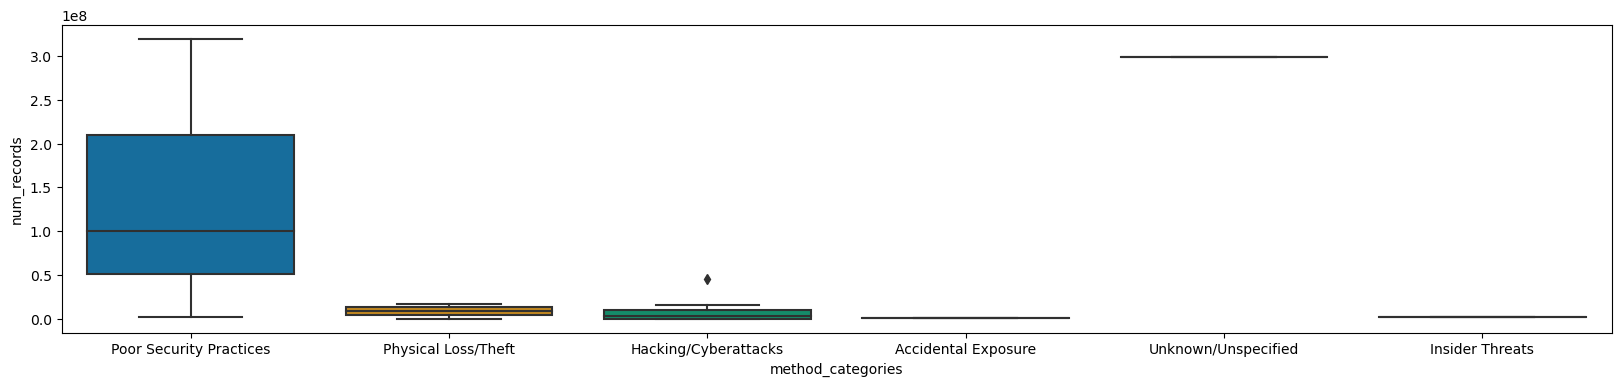

In [1788]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='method_categories', y='num_records', data=cleaned_data_telecommunications, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

In [1789]:
cleaned_data_telecommunications.groupby('method_categories').size().reset_index(name='count')

method_categories  count
0      Accidental Exposure      2
1     Hacking/Cyberattacks      8
2          Insider Threats      1
3      Physical Loss/Theft      2
4  Poor Security Practices      3
5      Unknown/Unspecified      1

In [1790]:
# One-way ANOVA: `num_records` ~ cleaned_data_telecommunications `method_categories` 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("method_categories"))', data=cleaned_data_telecommunications).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq         F  \
C(Q("method_categories"))   5.0  1.104822e+17  2.209644e+16  4.430218   
Residual                   11.0  5.486430e+16  4.987663e+15       NaN   

                             PR(>F)  
C(Q("method_categories"))  0.018638  
Residual                        NaN

In [1791]:
# post-hoc tests: cleaned_data_telecommunications 'method_categories' to determine how different method categories differ in terms of number of records using Tukey's HSD
from statsmodels.stats.multicomp import pairwise_tukeyhsd

cleaned_data_telecommunications = telecommunications.dropna(subset=['num_records'])


# Extract the endog and groups data for the test from the cleaned data
endog = cleaned_data_telecommunications['num_records']
groups = cleaned_data_telecommunications['method_categories']

# Tukey's HSD test
tukey_hsd_results = pairwise_tukeyhsd(endog, groups)

# Display the results
tukey_hsd_results.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

### One-way ANOVA: `transport`

<Axes: xlabel='method_categories', ylabel='num_records'>

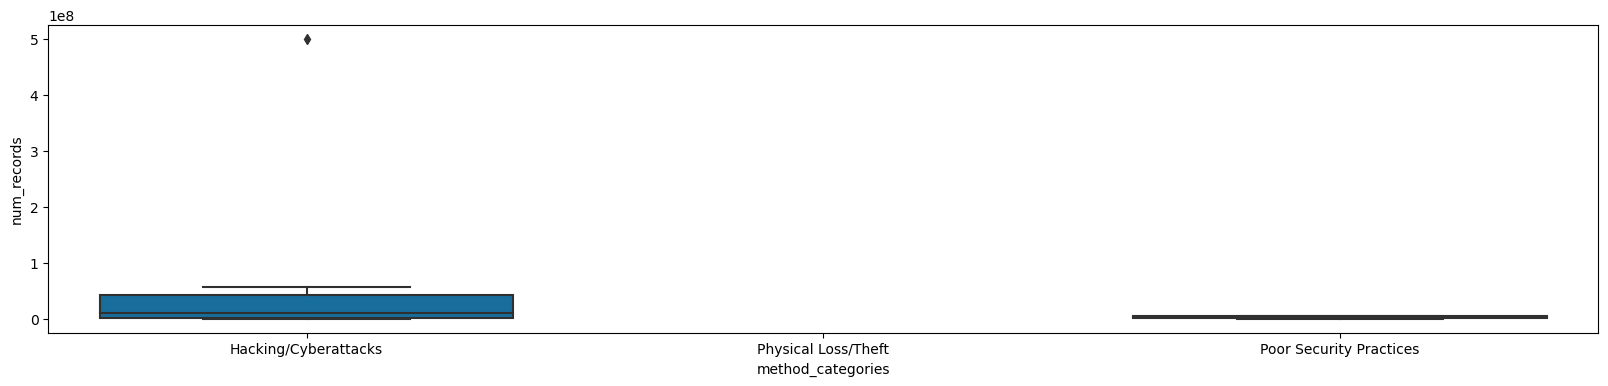

In [1792]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='method_categories', y='num_records', data=transport, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

In [1793]:
transport.groupby('method_categories').size().reset_index(name='count')

method_categories  count
0     Hacking/Cyberattacks     13
1      Physical Loss/Theft      1
2  Poor Security Practices      2

In [1794]:
# One-way ANOVA: `num_records` ~ transport `method_categories` 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("method_categories"))', data=transport).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq         F    PR(>F)
C(Q("method_categories"))  2.0  1.455032e+16  7.275160e+15  0.249974  0.785487
Residual                   7.0  2.037257e+17  2.910367e+16       NaN       NaN

### One-way ANOVA: `education`

<Axes: xlabel='method_categories', ylabel='num_records'>

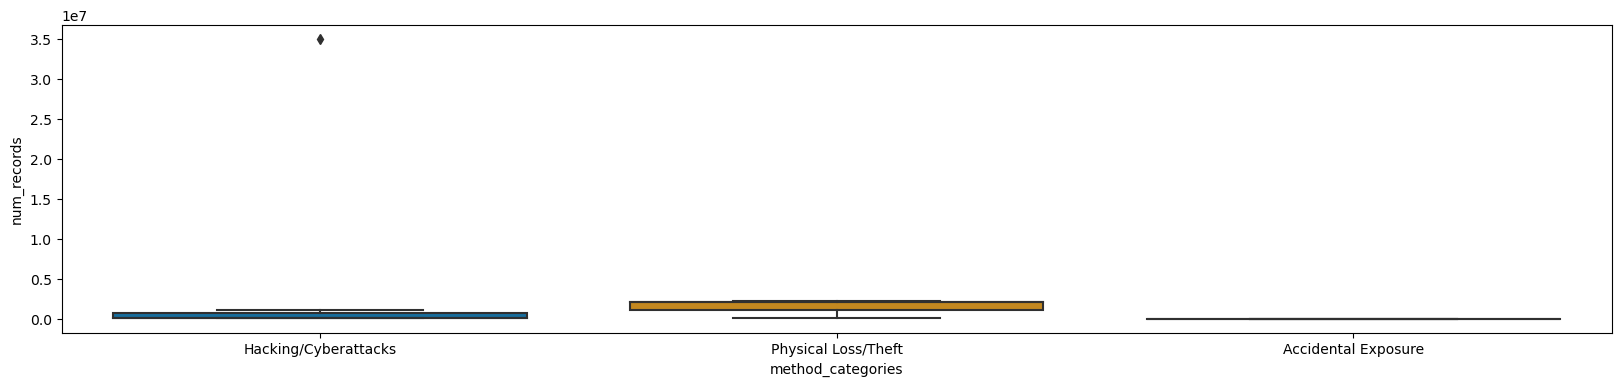

In [1795]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='method_categories', y='num_records', data=education, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

In [1796]:
education.groupby('method_categories').size().reset_index(name='count')

method_categories  count
0   Accidental Exposure      1
1  Hacking/Cyberattacks     10
2   Physical Loss/Theft      3

In [1797]:
# One-way ANOVA: `num_records` ~ education `method_categories` 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("method_categories"))', data=education).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq         F  \
C(Q("method_categories"))   2.0  2.798260e+13  1.399130e+13  0.130237   
Residual                   10.0  1.074295e+15  1.074295e+14       NaN   

                             PR(>F)  
C(Q("method_categories"))  0.879352  
Residual                        NaN

### One-way ANOVA: `social`

<Axes: xlabel='method_categories', ylabel='num_records'>

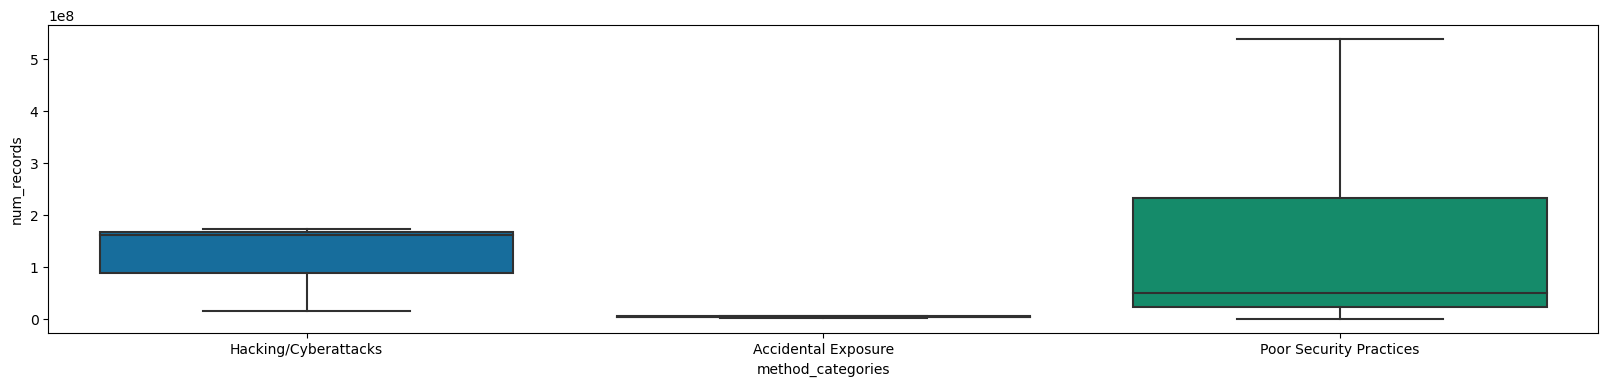

In [1798]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='method_categories', y='num_records', data=social, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

In [1799]:
social.groupby('method_categories').size().reset_index(name='count')

method_categories  count
0      Accidental Exposure      2
1     Hacking/Cyberattacks      4
2  Poor Security Practices      7

In [1800]:
# One-way ANOVA: `num_records` ~ social `method_categories` 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("method_categories"))', data=social).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq         F    PR(>F)
C(Q("method_categories"))  2.0  3.694492e+16  1.847246e+16  0.668185  0.536334
Residual                   9.0  2.488115e+17  2.764573e+16       NaN       NaN

### One-way ANOVA: `energy`

<Axes: xlabel='method_categories', ylabel='num_records'>

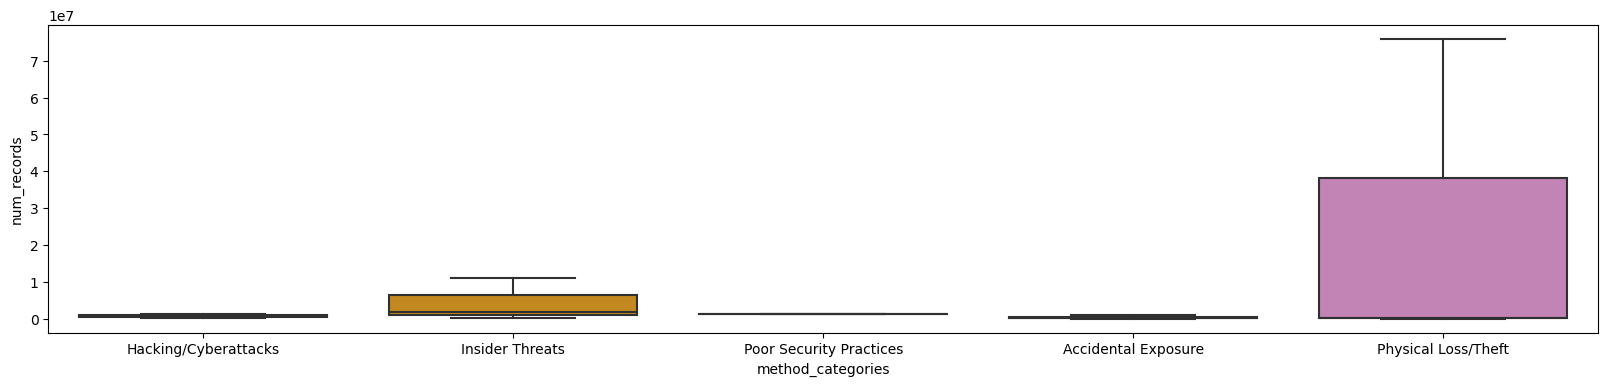

In [1801]:
f, ax = plt.subplots(figsize=(20, 4))

method_cat_order = data_breaches['method_categories'].value_counts().index

palette = sns.color_palette("colorblind", 25)

sns.boxplot(x='method_categories', y='num_records', data=energy, palette=palette, ax=ax)
#ax.set_title('Energy/Infrastructure', fontsize=9, y=0.97)
#ax.set_xlabel('')
#ax.set_ylabel('')

In [1802]:
energy.groupby('method_categories').size().reset_index(name='count')

method_categories  count
0      Accidental Exposure      3
1     Hacking/Cyberattacks      3
2          Insider Threats      3
3      Physical Loss/Theft      3
4  Poor Security Practices      1

In [1803]:
# One-way ANOVA: `num_records` ~ energy `method_categories` 
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Fit the model using the Q() function to handle column names correctly
model = ols('Q("num_records") ~ C(Q("method_categories"))', data=energy).fit()
# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=1)
anova_results

df        sum_sq       mean_sq         F    PR(>F)
C(Q("method_categories"))  4.0  1.273000e+15  3.182501e+14  0.569715  0.693472
Residual                   7.0  3.910292e+15  5.586132e+14       NaN       NaN

now, we can do the same thing but with the number of records. this will tell us which methods seem to be most severe for diffrent sectors. 

In [1804]:
#web_hacking = web.query("method_categories == 'Hacking/Cyberattacks'")

In [1805]:
data_breaches_not_hacking = data_breaches.query("method_categories != 'Hacking/Cyberattacks'")

In [1806]:
web_breach_counts = web.groupby('Year').size().reset_index(name='count')
healthcare_breach_counts = healthcare.groupby('Year').size().reset_index(name='count')
financial_breach_counts = financial.groupby('Year').size().reset_index(name='count')
government_breach_counts = government.groupby('Year').size().reset_index(name='count')
retail_breach_counts = retail.groupby('Year').size().reset_index(name='count')
tech_breach_counts = tech.groupby('Year').size().reset_index(name='count')
media_breach_counts = media.groupby('Year').size().reset_index(name='count')
healthcare_breach_counts = healthcare.groupby('Year').size().reset_index(name='count')

In [1807]:
data_breaches_counts = data_breaches.groupby('Year').size().reset_index(name='count')
data_breaches_counts

Year  count
0   2004      2
1   2005      6
2   2006      7
3   2007     12
4   2008     16
5   2009     13
6   2010     19
7   2011     34
8   2012     23
9   2013     28
10  2014     26
11  2015     28
12  2016     22
13  2017      9
14  2018     27
15  2019     31
16  2020     31
17  2021     13
18  2022      5

In [1808]:
data_breaches_counts2 = data_breaches.groupby(['Year', 'hacked']).size().reset_index(name='count')
data_breaches_counts2 = data_breaches_counts2.pivot(index='Year', columns='hacked', values='count').reset_index()
data_breaches_counts2.columns.name = None 
data_breaches_counts2

Year  Hacking  Non-Hacking
0   2004        1            1
1   2005        2            4
2   2006        1            6
3   2007        4            8
4   2008        3           13
5   2009        7            6
6   2010        7           12
7   2011       17           17
8   2012       15            8
9   2013       21            7
10  2014       22            4
11  2015       24            4
12  2016       17            5
13  2017        4            5
14  2018       19            8
15  2019       11           20
16  2020       15           16
17  2021        8            5
18  2022        1            4

financial_counts2 = financial.groupby(['Year', 'hacked']).size().reset_index(name='count')
financial_counts2 = financial_counts2.pivot(index='Year', columns='hacked', values='count').reset_index()
financial_counts2.columns.name = None 
financial_counts2

In [1809]:
import scikit_posthocs as sp
# perform the Dunn test
dunn_result = sp.posthoc_dunn(cleaned_data_tech, val_col='num_records', group_col='method_categories', p_adjust='holm')

# display the results
print(dunn_result)

                             Hacking/Cyberattacks  Poor Security Practices  \
Hacking/Cyberattacks                     1.000000                 0.260821   
Poor Security Practices                  0.260821                 1.000000   
Technical Misconfigurations              0.260821                 0.376406   

                             Technical Misconfigurations  
Hacking/Cyberattacks                            0.260821  
Poor Security Practices                         0.376406  
Technical Misconfigurations                     1.000000  


In [1810]:

cleaned_data_all = data_breaches.dropna(subset=['num_records'])

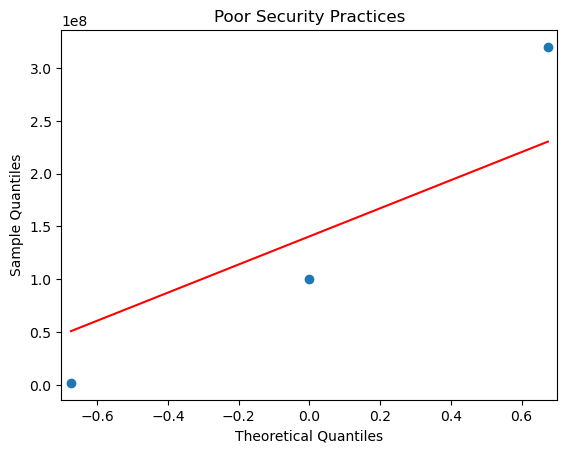

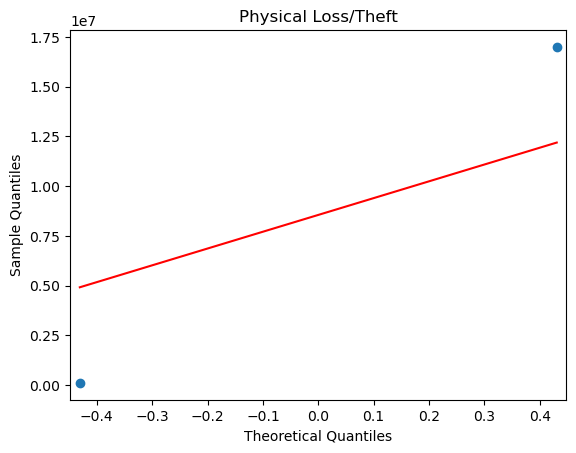

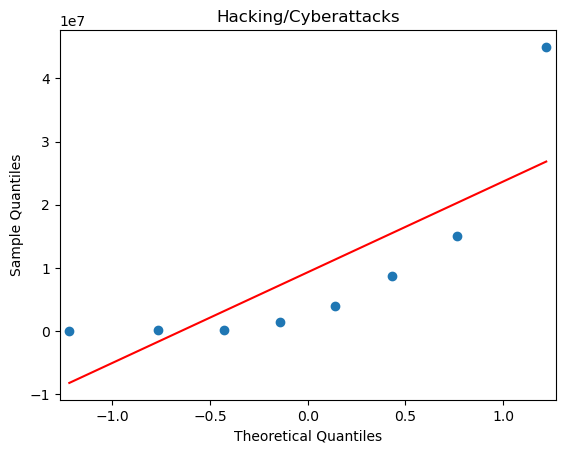

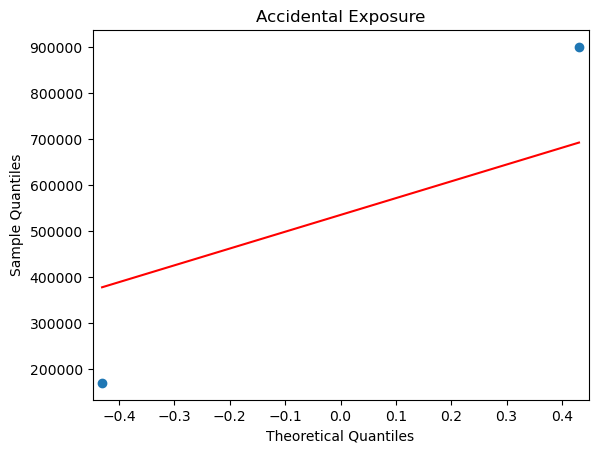

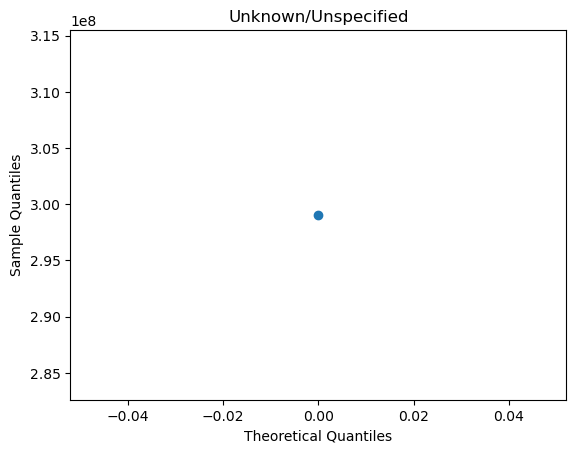

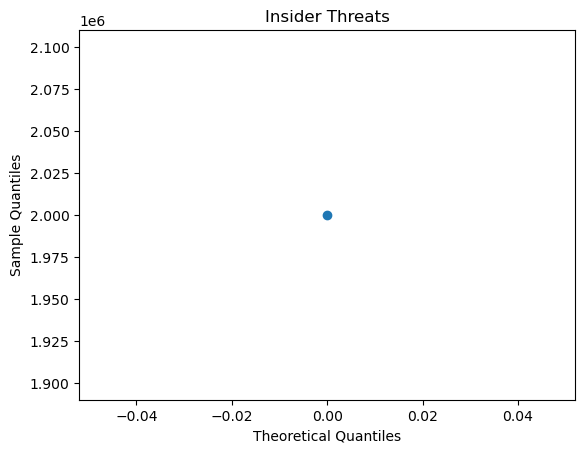

In [1811]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

for category in cleaned_data_telecommunications['method_categories'].unique():
    sm.qqplot(cleaned_data_telecommunications[cleaned_data_telecommunications['method_categories'] == category]['num_records'], line='s')
    plt.title(category)
    plt.show()


In [1812]:
from scipy.stats import levene

group_data = [group['num_records'].values for name, group in cleaned_data_tech.groupby('method_categories')]
levene_test_result = levene(*group_data)
print(levene_test_result)


LeveneResult(statistic=3.952309295425686, pvalue=0.03776223801699458)


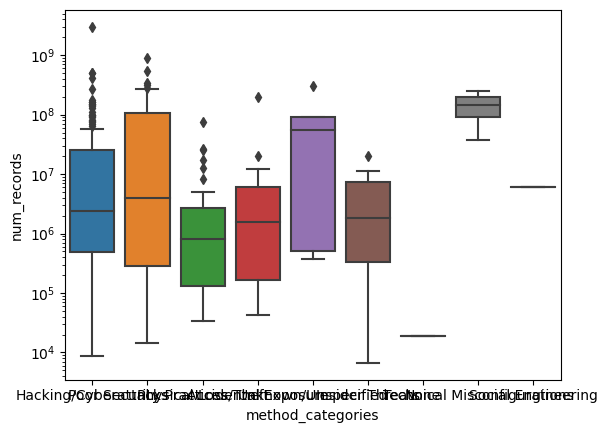

In [1813]:
import seaborn as sns
f, ax = (10, 3)
sns.boxplot(x='method_categories', y='num_records', data=cleaned_data_all)
plt.yscale('log')  # Consider this if there's a wide range of values
plt.show()


In [1814]:
import pandas as pd
from scipy.stats import kruskal

# use a list comprehension to pass the values of each group to the kruskal function
grouped_data = [group['num_records'].dropna() for name, group in cleaned_data_all.groupby('method_categories')]

# perform the Kruskal-Wallis test
kruskal_result = kruskal(*grouped_data)

print(kruskal_result)


KruskalResult(statistic=22.599996927238124, pvalue=0.003917616772474451)


In [1815]:
import pandas as pd
from scipy.stats import kruskal


# use a list comprehension to pass the values of each group to the kruskal function
grouped_data = [group['num_records'].dropna() for name, group in cleaned_data_tech.groupby('method_categories')]

# perform the Kruskal-Wallis test
kruskal_result = kruskal(*grouped_data)

print(kruskal_result)

KruskalResult(statistic=4.68013468013467, pvalue=0.09632115173925118)


In [1816]:
import pandas as pd
from scipy.stats import kruskal

# you can use a list comprehension to pass the values of each group to the kruskal function
grouped_data = [group['num_records'].dropna() for name, group in cleaned_data_telecommunications.groupby('method_categories')]

# perform the Kruskal-Wallis test
kruskal_result = kruskal(*grouped_data)

print(kruskal_result)

KruskalResult(statistic=5.763071895424844, pvalue=0.32995992394512613)


In [1817]:
import scikit_posthocs as sp


# perform the Dunn test
dunn_result = sp.posthoc_dunn(cleaned_data_all, val_col='num_records', group_col='method_categories', p_adjust='holm')

# display the results
print(dunn_result)


                             Accidental Exposure  Hacking/Cyberattacks  \
Accidental Exposure                          1.0              1.000000   
Hacking/Cyberattacks                         1.0              1.000000   
Insider Threats                              1.0              1.000000   
None                                         1.0              1.000000   
Physical Loss/Theft                          1.0              0.026278   
Poor Security Practices                      1.0              1.000000   
Social Engineering                           1.0              1.000000   
Technical Misconfigurations                  1.0              1.000000   
Unknown/Unspecified                          1.0              1.000000   

                             Insider Threats      None  Physical Loss/Theft  \
Accidental Exposure                      1.0  1.000000             1.000000   
Hacking/Cyberattacks                     1.0  1.000000             0.026278   
Insider Threats       

In [1818]:
import scikit_posthocs as sp


# perform the Dunn test
dunn_result = sp.posthoc_dunn(cleaned_data_tech, val_col='num_records', group_col='method_categories', p_adjust='holm')

# display the results
print(dunn_result)

                             Hacking/Cyberattacks  Poor Security Practices  \
Hacking/Cyberattacks                     1.000000                 0.260821   
Poor Security Practices                  0.260821                 1.000000   
Technical Misconfigurations              0.260821                 0.376406   

                             Technical Misconfigurations  
Hacking/Cyberattacks                            0.260821  
Poor Security Practices                         0.376406  
Technical Misconfigurations                     1.000000  


In [1819]:
import scikit_posthocs as sp


# perform the Dunn test
dunn_result = sp.posthoc_dunn(cleaned_data_telecommunications, val_col='num_records', group_col='method_categories', p_adjust='holm')

# display the results
print(dunn_result)

                         Accidental Exposure  Hacking/Cyberattacks  \
Accidental Exposure                      1.0                   1.0   
Hacking/Cyberattacks                     1.0                   1.0   
Insider Threats                          1.0                   1.0   
Physical Loss/Theft                      1.0                   1.0   
Poor Security Practices                  1.0                   1.0   
Unknown/Unspecified                      1.0                   1.0   

                         Insider Threats  Physical Loss/Theft  \
Accidental Exposure                  1.0                  1.0   
Hacking/Cyberattacks                 1.0                  1.0   
Insider Threats                      1.0                  1.0   
Physical Loss/Theft                  1.0                  1.0   
Poor Security Practices              1.0                  1.0   
Unknown/Unspecified                  1.0                  1.0   

                         Poor Security Practices  Unk

In [1820]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# rank transformation of the dependent variable
cleaned_data_all['num_records_rank'] = cleaned_data_all['num_records'].rank()

# perform two-way ANOVA on the ranked data
model = ols('num_records_rank ~ C(org_categories) * C(method_categories)', data=cleaned_data_all).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)


                                              sum_sq     df             F  \
C(org_categories)                       2.386648e+04   12.0  3.037616e-01   
C(method_categories)                    2.511295e-08    8.0  4.794392e-13   
C(org_categories):C(method_categories)  9.698552e+05   96.0  1.542984e+00   
Residual                                1.649965e+06  252.0           NaN   

                                          PR(>F)  
C(org_categories)                       0.582022  
C(method_categories)                    1.000000  
C(org_categories):C(method_categories)  0.022484  
Residual                                     NaN  


/var/folders/k8/29hfdmd56bs96xy1njxlppjc0000gn/T/ipykernel_54341/1149476595.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data_all['num_records_rank'] = cleaned_data_all['num_records'].rank()
/Users/mollyscally/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/mollyscally/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/mollyscally/

Text(0.5, 1.0, 'num_records with log transformation')

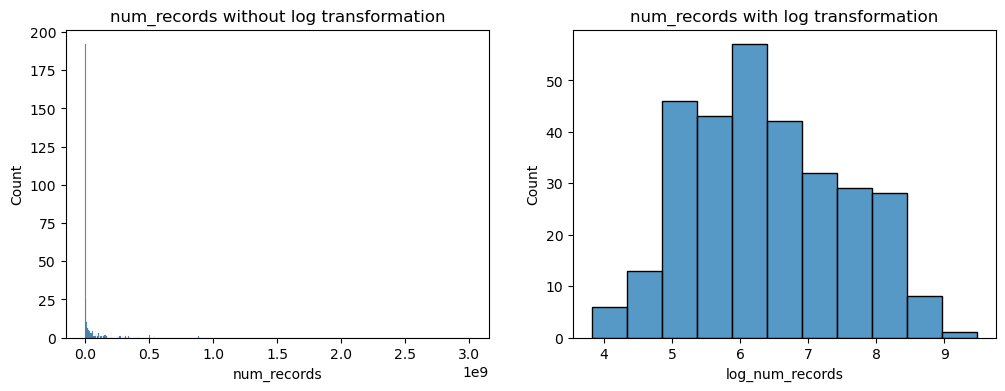

In [1821]:
# 
f, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(x='num_records', data=cleaned_data_all,  ax=ax[0])
ax[0].set_title('num_records without log transformation')

sns.histplot(x='log_num_records', data=cleaned_data_all,  ax=ax[1])
ax[1].set_title('num_records with log transformation')

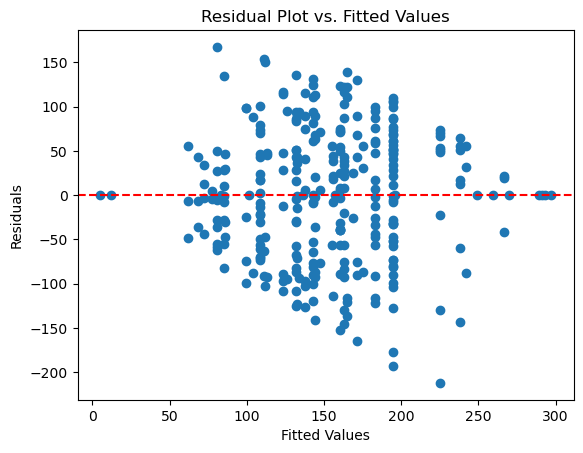

In [1822]:
import matplotlib.pyplot as plt

# residual plot
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot vs. Fitted Values")
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.show()


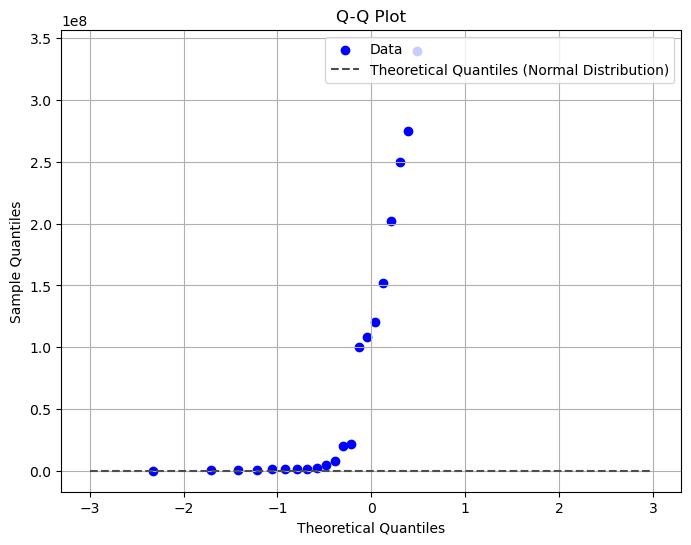

In [1823]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

sorted_data = np.sort(tech['num_records'])
n = len(sorted_data)  # get the number of data points
theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, n))

plt.figure(figsize=(8, 6))
plt.scatter(theoretical_quantiles, sorted_data, c='b', marker='o', label='Data')
plt.plot([-3, 3], [-3, 3], ls="--", c=".3", label="Theoretical Quantiles (Normal Distribution)")
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot')
plt.legend()
plt.grid(True)
plt.show()


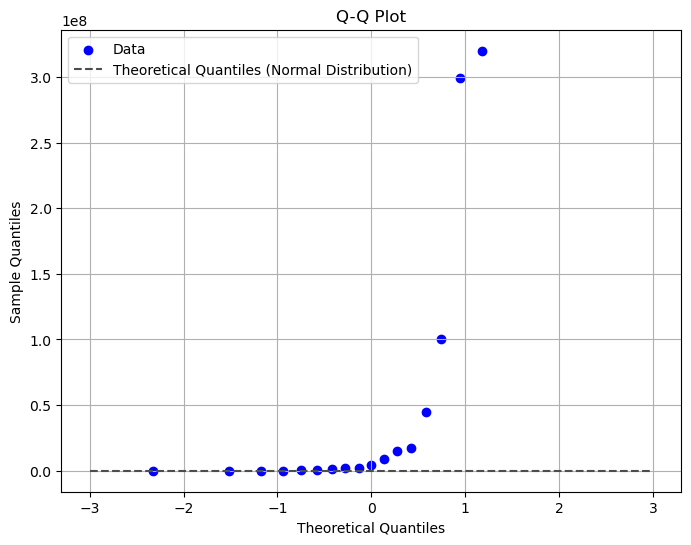

In [1824]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

sorted_data = np.sort(telecommunications['num_records'])
n = len(sorted_data)  # get the number of data points
theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, n))

plt.figure(figsize=(8, 6))
plt.scatter(theoretical_quantiles, sorted_data, c='b', marker='o', label='Data')
plt.plot([-3, 3], [-3, 3], ls="--", c=".3", label="Theoretical Quantiles (Normal Distribution)")
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot')
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='num_records', ylabel='Count'>

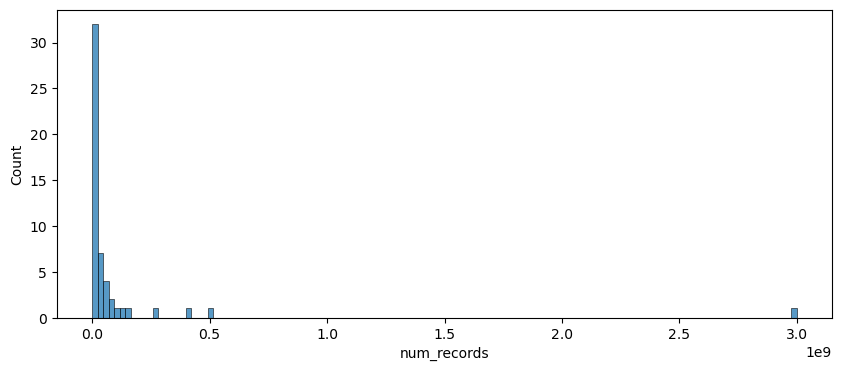

In [1825]:

f, ax = plt.subplots(figsize=(10, 4))

palette = sns.color_palette("colorblind", 25)

sns.histplot(x='num_records', data=web, ax=ax)

In [1826]:
data_breaches.query("`Organization type` == 'Clinical Laboratory'")

Entity  Year   Records    Organization type         Method  \
227  Quest Diagnostics  2019  11900000  Clinical Laboratory  poor security   

    Sources  num_records  num_year non_numeric_records  ln_num_records  \
227   [279]   11900000.0      2019                 NaN       16.292049   

     log_num_records       org_categories        method_categories  \
227         7.075547  Healthcare/Wellness  Poor Security Practices   

          hacked  
227  Non-Hacking

In [1827]:
hacking = data_breaches.query("hacked == 'Hacking'")
nonhacking = data_breaches.query("hacked == 'Non-Hacking'")

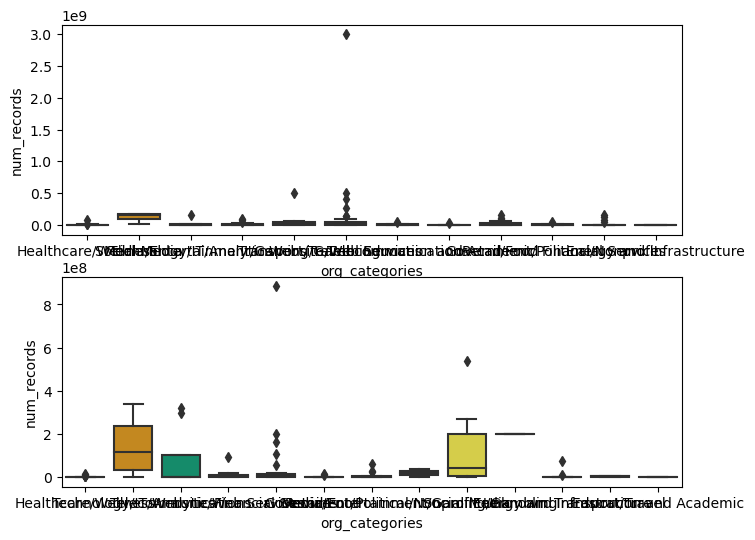

In [1828]:
# 
f, ax = plt.subplots(2, 1, figsize=(8, 6))

sns.boxplot(x='org_categories', y='num_records', data=hacking,  palette=palette,  ax=ax[0])
ax[0].set_title('')

sns.boxplot(x='org_categories', y='num_records', data=nonhacking,  palette=palette,  ax=ax[1])
ax[1].set_title('')

plt.show()

In [1829]:
# replace '2014 and 2015' with '2014' at index 144
#data_breaches.loc[83, 'Method'] = 'hacked'

In [1830]:
tech.query("method_categories == 'Hacking/Cyberattacks'")

Entity  Year                  Records  \
3    Adobe Systems Incorporated  2013                152000000   
20                        Apple  2021                   275000   
66                 Clearview AI  2020    unknown (client list)   
77                   CyberServe  2021                  1107034   
93             Dun & Bradstreet  2013                  1000000   
119                     FireEye  2020                  Unknown   
165    Kroll Background America  2013                  1000000   
167                  LexisNexis  2014                  1000000   
185  Microsoft Exchange servers  2021                  unknown   
203           Network Solutions  2009                   573000   
223                      PayPay  2020                 20076016   
243                    ShopBack  2020                  unknown   
247                    SnapChat  2013                  4700000   
248                  SolarWinds  2020  Source Code Compromised   
288                      Twitch  2015                  unknown   
289                      Twitch  2021                  unknown   
295                      Ubuntu  2013                  2000000   
342                 Yahoo Japan  2013                 22000000   

          Organization type                    Method          Sources  \
3                      tech                    hacked             [10]   
20                     tech                    hacked             [33]   
66   information technology                    hacked     [87][88][89]   
77         hosting provider                    hacked         [98][99]   
93                     tech                    hacked       [117][118]   
119    Information Security                    hacked  [154][155][156]   
165                    tech                    hacked       [117][118]   
167                    tech                    hacked       [117][118]   
185                software  zero-day vulnerabilities            [241]   
203                    tech                    hacked       [259][260]   
223         QR code payment  improper setting, hacked            [276]   
243                    tech                    hacked            [296]   
247               web, tech                    hacked            [300]   
248      Network Monitoring                    hacked            [301]   
288                    tech                    hacked            [346]   
289                    tech   hacked/misconfiguration            [347]   
295                    tech                    hacked            [352]   
342               tech, web                    hacked            [402]   

     num_records  num_year      non_numeric_records  ln_num_records  \
3    152000000.0      2013                      NaN       18.839391   
20      275000.0      2021                      NaN       12.524526   
66           NaN      2020    unknown (client list)             NaN   
77     1107034.0      2021                      NaN       13.917195   
93     1000000.0      2013                      NaN       13.815511   
119          NaN      2020                  Unknown             NaN   
165    1000000.0      2013                      NaN       13.815511   
167    1000000.0      2014                      NaN       13.815511   
185          NaN      2021                  unknown             NaN   
203     573000.0      2009                      NaN       13.258641   
223   20076016.0      2020                      NaN       16.815036   
243          NaN      2020                  unknown             NaN   
247    4700000.0      2013                      NaN       15.363073   
248          NaN      2020  Source Code Compromised             NaN   
288          NaN      2015                  unknown             NaN   
289          NaN      2021                  unknown             NaN   
295    2000000.0      2013                      NaN       14.508658   
342   22000000.0      2013                      NaN       16.906553   

     log_num_

<Axes: xlabel='Year', ylabel='count'>

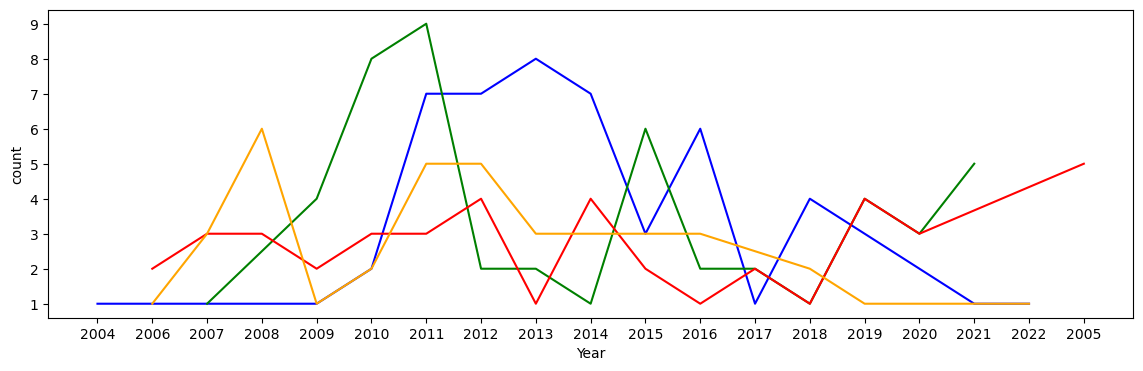

In [1831]:
f, ax = plt.subplots(figsize=(14, 4))

palette = sns.color_palette("colorblind", 25)

sns.lineplot(x='Year', y='count', data=web_breach_counts, color="blue", ax=ax)
sns.lineplot(x='Year', y='count', data=healthcare_breach_counts, color="green", ax=ax)
sns.lineplot(x='Year', y='count', data=financial_breach_counts, color="red", ax=ax)
sns.lineplot(x='Year', y='count', data=government_breach_counts, color="orange", ax=ax)

<Axes: xlabel='Year', ylabel='Hacking'>

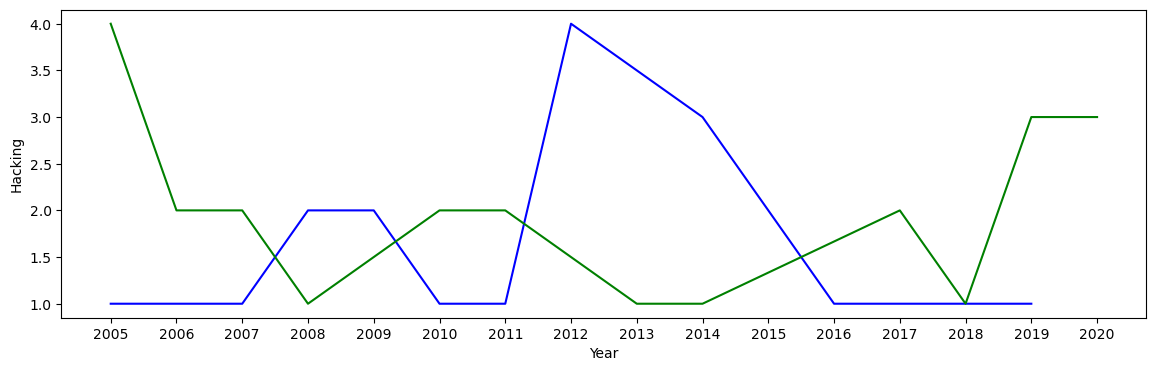

In [1832]:
f, ax = plt.subplots(figsize=(14, 4))

palette = sns.color_palette("colorblind", 25)

sns.lineplot(x='Year', y='Hacking', data=financial_counts2, color="blue", ax=ax)
sns.lineplot(x='Year', y='Non-Hacking', data=financial_counts2, color="green", ax=ax)

<Axes: xlabel='Year', ylabel='Hacking'>

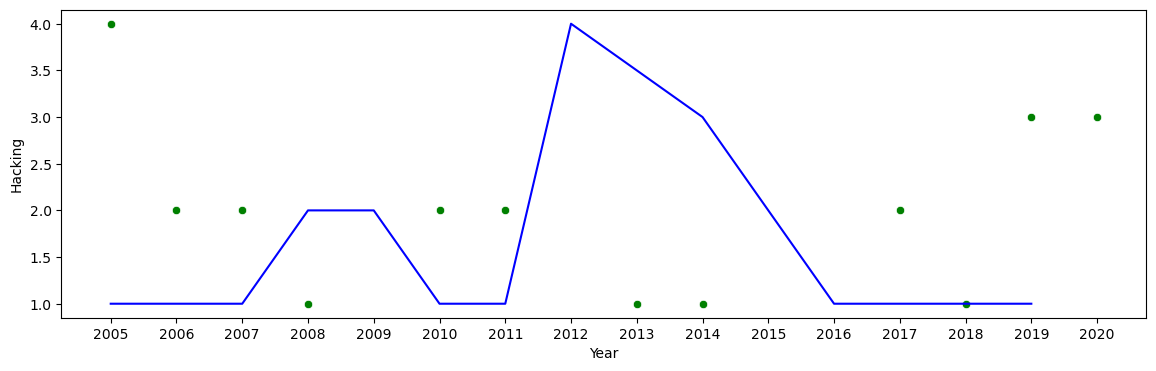

In [1833]:
f, ax = plt.subplots(figsize=(14, 4))

palette = sns.color_palette("colorblind", 25)

sns.lineplot(x='Year', y='Hacking', data=financial_counts2, color="blue", ax=ax)
sns.scatterplot(x='Year', y='Non-Hacking', data=financial_counts2, color="green", ax=ax)

<Axes: xlabel='Year', ylabel='Hacking'>

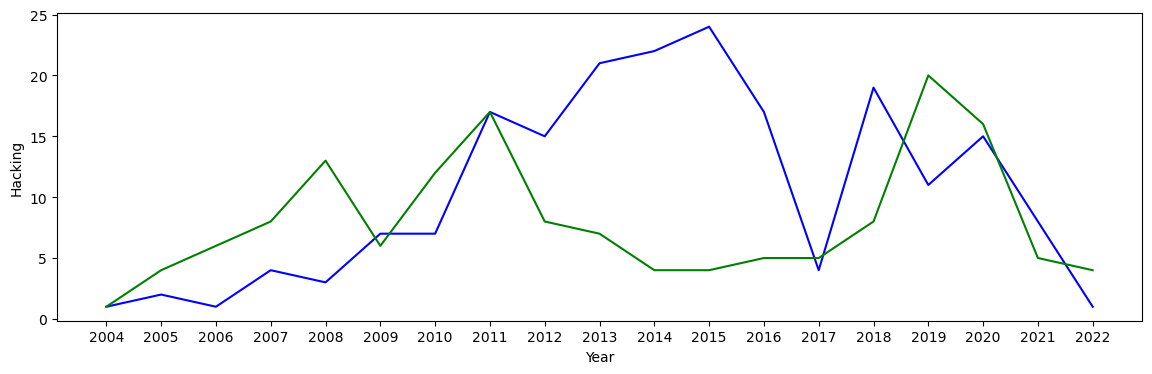

In [1834]:
f, ax = plt.subplots(figsize=(14, 4))

palette = sns.color_palette("colorblind", 25)

sns.lineplot(x='Year', y='Hacking', data=data_breaches_counts2, color="blue", ax=ax)
sns.lineplot(x='Year', y='Non-Hacking', data=data_breaches_counts2, color="green", ax=ax)

In [1835]:
method_cat_counts = data_breaches['method_categories'].value_counts()
method_cat_counts

Hacking/Cyberattacks           199
Physical Loss/Theft             50
Poor Security Practices         49
Accidental Exposure             23
Insider Threats                 20
Unknown/Unspecified              7
Technical Misconfigurations      2
None                             1
Social Engineering               1
Name: method_categories, dtype: int64

In [1836]:
hacking = data_breaches.query("method_categories == 'Hacking/Cyberattacks'")
physical = data_breaches.query("method_categories == 'Physical Loss/Theft'")
poor_security = data_breaches.query("method_categories == 'Poor Security Practices'")
accidental_exp = data_breaches.query("method_categories == 'Accidental Exposure'")
insider = data_breaches.query("method_categories == 'Insider Threats'")
misconfig = data_breaches.query("method_categories == 'Technical Misconfigurations'")

In [1837]:
web_breach_counts = web.groupby('Year').size().reset_index(name='count')
healthcare_breach_counts = healthcare.groupby('Year').size().reset_index(name='count')
financial_breach_counts = financial.groupby('Year').size().reset_index(name='count')
government_breach_counts = government.groupby('Year').size().reset_index(name='count')
retail_breach_counts = retail.groupby('Year').size().reset_index(name='count')
tech_breach_counts = tech.groupby('Year').size().reset_index(name='count')
media_breach_counts = media.groupby('Year').size().reset_index(name='count')
healthcare_breach_counts = healthcare.groupby('Year').size().reset_index(name='count')

In [1838]:
hacking_counts = hacking.groupby('num_year').size().reset_index(name='count')
physical_counts = physical.groupby('num_year').size().reset_index(name='count')
poor_security_counts = poor_security.groupby('num_year').size().reset_index(name='count')
accidental_exp_counts = accidental_exp.groupby('num_year').size().reset_index(name='count')
insider_counts = insider.groupby('num_year').size().reset_index(name='count')
misconfig_counts = misconfig.groupby('num_year').size().reset_index(name='count')
media_breach_counts = media.groupby('num_year').size().reset_index(name='count')
healthcare_breach_counts = healthcare.groupby('num_year').size().reset_index(name='count')

In [1839]:
hacking_tech = tech.query("method_categories == 'Hacking/Cyberattacks'")
physical_tech = tech.query("method_categories == 'Physical Loss/Theft'")
poor_security_tech = tech.query("method_categories == 'Poor Security Practices'")
accidental_exp_tech = tech.query("method_categories == 'Accidental Exposure'")
insider_tech = tech.query("method_categories == 'Insider Threats'")
misconfig_tech = tech.query("method_categories == 'Technical Misconfigurations'")

In [1840]:
physical_tech

Entity  Year  Records Organization type                  Method Sources  \
109  EyeWire  2016  unknown              tech  lost / stolen computer   [138]   

     num_records  num_year non_numeric_records  ln_num_records  \
109          NaN      2016             unknown             NaN   

     log_num_records           org_categories    method_categories  
109              NaN  Technology/IT/Analytics  Physical Loss/Theft

In [1841]:
hacking_counts_tech = hacking_tech.groupby('num_year').size().reset_index(name='count')
physical_counts_tech = physical_tech.groupby('num_year').size().reset_index(name='count')
poor_security_counts_tech = poor_security_tech.groupby('num_year').size().reset_index(name='count')
accidental_exp_counts_tech = accidental_exp_tech.groupby('num_year').size().reset_index(name='count')
insider_counts_tech = insider_tech.groupby('num_year').size().reset_index(name='count')
misconfig_counts_tech = misconfig_tech.groupby('num_year').size().reset_index(name='count')

<Axes: xlabel='num_year', ylabel='count'>

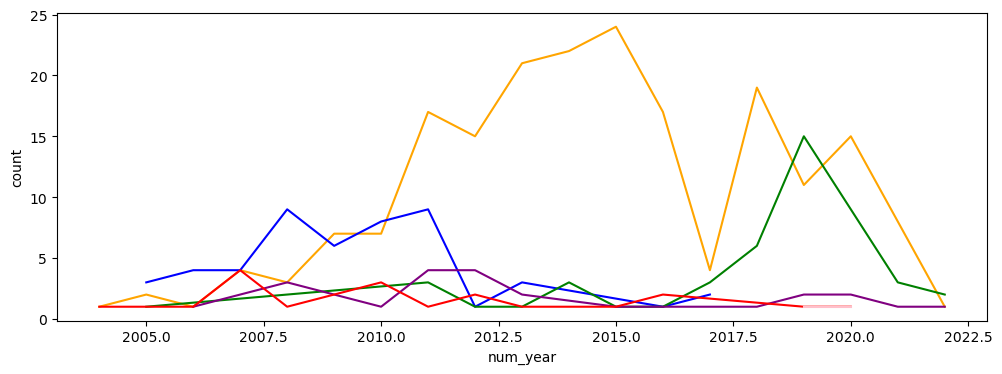

In [1842]:
f, ax = plt.subplots(figsize=(12, 4))

palette = sns.color_palette("colorblind", 25)

sns.lineplot(x='num_year', y='count', data=hacking_counts, color="orange", ax=ax)
sns.lineplot(x='num_year', y='count', data=physical_counts, color="blue", ax=ax)
sns.lineplot(x='num_year', y='count', data=poor_security_counts, color="green", ax=ax)
sns.lineplot(x='num_year', y='count', data=accidental_exp_counts, color="purple", ax=ax)
sns.lineplot(x='num_year', y='count', data=insider_counts, color="red", ax=ax)
sns.lineplot(x='num_year', y='count', data=misconfig_counts, color="pink", ax=ax)

<Axes: xlabel='num_year', ylabel='count'>

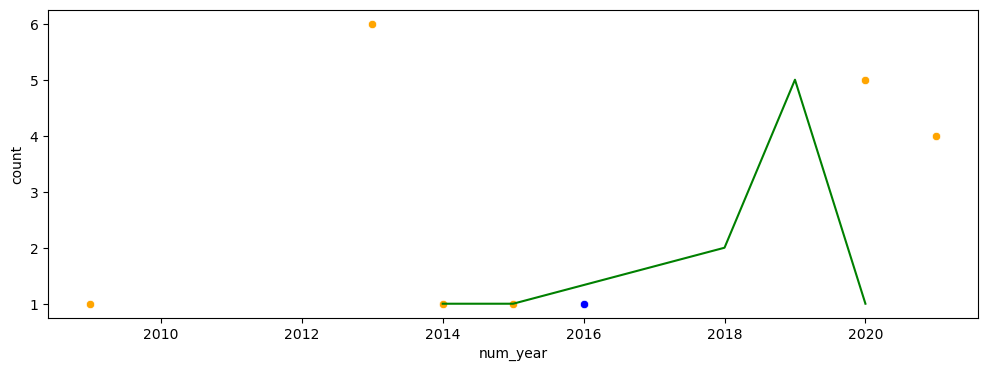

In [1843]:
f, ax = plt.subplots(figsize=(12, 4))

palette = sns.color_palette("colorblind", 25)

sns.scatterplot(x='num_year', y='count', data=hacking_counts_tech, color="orange", ax=ax)
sns.scatterplot(x='num_year', y='count', data=physical_counts_tech, color="blue", ax=ax)
sns.lineplot(x='num_year', y='count', data=poor_security_counts_tech, color="green", ax=ax)
sns.lineplot(x='num_year', y='count', data=accidental_exp_counts_tech, color="purple", ax=ax)
sns.lineplot(x='num_year', y='count', data=insider_counts_tech, color="red", ax=ax)
sns.lineplot(x='num_year', y='count', data=misconfig_counts_tech, color="pink", ax=ax)

In [1844]:
counts2 = data_breaches.groupby(['num_year', 'num_records']).size().reset_index(name='count')
#counts2 = counts2.pivot(index='num_year', columns='num_records', values='count').reset_index()
counts2.columns.name = None 
counts2

num_year  num_records  count
0        2004     510000.0      1
1        2004   92000000.0      1
2        2005     125000.0      1
3        2005     200000.0      1
4        2005    1200000.0      1
..        ...          ...    ...
287      2022      95000.0      1
288      2022     515000.0      1
289      2022    1300000.0      1
290      2022    1648922.0      1
291      2022    6400000.0      1

[292 rows x 3 columns]

In [1845]:
counts2 = data_breaches.groupby(['num_year', 'num_records']).size().reset_index(name='count')
counts2.columns.name = None 
counts2

num_year  num_records  count
0        2004     510000.0      1
1        2004   92000000.0      1
2        2005     125000.0      1
3        2005     200000.0      1
4        2005    1200000.0      1
..        ...          ...    ...
287      2022      95000.0      1
288      2022     515000.0      1
289      2022    1300000.0      1
290      2022    1648922.0      1
291      2022    6400000.0      1

[292 rows x 3 columns]

In [1846]:
# group by 'num_year' and sum 'num_records'
sum_records = data_breaches.groupby('num_year')['num_records'].sum().reset_index()
# rename the 'num_records' column to 'sum_num_records'
sum_records.rename(columns={'num_records': 'sum_num_records'}, inplace=True)
sum_records

num_year  sum_num_records
0       2004     9.251000e+07
1       2005     4.682500e+07
2       2006     7.126000e+07
3       2007     1.532864e+08
4       2008     6.906650e+07
5       2009     2.554680e+08
6       2010     1.598048e+07
7       2011     2.277881e+08
8       2012     4.288396e+08
9       2013     3.469435e+09
10      2014     8.513410e+08
11      2015     2.016545e+08
12      2016     5.405824e+08
13      2017     2.547669e+08
14      2018     1.531850e+09
15      2019     3.824901e+09
16      2020     1.251422e+09
17      2021     6.139627e+07
18      2022     9.958922e+06

In [1847]:
# group by 'num_year' and sum 'num_records'
non_numeric_records = non_numeric.groupby('num_year')['non_numeric_records'].sum().reset_index()
non_numeric_records

num_year                                non_numeric_records
0       2011                                            unknown
1       2012                                          63 stores
2       2013                                 undisclosedunknown
3       2014  unknown10 locationsunknown100 terabytes200 sto...
4       2015  G20 world leaderstens of thousandsmillions250 ...
5       2016                       unknownunknownunknownunknown
6       2017                      235 GB350 clients emails2.5GB
7       2018                                     unknownunknown
8       2019  unknown19 years of dataover 5,000,0009,000,000...
9       2020  unknownunknown (client list)Unknownunknownunkn...
10      2021                       unknownunknownunknownunknown

In [1848]:
non_numeric

Entity  Year  \
10                                   Amazon Japan G.K.  2019   
25                                               Atraf  2021   
27                   Australian Immigration Department  2015   
28                      Australian National University  2019   
34                                      Barnes & Noble  2012   
41                                       Betsson Group  2020   
47                                     British Airways  2015   
48                  2019 Bulgarian revenue agency hack  2019   
66                                        Clearview AI  2020   
76                                                 CVS  2015   
80        Defense Integrated Data Center (South Korea)  2017   
82                                            Deloitte  2017   
94                                             EasyJet  2019   
104                              European Central Bank  2014   
109                                            EyeWire  2016   
119                                            FireEye  2020   
134                                               Gyft  2016   
140                           Health Service Executive  2021   
142                                   Heathrow Airport  2017   
147                                       Hyatt Hotels  2015   
163                                       Koodo Mobile  2020   
168                                     Landry's, Inc.  2015   
175                           Mandarin Oriental Hotels  2014   
185                         Microsoft Exchange servers  2021   
198                                             NASDAQ  2014   
199                                    Natural Grocers  2015   
215                                              Ofcom  2016   
220                Oregon Department of Transportation  2011   
221                                                OVH  2013   
232                                             Reddit  2018   
235                                       Rosen Hotels  2016   
243                                           ShopBack  2020   
248                                         SolarWinds  2020   
251                                      Sony Pictures  2014   
260  Starwoodincluding Westin Hotels & Resorts and ...  2015   
265                                          Supervalu  2014   
286                                       Trump Hotels  2014   
288                                             Twitch  2015   
289                                             Twitch  2021   
291                                           Typeform  2018   
294                                            Ubisoft  2013   
310                                                UPS  2014   
315  U.S. federal government (2020 United States fe...  2020   
334                                            Wendy's  2015   
336                               Woodruff Arts Center  2019   

                                               Records  \
10                                             unknown   
25                                             unknown   
27                                   G20 world leaders   
28                                    19 years of data   
34                                           63 stores   
41                                             unknown   
47                                   tens of thousands   
48                                      over 5,000,000   
66                               unknown (client list)   
76                                            millions   
80                                              235 GB   
82                                  350 clients emails   
94   9,000,000 (approx) - basic booking, 2208 (cred...   
104                                            unknown   
109                                            unknown   
119                                            Unknown   
134                                            unknown   
140                                            unknown   
1

In [1849]:
# convert all elements to strings, group by 'num_year', and join the strings with commas
all_records = non_numeric.astype({'non_numeric_records': str}).groupby('num_year')['non_numeric_records'].apply(lambda x: ','.join(x)).reset_index()

# reset the index to have a clean DataFrame
all_records.reset_index(drop=True, inplace=True)
all_records

num_year                                non_numeric_records
0       2011                                            unknown
1       2012                                          63 stores
2       2013                                undisclosed,unknown
3       2014  unknown,10 locations,unknown,100 terabytes,200...
4       2015  G20 world leaders,tens of thousands,millions,2...
5       2016                    unknown,unknown,unknown,unknown
6       2017                    235 GB,350 clients emails,2.5GB
7       2018                                    unknown,unknown
8       2019  unknown,19 years of data,over 5,000,000,9,000,...
9       2020  unknown,unknown (client list),Unknown,unknown,...
10      2021                    unknown,unknown,unknown,unknown

In [1850]:
merged_df = pd.merge(sum_records, all_records, how='left', on='num_year')
merged_df.rename(columns={'num_year': 'Year'}, inplace=True)
merged_df

Year  sum_num_records                                non_numeric_records
0   2004     9.251000e+07                                                NaN
1   2005     4.682500e+07                                                NaN
2   2006     7.126000e+07                                                NaN
3   2007     1.532864e+08                                                NaN
4   2008     6.906650e+07                                                NaN
5   2009     2.554680e+08                                                NaN
6   2010     1.598048e+07                                                NaN
7   2011     2.277881e+08                                            unknown
8   2012     4.288396e+08                                          63 stores
9   2013     3.469435e+09                                undisclosed,unknown
10  2014     8.513410e+08  unknown,10 locations,unknown,100 terabytes,200...
11  2015     2.016545e+08  G20 world leaders,tens of thousands,millions,2...
12  2016     5.405824e+08                    unknown,unknown,unknown,unknown
13  2017     2.547669e+08                    235 GB,350 clients emails,2.5GB
14  2018     1.531850e+09                                    unknown,unknown
15  2019     3.824901e+09  unknown,19 years of data,over 5,000,000,9,000,...
16  2020     1.251422e+09  unknown,unknown (client list),Unknown,unknown,...
17  2021     6.139627e+07                    unknown,unknown,unknown,unknown
18  2022     9.958922e+06                                                NaN

In [1851]:
# list the years in the data, in order
year_counts = data_breaches.groupby('Year').size().reset_index(name='num_breaches')
year_counts

Year  num_breaches
0   2004             2
1   2005             6
2   2006             7
3   2007            12
4   2008            16
5   2009            13
6   2010            19
7   2011            34
8   2012            23
9   2013            28
10  2014            26
11  2015            28
12  2016            22
13  2017             9
14  2018            27
15  2019            31
16  2020            31
17  2021            13
18  2022             5

all_counts = pd.merge(year_counts, merged_df, how='left', on='Year')
all_counts

In [1852]:
year_counts['Year'] = year_counts['Year'].astype(int)
merged_df['Year'] = merged_df['Year'].astype(int)
all_counts = pd.merge(year_counts, merged_df, how='left', on='Year')
all_counts

Year  num_breaches  sum_num_records  \
0   2004             2     9.251000e+07   
1   2005             6     4.682500e+07   
2   2006             7     7.126000e+07   
3   2007            12     1.532864e+08   
4   2008            16     6.906650e+07   
5   2009            13     2.554680e+08   
6   2010            19     1.598048e+07   
7   2011            34     2.277881e+08   
8   2012            23     4.288396e+08   
9   2013            28     3.469435e+09   
10  2014            26     8.513410e+08   
11  2015            28     2.016545e+08   
12  2016            22     5.405824e+08   
13  2017             9     2.547669e+08   
14  2018            27     1.531850e+09   
15  2019            31     3.824901e+09   
16  2020            31     1.251422e+09   
17  2021            13     6.139627e+07   
18  2022             5     9.958922e+06   

                                  non_numeric_records  
0                                                 NaN  
1                                                 NaN  
2                                                 NaN  
3                                                 NaN  
4                                                 NaN  
5                                                 NaN  
6                                                 NaN  
7                                             unknown  
8                                           63 stores  
9                                 undisclosed,unknown  
10  unknown,10 locations,unknown,100 terabytes,200...  
11  G20 world leaders,tens of thousands,millions,2...  
12                    unknown,unknown,unknown,unknown  
13                    235 GB,350 clients emails,2.5GB  
14                                    unknown,unknown  
15  unknown,19 years of data,over 5,000,000,9,000,...  
16  unknown,unknown (client list),Unknown,unknown,...  
17                    unknown,unknown,unknown,unknown  
18                                                NaN

In [1853]:
all_counts.loc[16, 'non_numeric_records']


'unknown,unknown (client list),Unknown,unknown,unknown,Source Code Compromised,TBC'

In [1854]:
# create a dictionary to add as a new column
new_column_data = {'all': [str(year) for year in range(2004, 2023)] }

# add the new column to the DataFrame
all_counts1['all'] = new_column_data['all']

In [1855]:
# 
all_counts.loc[0, 'all'] = '92,510,000 records'
all_counts.loc[1, 'all'] = '46,825,000 records'
all_counts.loc[2, 'all'] = '71,260,000 records'
all_counts.loc[3, 'all'] = '153,286,405 records'
all_counts.loc[4, 'all'] = '69,066,500 records'
all_counts.loc[5, 'all'] = '255,467,987 records'
all_counts.loc[6, 'all'] = '15,980,476 records'
all_counts.loc[7, 'all'] = '227,788,137 records + one unknown'
all_counts.loc[8, 'all'] = '428,839,635 records + 63 stores'
all_counts.loc[9, 'all'] = '3,469,434,877 records + one undisclosed + one unknown'
all_counts.loc[10, 'all'] = '851,341,000 records + 100 terabytes + 4 by location (one for 200 stores + one for 10 locations + one for 8 locations + one for 51 locations) + two unknown'
all_counts.loc[11, 'all'] = '201,654,459 records + G20 world leaders + 4 by location (one for 250 locations + one for 500 locations + one for 93 stores + one for 54 locations) + two unknown (one for approx. tens of thousands + one for approx. millions) + two completely unknown'
all_counts.loc[12, 'all'] = '540,582,363 records + four unknown'
all_counts.loc[13, 'all'] = '254,766,877 records + one for 235 GB + one for 2.5 GB + 350 client emails'
all_counts.loc[14, 'all'] = '1,531,849,832 records + two unknown'
all_counts.loc[15, 'all'] = '3,824,900,831 records + 19 years of data + 2 unknown (one for over 5,000,000 + one for approx. 9,000,000 basic booking, and 2,208 with credit card details) + two completely unknown'
all_counts.loc[16, 'all'] = '1,251,422,083 records + source code compromised + 6 unknown (one for a client list in an unknown amount + five completely unknown)'
all_counts.loc[17, 'all'] = '61,396,26 records + four unknown'
all_counts.loc[18, 'all'] = '9,958,922 records'


In [1856]:
all_counts

Year  num_breaches  sum_num_records  \
0   2004             2     9.251000e+07   
1   2005             6     4.682500e+07   
2   2006             7     7.126000e+07   
3   2007            12     1.532864e+08   
4   2008            16     6.906650e+07   
5   2009            13     2.554680e+08   
6   2010            19     1.598048e+07   
7   2011            34     2.277881e+08   
8   2012            23     4.288396e+08   
9   2013            28     3.469435e+09   
10  2014            26     8.513410e+08   
11  2015            28     2.016545e+08   
12  2016            22     5.405824e+08   
13  2017             9     2.547669e+08   
14  2018            27     1.531850e+09   
15  2019            31     3.824901e+09   
16  2020            31     1.251422e+09   
17  2021            13     6.139627e+07   
18  2022             5     9.958922e+06   

                                  non_numeric_records  \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                                                 NaN   
6                                                 NaN   
7                                             unknown   
8                                           63 stores   
9                                 undisclosed,unknown   
10  unknown,10 locations,unknown,100 terabytes,200...   
11  G20 world leaders,tens of thousands,millions,2...   
12                    unknown,unknown,unknown,unknown   
13                    235 GB,350 clients emails,2.5GB   
14                                    unknown,unknown   
15  unknown,19 years of data,over 5,000,000,9,000,...   
16  unknown,unknown (client list),Unknown,unknown,...   
17                    unknown,unknown,unknown,unknown   
18                                                NaN   

                                                  all  
0                                  92,510,000 records  
1                                  46,825,000 records  
2                                  71,260,000 records  
3                                 153,286,405 records  
4                                  69,066,500 records  
5                                 255,467,987 records  
6                                  15,980,476 records  
7                   227,788,137 records + one unknown  
8                     428,839,635 records + 63 stores  
9   3,469,434,877 records + one undisclosed + one ...  
10  851,341,000 records + 100 terabytes + 4 by loc...  
11  201,654,459 records + G20 world leaders + 4 by...  
12                 540,582,363 records + four unknown  
13  254,766,877 records + one for 235 GB + one for...  
14                1,531,849,832 records + two unknown  
15  3,824,900,831 records + 19 years of data + 2 u...  
16  1,251,422,083 records + source code compromise...  
17                   61,396,26 records + four unknown  
18                                  9,958,922 records

In [1857]:
# group by 'num_year' and sum 'num_records'
hacking_sum_records = hacking.groupby('num_year')['num_records'].sum().reset_index()
# rename the 'num_records' column to 'sum_num_records'
hacking_sum_records.rename(columns={'num_records': 'sum_num_records'}, inplace=True)

# group by 'num_year' and sum 'num_records'
physical_sum_records = physical.groupby('num_year')['num_records'].sum().reset_index()
# rename the 'num_records' column to 'sum_num_records'
physical_sum_records.rename(columns={'num_records': 'sum_num_records'}, inplace=True)

<Axes: xlabel='num_year', ylabel='sum_num_records'>

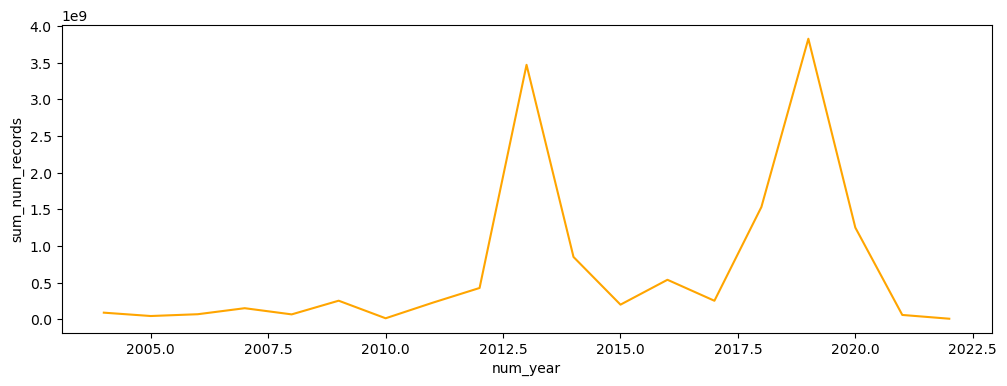

In [1858]:
f, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(x='num_year', y='sum_num_records', data=sum_records, color="orange", ax=ax)

<Axes: xlabel='num_year', ylabel='sum_num_records'>

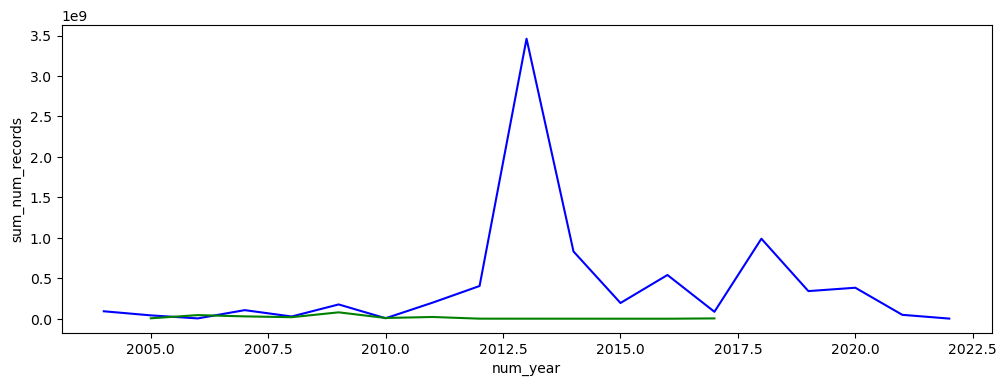

In [1859]:
f, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(x='num_year', y='sum_num_records', data=hacking_sum_records, color="blue", ax=ax)
sns.lineplot(x='num_year', y='sum_num_records', data=physical_sum_records, color="green", ax=ax)

<Axes: xlabel='num_year', ylabel='num_records'>

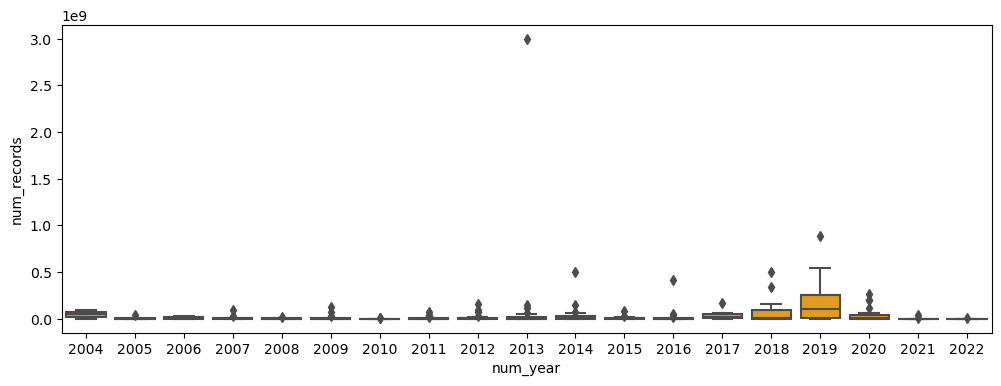

In [1860]:
f, ax = plt.subplots(figsize=(12, 4))

sns.boxplot(x='num_year', y='num_records', data=counts2, color="orange", ax=ax)

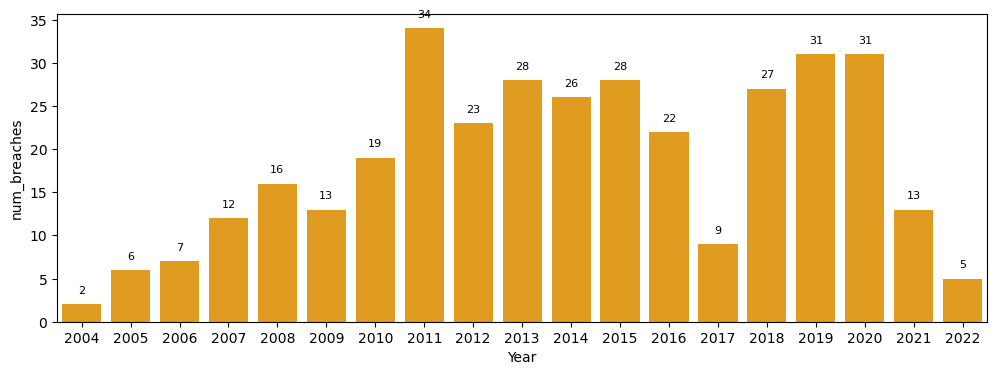

In [1861]:
f, ax = plt.subplots(figsize=(12, 4))

bar_plot_yearly_records = sns.barplot(x='Year', y='num_breaches', data=all_counts, color="orange", ax=ax)
# add annotations on top of each bar
for p in bar_plot_yearly_records.patches:
    bar_plot_yearly_records.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                                     ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

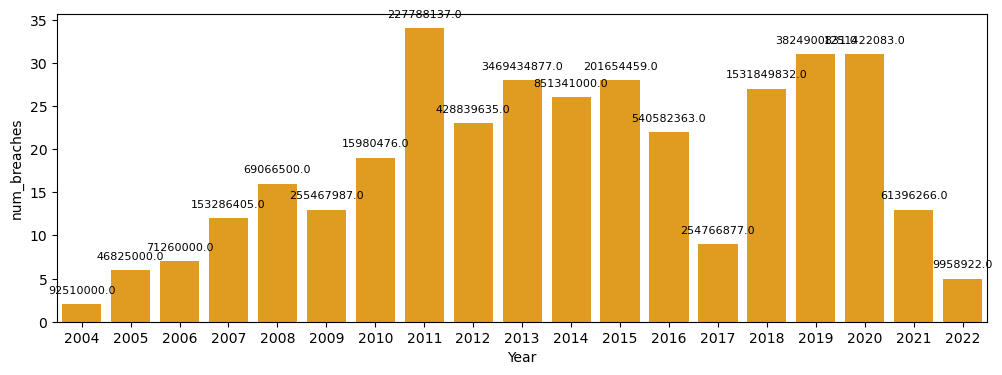

In [1862]:
f, ax = plt.subplots(figsize=(12, 4))

# create bar plot
bar_plot = sns.barplot(x='Year', y='num_breaches', data=all_counts, color="orange", ax=ax)

# iterate over the bars and annotate with values from another column
for p, value in zip(bar_plot.patches, all_counts['sum_num_records']):
    ax.annotate(f'{value}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=8)


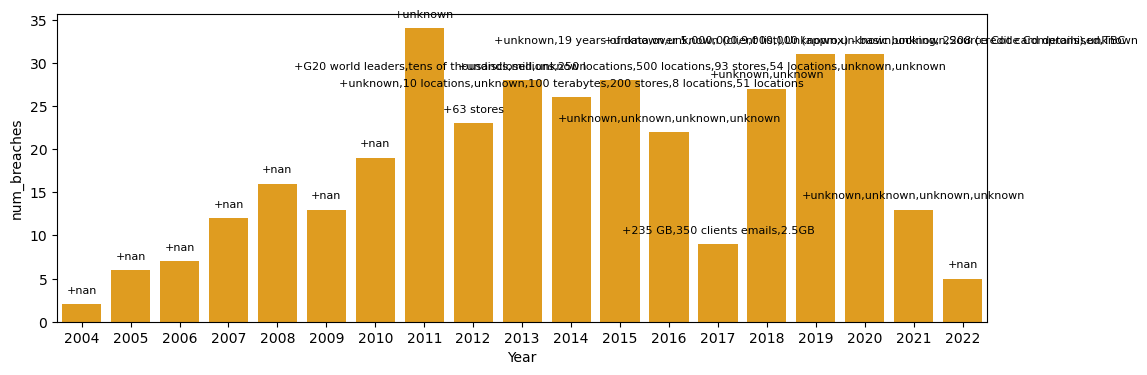

In [1863]:
f, ax = plt.subplots(figsize=(12, 4))

# create bar plot
bar_plot = sns.barplot(x='Year', y='num_breaches', data=all_counts, color="orange", ax=ax)

# iterate over the bars and annotate with values from 'additional_value' column
for p, add_value in zip(bar_plot.patches, all_counts['non_numeric_records']):
    annotation_text = f'+{add_value}'
    ax.annotate(annotation_text,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=8)


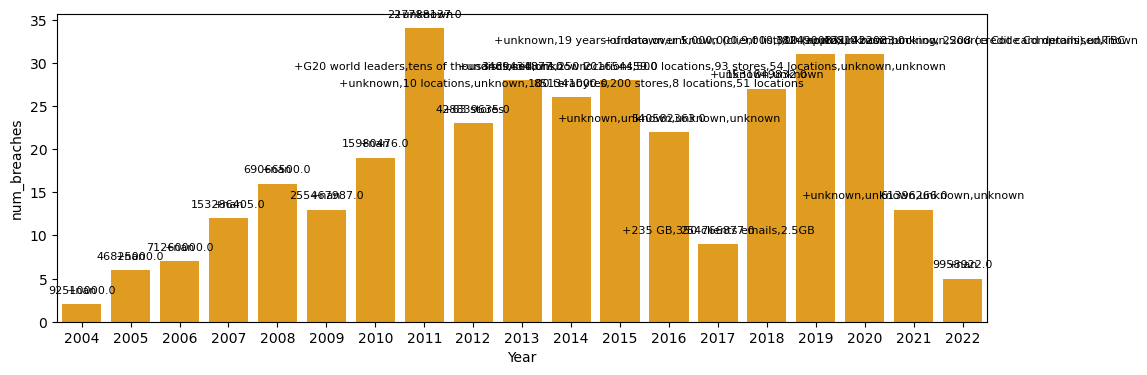

In [1864]:
f, ax = plt.subplots(figsize=(12, 4))

# create bar plot
bar_plot = sns.barplot(x='Year', y='num_breaches', data=all_counts, color="orange", ax=ax)

# iterate over the bars and annotate with values from another column
for p, value in zip(bar_plot.patches, all_counts['sum_num_records']):
    ax.annotate(f'{value}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=8)

# iterate over the bars and annotate with values from 'additional_value' column
for p, add_value in zip(bar_plot.patches, all_counts['non_numeric_records']):
    annotation_text = f'+{add_value}'
    ax.annotate(annotation_text,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=8)

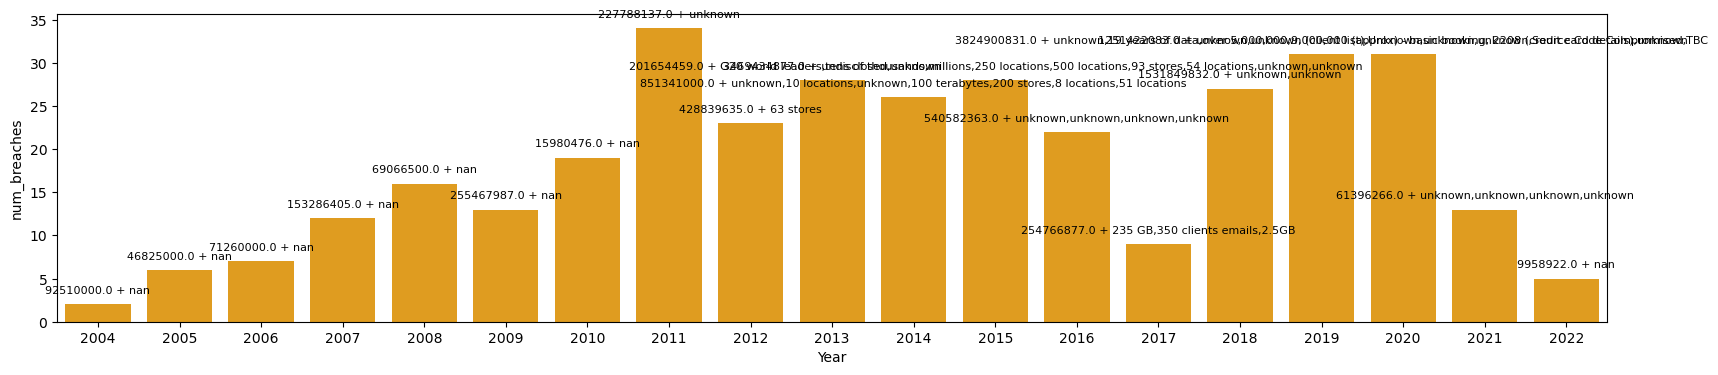

In [1865]:
f, ax = plt.subplots(figsize=(20, 4))

bar_plot = sns.barplot(x='Year', y='num_breaches', data=all_counts, color="orange", ax=ax)

# iterate over the bars and annotate with values from 'another_column' and 'additional_value'
for p, (another_value, add_value) in zip(bar_plot.patches, zip(all_counts['sum_num_records'], all_counts['non_numeric_records'])):
    annotation_text = f'{another_value} + {add_value}'
    ax.annotate(annotation_text,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=8)


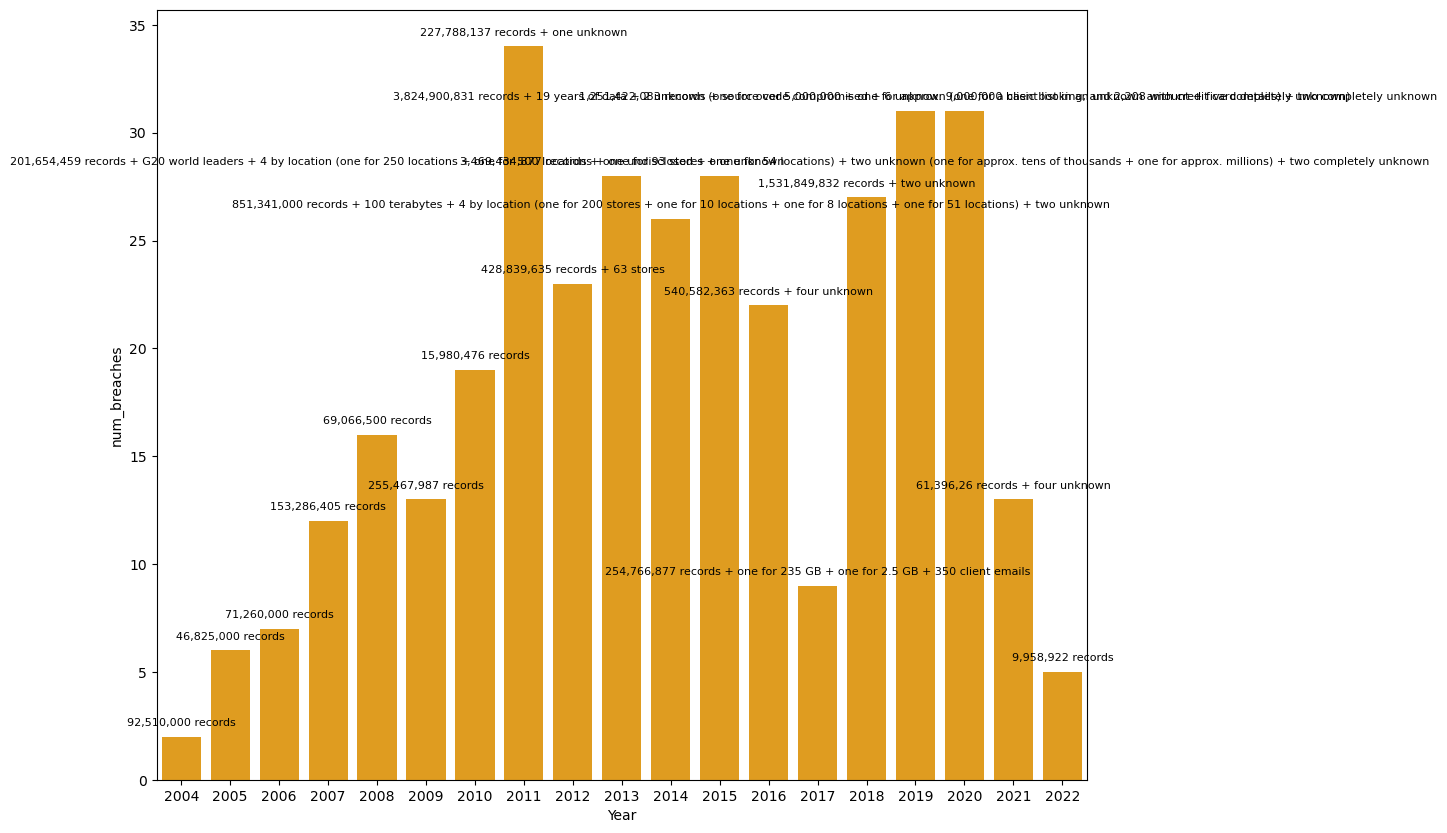

In [1866]:
f, ax = plt.subplots(figsize=(12, 10))

bar_plot = sns.barplot(x='Year', y='num_breaches', data=all_counts, color="orange", ax=ax)

# iterate over the bars and annotate with values from 'additional_value' column
for p, add_value in zip(bar_plot.patches, all_counts['all']):
    annotation_text = f'{add_value}'
    ax.annotate(annotation_text,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=8)

Text(1.0, 11.0, '46,825,000 records')

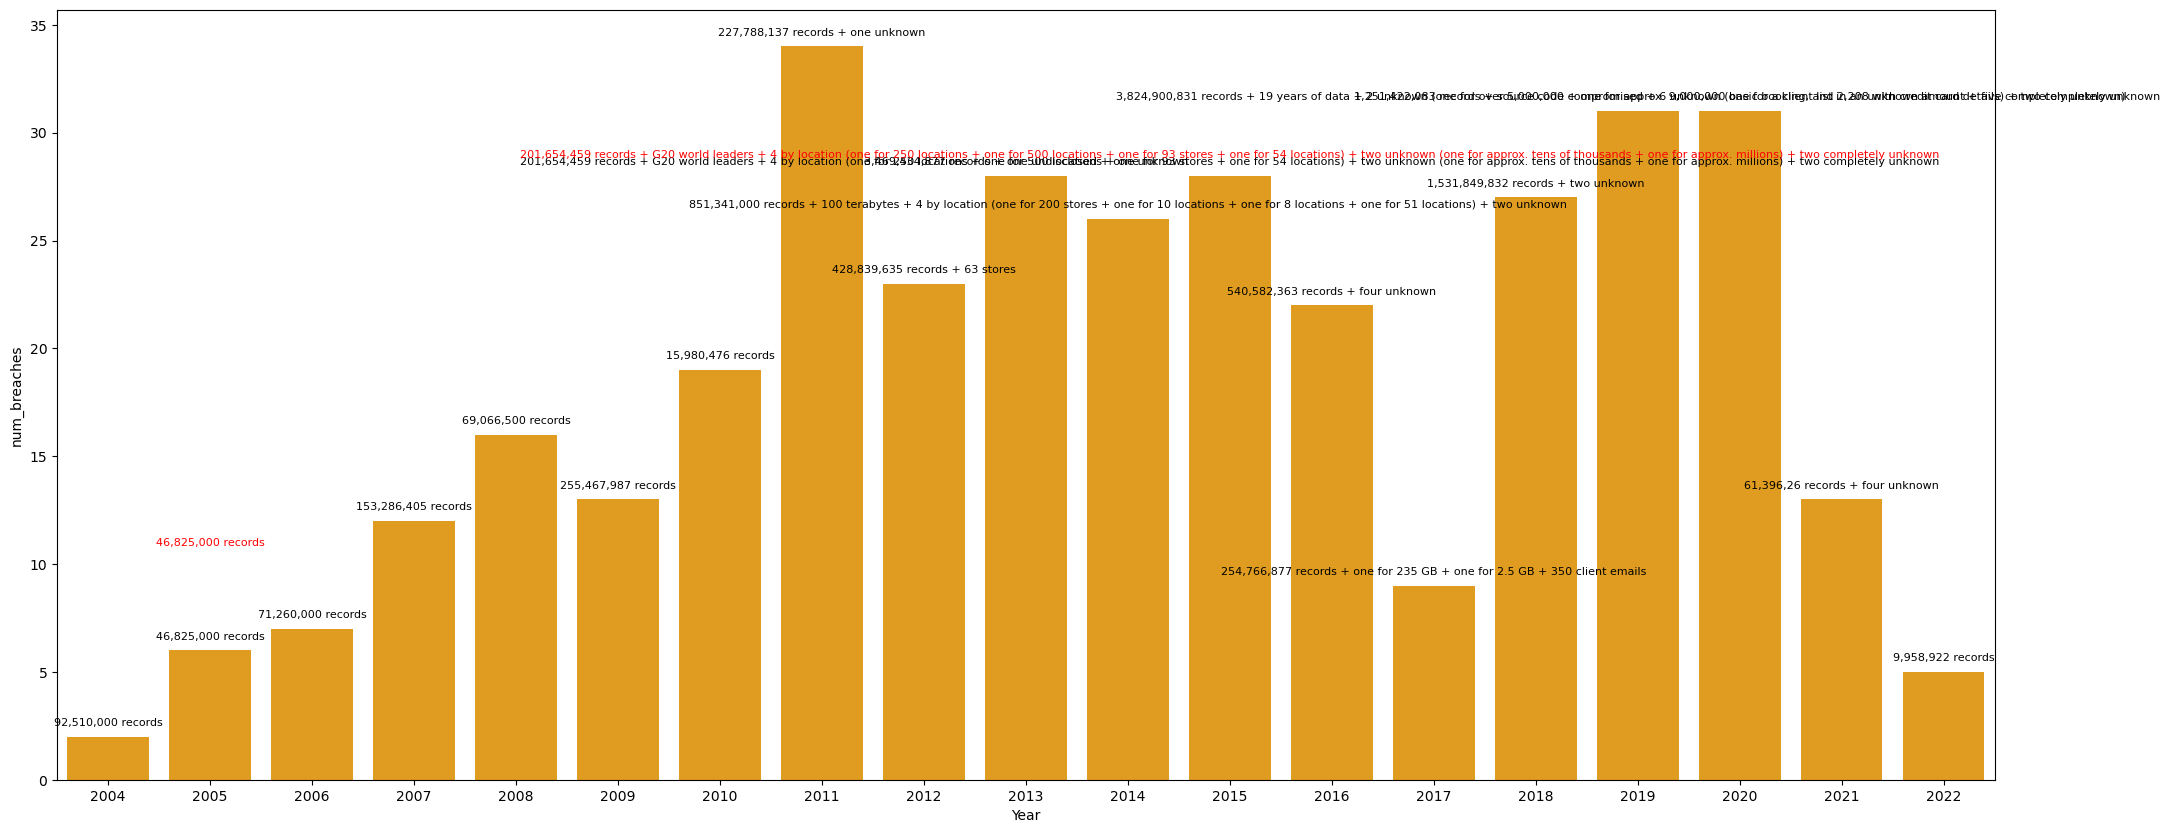

In [1867]:
f, ax = plt.subplots(figsize=(25, 10))

bar_plot = sns.barplot(x='Year', y='num_breaches', data=all_counts, color="orange", ax=ax)
#sns.lineplot(x='Year', y='sum_num_records', data=all_counts, color="black", ax=ax)

# initial annotations with default positions
for p, add_value in zip(bar_plot.patches, all_counts['all']):
    ax.annotate(f'{add_value}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=8)

# manually adjust specific annotations
ax.text(bar_plot.patches[11].get_x() + bar_plot.patches[11].get_width() / 2., 
        bar_plot.patches[11].get_height() + 1, f'{all_counts["all"].iloc[11]}', 
        ha='center', va='center', color='red', fontsize=8)

ax.text(bar_plot.patches[1].get_x() + bar_plot.patches[1].get_width() / 2., 
        bar_plot.patches[1].get_height() + 5, f'{all_counts["all"].iloc[1]}', 
        ha='center', va='center', color='red', fontsize=8)


Text(1.0, 11.0, '46,825,000 records')

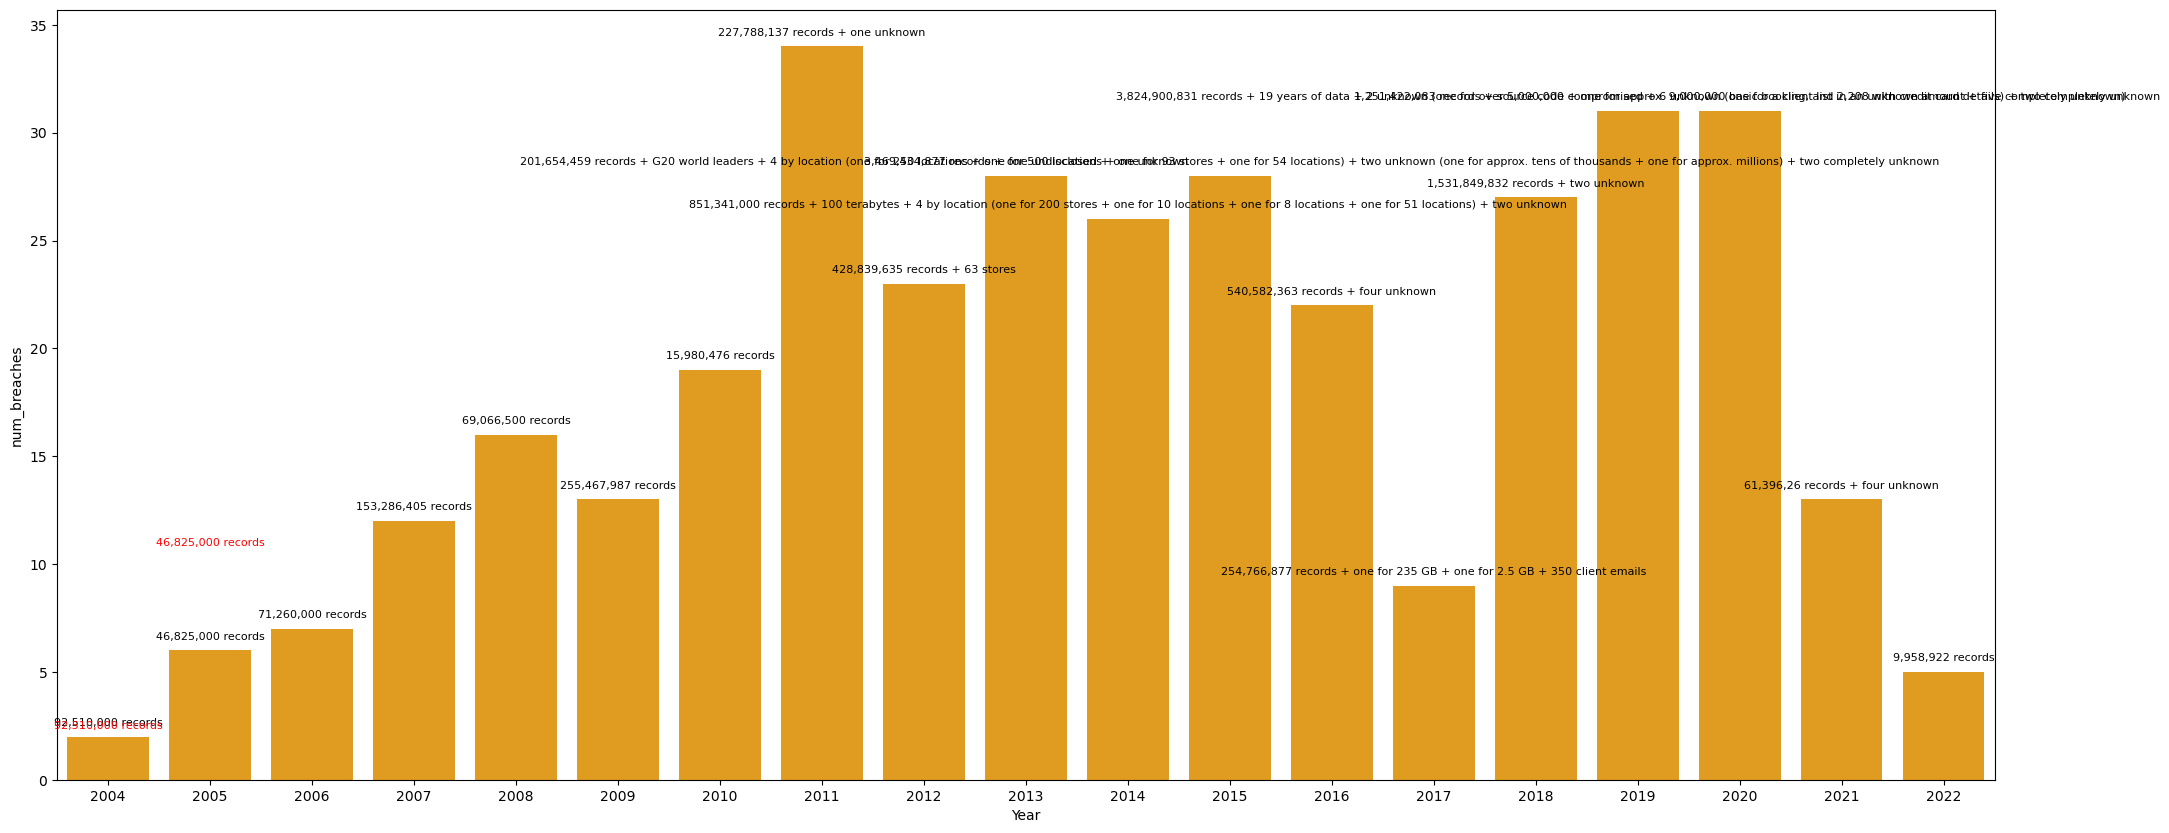

In [1868]:
f, ax = plt.subplots(figsize=(25, 10))

bar_plot = sns.barplot(x='Year', y='num_breaches', data=all_counts, color="orange", ax=ax)
#sns.lineplot(x='Year', y='sum_num_records', data=all_counts, color="black", ax=ax)

# initial annotations with default positions
for p, add_value in zip(bar_plot.patches, all_counts['all']):
    ax.annotate(f'{add_value}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=8)

# manually adjust specific annotations
ax.text(bar_plot.patches[0].get_x() + bar_plot.patches[11].get_width() / 2., 
        bar_plot.patches[0].get_height() + 0.5, f'{"92,510,000 records"}', 
        ha='center', va='center', color='red', fontsize=8)

ax.text(bar_plot.patches[1].get_x() + bar_plot.patches[1].get_width() / 2., 
        bar_plot.patches[1].get_height() + 5, f'{all_counts["all"].iloc[1]}', 
        ha='center', va='center', color='red', fontsize=8)

Text(11.0, 43.0, '201,654,459 records + G20 world leaders + 4 by location (one for 250 locations + one for 500 locations + one for 93\nstores + one for 54 locations) + two unknown (one for approx. tens of thousands + one for approx. millions) + two\ncompletely unknown')

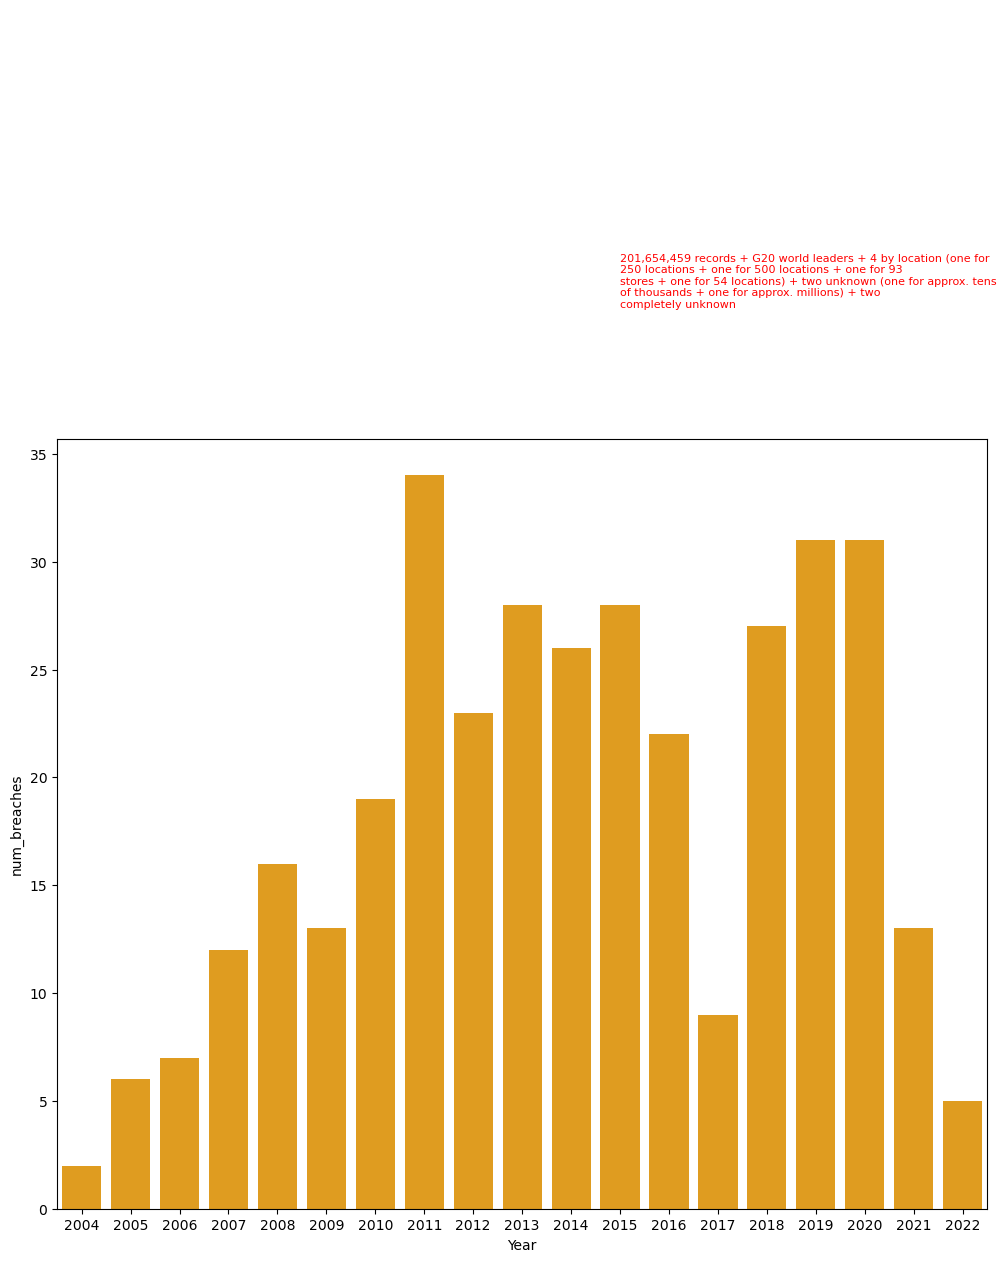

In [1869]:
import textwrap

def wrap_text(text, char_limit):
    """
    Splits a string into multiple lines based on a character limit.
    """
    return '\n'.join(textwrap.wrap(text, char_limit))

f, ax = plt.subplots(figsize=(12, 10))

bar_plot = sns.barplot(x='Year', y='num_breaches', data=all_counts, color="orange", ax=ax)

char_limit = 120 
wrapped_text = wrap_text(f'{all_counts["all"].iloc[11]}', char_limit)

ax.text(bar_plot.patches[11].get_x() + bar_plot.patches[11].get_width() / 2., 
        bar_plot.patches[11].get_height() + 15, wrapped_text, 
        ha='left', va='center', color='red', fontsize=8, wrap=True)
